## match open-field foragaing results to tree-maze results

In [1]:
%matplotlib inline
from pathlib import Path
from types import SimpleNamespace
from joblib import delayed, Parallel
import time
import traceback

import numpy as np
import pandas as pd
import scipy.stats as stats
pd.set_option('display.max_rows', 50)

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from matplotlib_venn import venn2, venn3

import TreeMazeAnalyses2.Utils.robust_stats as rs
import TreeMazeAnalyses2.Analyses.experiment_info as ei
import TreeMazeAnalyses2.Analyses.spatial_functions as sf
import TreeMazeAnalyses2.Analyses.open_field_functions as of
import TreeMazeAnalyses2.Analyses.plot_functions as pf
#import TreeMazeAnalyses2.Analyses.cluster_match_functions as cmf

#import statsmodels.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from umap import UMAP
from sklearn.cluster import KMeans, BisectingKMeans, AgglomerativeClustering
from sklearn.model_selection import KFold
# from sklearn.metricsx import davies_bouldin_score, silhouette_score
from importlib import reload

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
info = ei.SummaryInfo()

## unit task overlap

In [3]:
o_flag = False
unit_table = info.get_unit_table(overwrite=o_flag)

In [4]:
pd.crosstab(unit_table.subject, unit_table.task)

task       OF  T3g  T3gj  T3i  T3j
subject                           
Al         62  112     0    0    0
Ca         64   97     0    0    0
Cl       1043  916     0   47    0
Li        656  579     0   93    0
Mi         35   43     0    0    0
Ne        338  271    13   93    2

In [5]:
unit_table[(unit_table.session=='Li_T3g_062018') & (unit_table.tt==10)].iloc[0]

subject_cl_id                                        674
subject                                               Li
session                                    Li_T3g_062018
task                                                 T3g
date                                               62018
subsession                                             0
tt                                                    10
depth                                              18.25
unique_cl_name             Li_T3g_062018-tt10_d18.25_cl2
session_cl_id                                          4
unit_type                                           cell
n_matches_con                                        1.0
subject_cl_match_con_id                            221.0
n_matches_lib                                        1.0
subject_cl_match_lib_id                            221.0
snr                                                  NaN
fr                                                  6.21
isi_viol_rate                  

In [10]:
a = unit_table.match_lib_multi_task_id.unique()
a.sort()
a

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

(<Figure size 2250x1500 with 1 Axes>, <AxesSubplot:>)

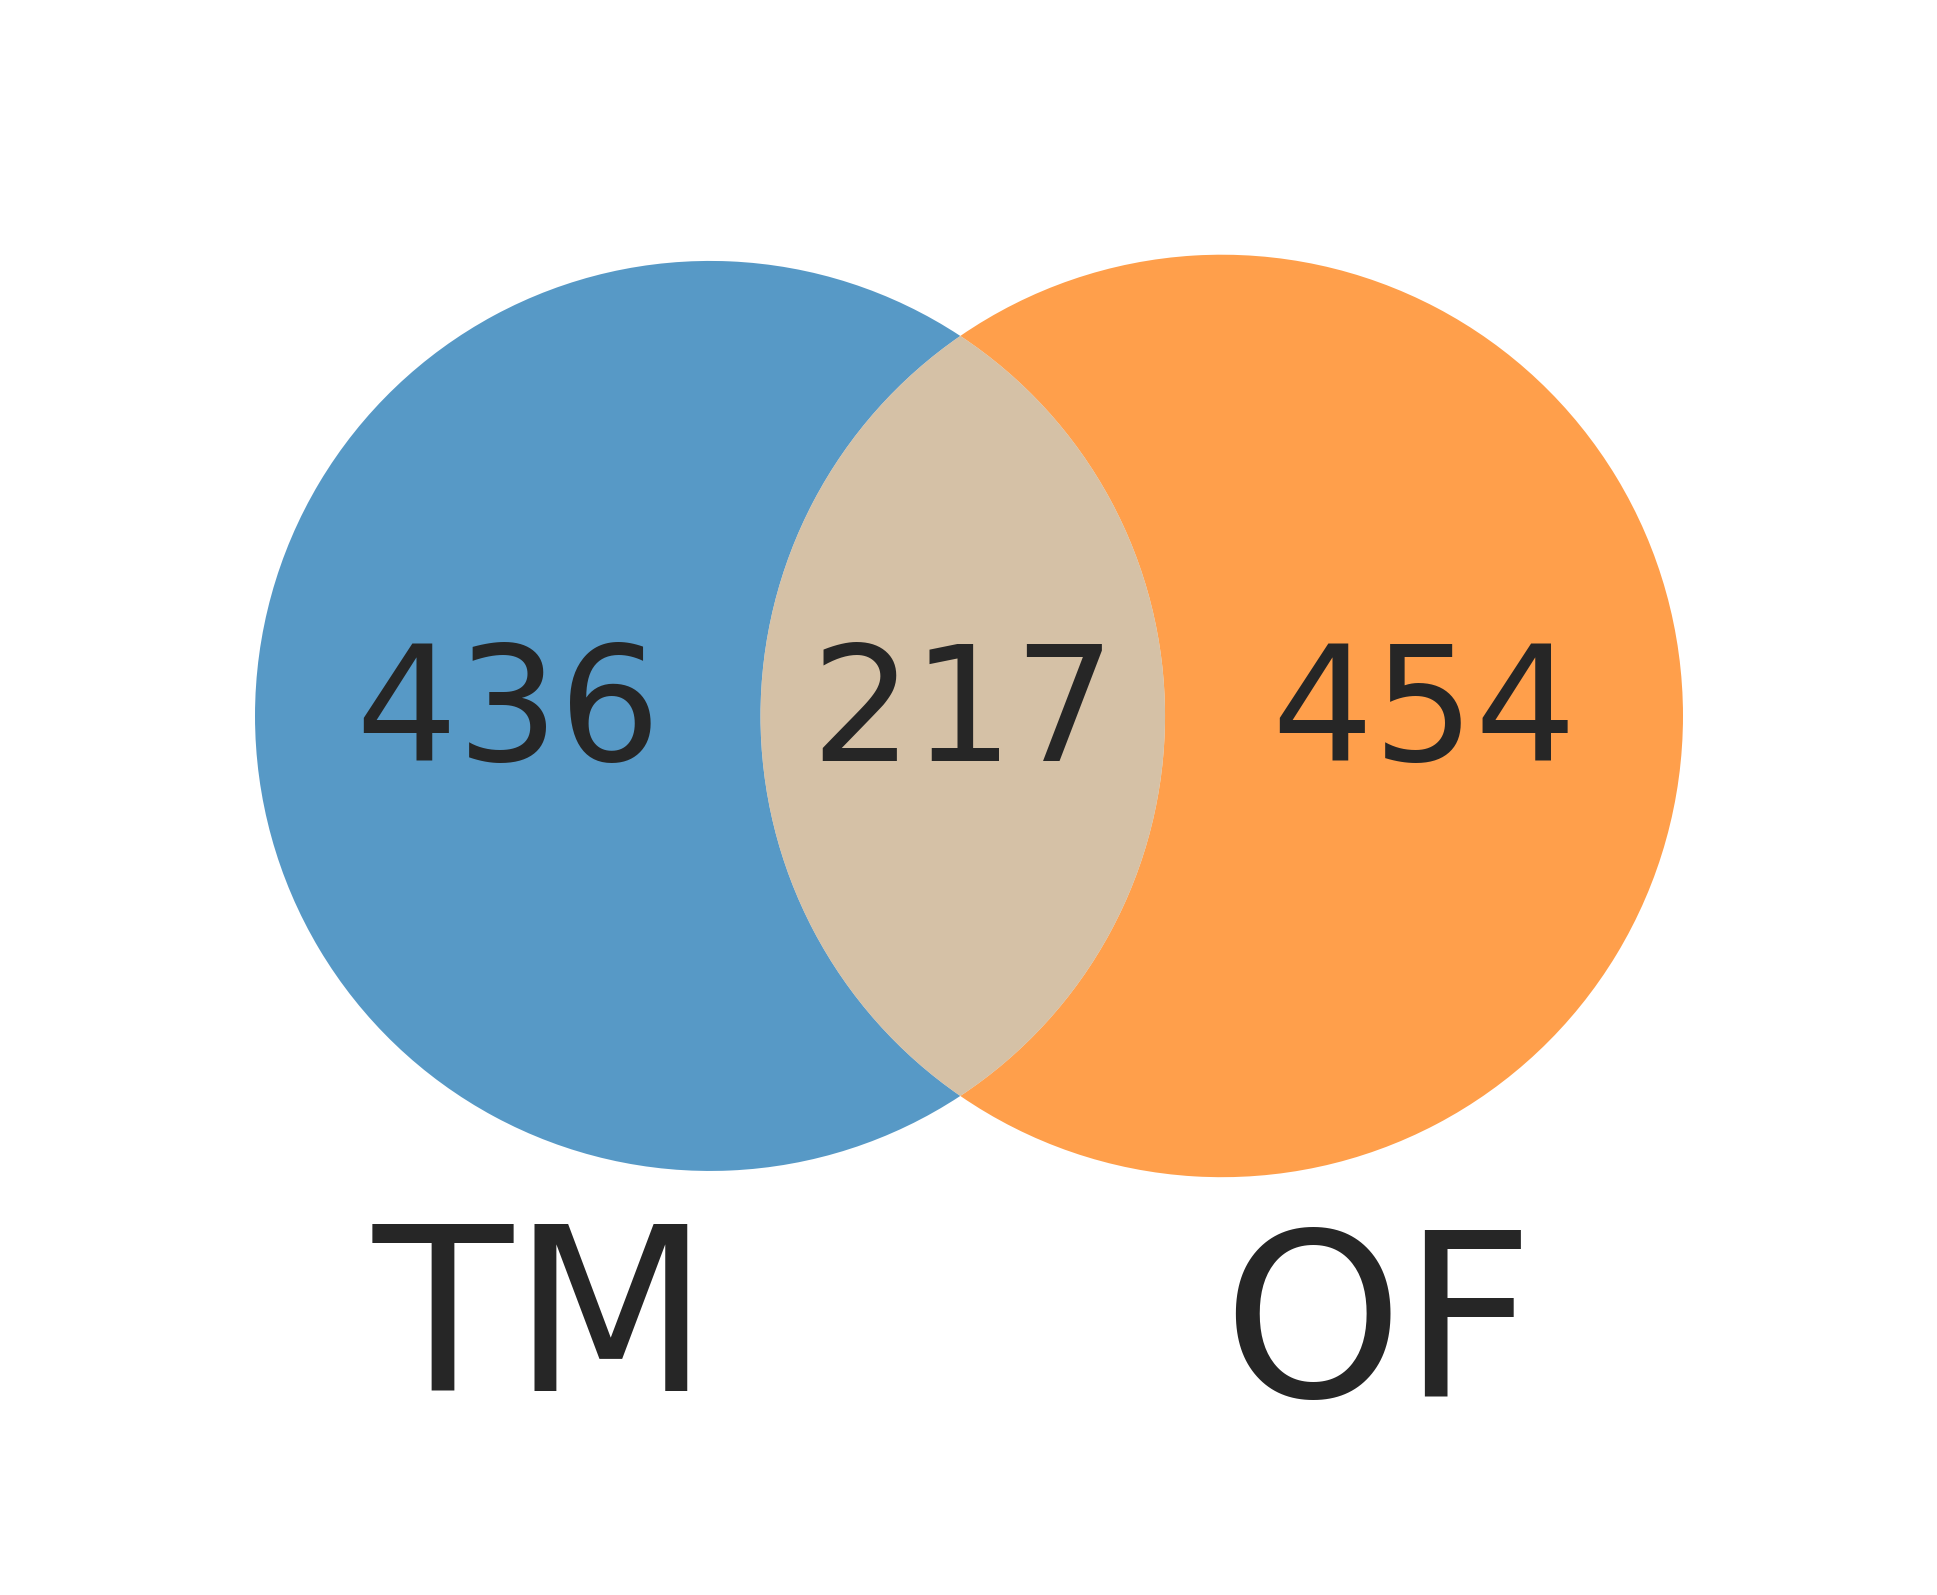

In [25]:
pf = reload(pf)
f = pf.CrossTaskFigures()
#f.plot_unit_overlap(save_flag=True)
f.plot_unit_overlap(save_flag=True, save_format='svg')

# f.savefig(fig5_path/(f'ClusterMatchesXTasks.pdf'), bbox_inches='tight', dpi=600)
# f.savefig(fig5_path/(f'ClusterMatchesXTasks.png'), bbox_inches='tight', dpi=600)

#### number of matched OF/T3 sessions, and sessions with multiple matches on each

In [6]:
matched_units = unit_table.match_lib_multi_task_id>0
T = pd.crosstab(unit_table.match_lib_multi_task_id[matched_units], unit_table.task2[matched_units]).value_counts()
print(T), print(T.sum())

OF  T3
1   1     144
2   1      37
1   2      27
2   2       3
1   3       2
2   3       1
3   1       1
    2       1
dtype: int64
216


(None, None)

In [16]:
a = unit_table.session[matched_units].value_counts()
print(a)

n_OF_sessions = len([s for s in a.index if 'OF' in s])
n_TM_sessions = len([s for s in a.index if 'T3' in s])
print(n_OF_sessions, n_TM_sessions)

Li_OF_062518          10
Cl_OF_120318           9
Cl_T3g_112118_0001     8
Cl_OF_112118           8
Cl_T3g_120518          8
                      ..
Cl_T3g_020619          1
Cl_T3g_020719          1
Cl_OF_020719           1
Cl_T3g_112818          1
Mi_T3g_011020          1
Name: session, Length: 158, dtype: int64
76 82


## matched scores

In [72]:
%%time
ei = reload(ei)
info = ei.SummaryInfo()

match_table = info.get_unit_match_table(overwrite=False)
combined_scores_table = info.get_combined_scores_matched_units(overwrite=True)

of_score_names = [c for c in combined_scores_table.columns if 'OF' in c]
tm_score_names = [c for c in combined_scores_table.columns if 'TM' in c]

print("OF Scores")
print(of_score_names)
print()
print("TM Scores")
print(tm_score_names)
combined_scores_table.head()


OF Scores
['OF-agg_sdp-map_r', 'OF-agg_sdp-r2', 'OF-hd-agg_sdp_coef', 'OF-hd-coef', 'OF-hd-map_r', 'OF-hd-r2', 'OF-pos-agg_sdp_coef', 'OF-pos-coef', 'OF-pos-map_r', 'OF-pos-r2', 'OF-speed-agg_sdp_coef', 'OF-speed-coef', 'OF-speed-map_r', 'OF-speed-r2', 'OF-metric_score_border', 'OF-metric_score_grid', 'OF-metric_score_hd', 'OF-metric_score_speed', 'OF-metric_score_pos']

TM Scores
['TM-remap_cue', 'TM-remap_rw', 'TM-stability_tm', 'TM-rate_cue', 'TM-rate_rw', 'TM-global_cue', 'TM-global_rw', 'TM-enc_uz_cue', 'TM-enc_uz_rw', 'TM-fr_uz_cue', 'TM-fr_uz_rw']
CPU times: user 430 ms, sys: 19.9 ms, total: 450 ms
Wall time: 451 ms


match_cl_id subject  TM-remap_cue  TM-remap_rw  TM-stability_tm  \
0            0      Li     -0.477471    -0.992209         1.047540   
1            1      Li     -0.137774    -1.618546         0.734345   
2            2      Li     -0.183025    -0.372746         0.613068   
3            3      Li     -0.746639    -0.885057         0.796650   
4            4      Li           NaN          NaN              NaN   

   TM-rate_cue  TM-rate_rw  TM-global_cue  TM-global_rw  TM-enc_uz_cue  ...  \
0     0.043149    0.064612       0.036118      0.063609      -0.831522  ...   
1     0.024987    0.078723       0.006386      0.055165      -0.869318  ...   
2     0.024433    0.059178       0.019781      0.063531      -0.907115  ...   
3     0.125429    0.096856       0.117374      0.074609      -0.302372  ...   
4          NaN         NaN            NaN           NaN            NaN  ...   

   OF-pos-r2  OF-speed-agg_sdp_coef  OF-speed-coef  OF-speed-map_r  \
0   0.023935              -0.609305      -0.434155        0.529885   
1   0.022281              -0.281896       0.011609        0.579419   
2   0.068407               0.295864      -0.026107        0.597518   
3   0.058297               0.582324       1.092153        0.740471   
4   0.139372              -0.801568      -0.327554        0.294793   

   OF-speed-r2  OF-metric_score_border  OF-metric_score_grid  \
0     0.005991                0.026876                   NaN   
1     0.008478                0.378885                   NaN   
2     0.020432                0.410825             -0.116138   
3     0.067012                0.327252                   NaN   
4     0.005219               -0.280860             -0.214551   

   OF-metric_score_hd  OF-metric_score_speed  OF-metric_score_pos  
0            0.365053              -0.010321             0.290692  
1            0.055527               0.050962             0.442600  
2            0.052443               0.053874             0.425990  
3            0.033747               0.196234             0.290122  
4            0.855297              -0.019892             0.356961  

[5 rows x 32 columns]

In [75]:
combined_scores_table2 = info.get_combined_scores_matched_units(mean_multi_matches=False)
combined_scores_table2.shape


(307, 32)

## cluster data according to OF data

In [19]:
%%time
ei = reload(ei)
info = ei.SummaryInfo()

overwrite= False
z_score = False

cluster_error_table = info.get_matched_of_cell_cluster_error_table(overwrite=overwrite, z_score=z_score)

CPU times: user 42.9 ms, sys: 0 ns, total: 42.9 ms
Wall time: 42.6 ms


In [20]:
cluster_error_table.head()

repeat  n_clusters  umap_neighbor  fold  split    cosine        MSE
0       0           1             15     0  train  0.112130  40.356018
1       0           1             15     0   test  0.117006  35.373951
2       0           1             15     1  train  0.119775  40.389118
3       0           1             15     1   test  0.084845  35.771271
4       0           1             15     2  train  0.109456  37.081303

(<Figure size 3000x2250 with 1 Axes>,
 <AxesSubplot:xlabel='# Clusters', ylabel='C.D. Error'>)

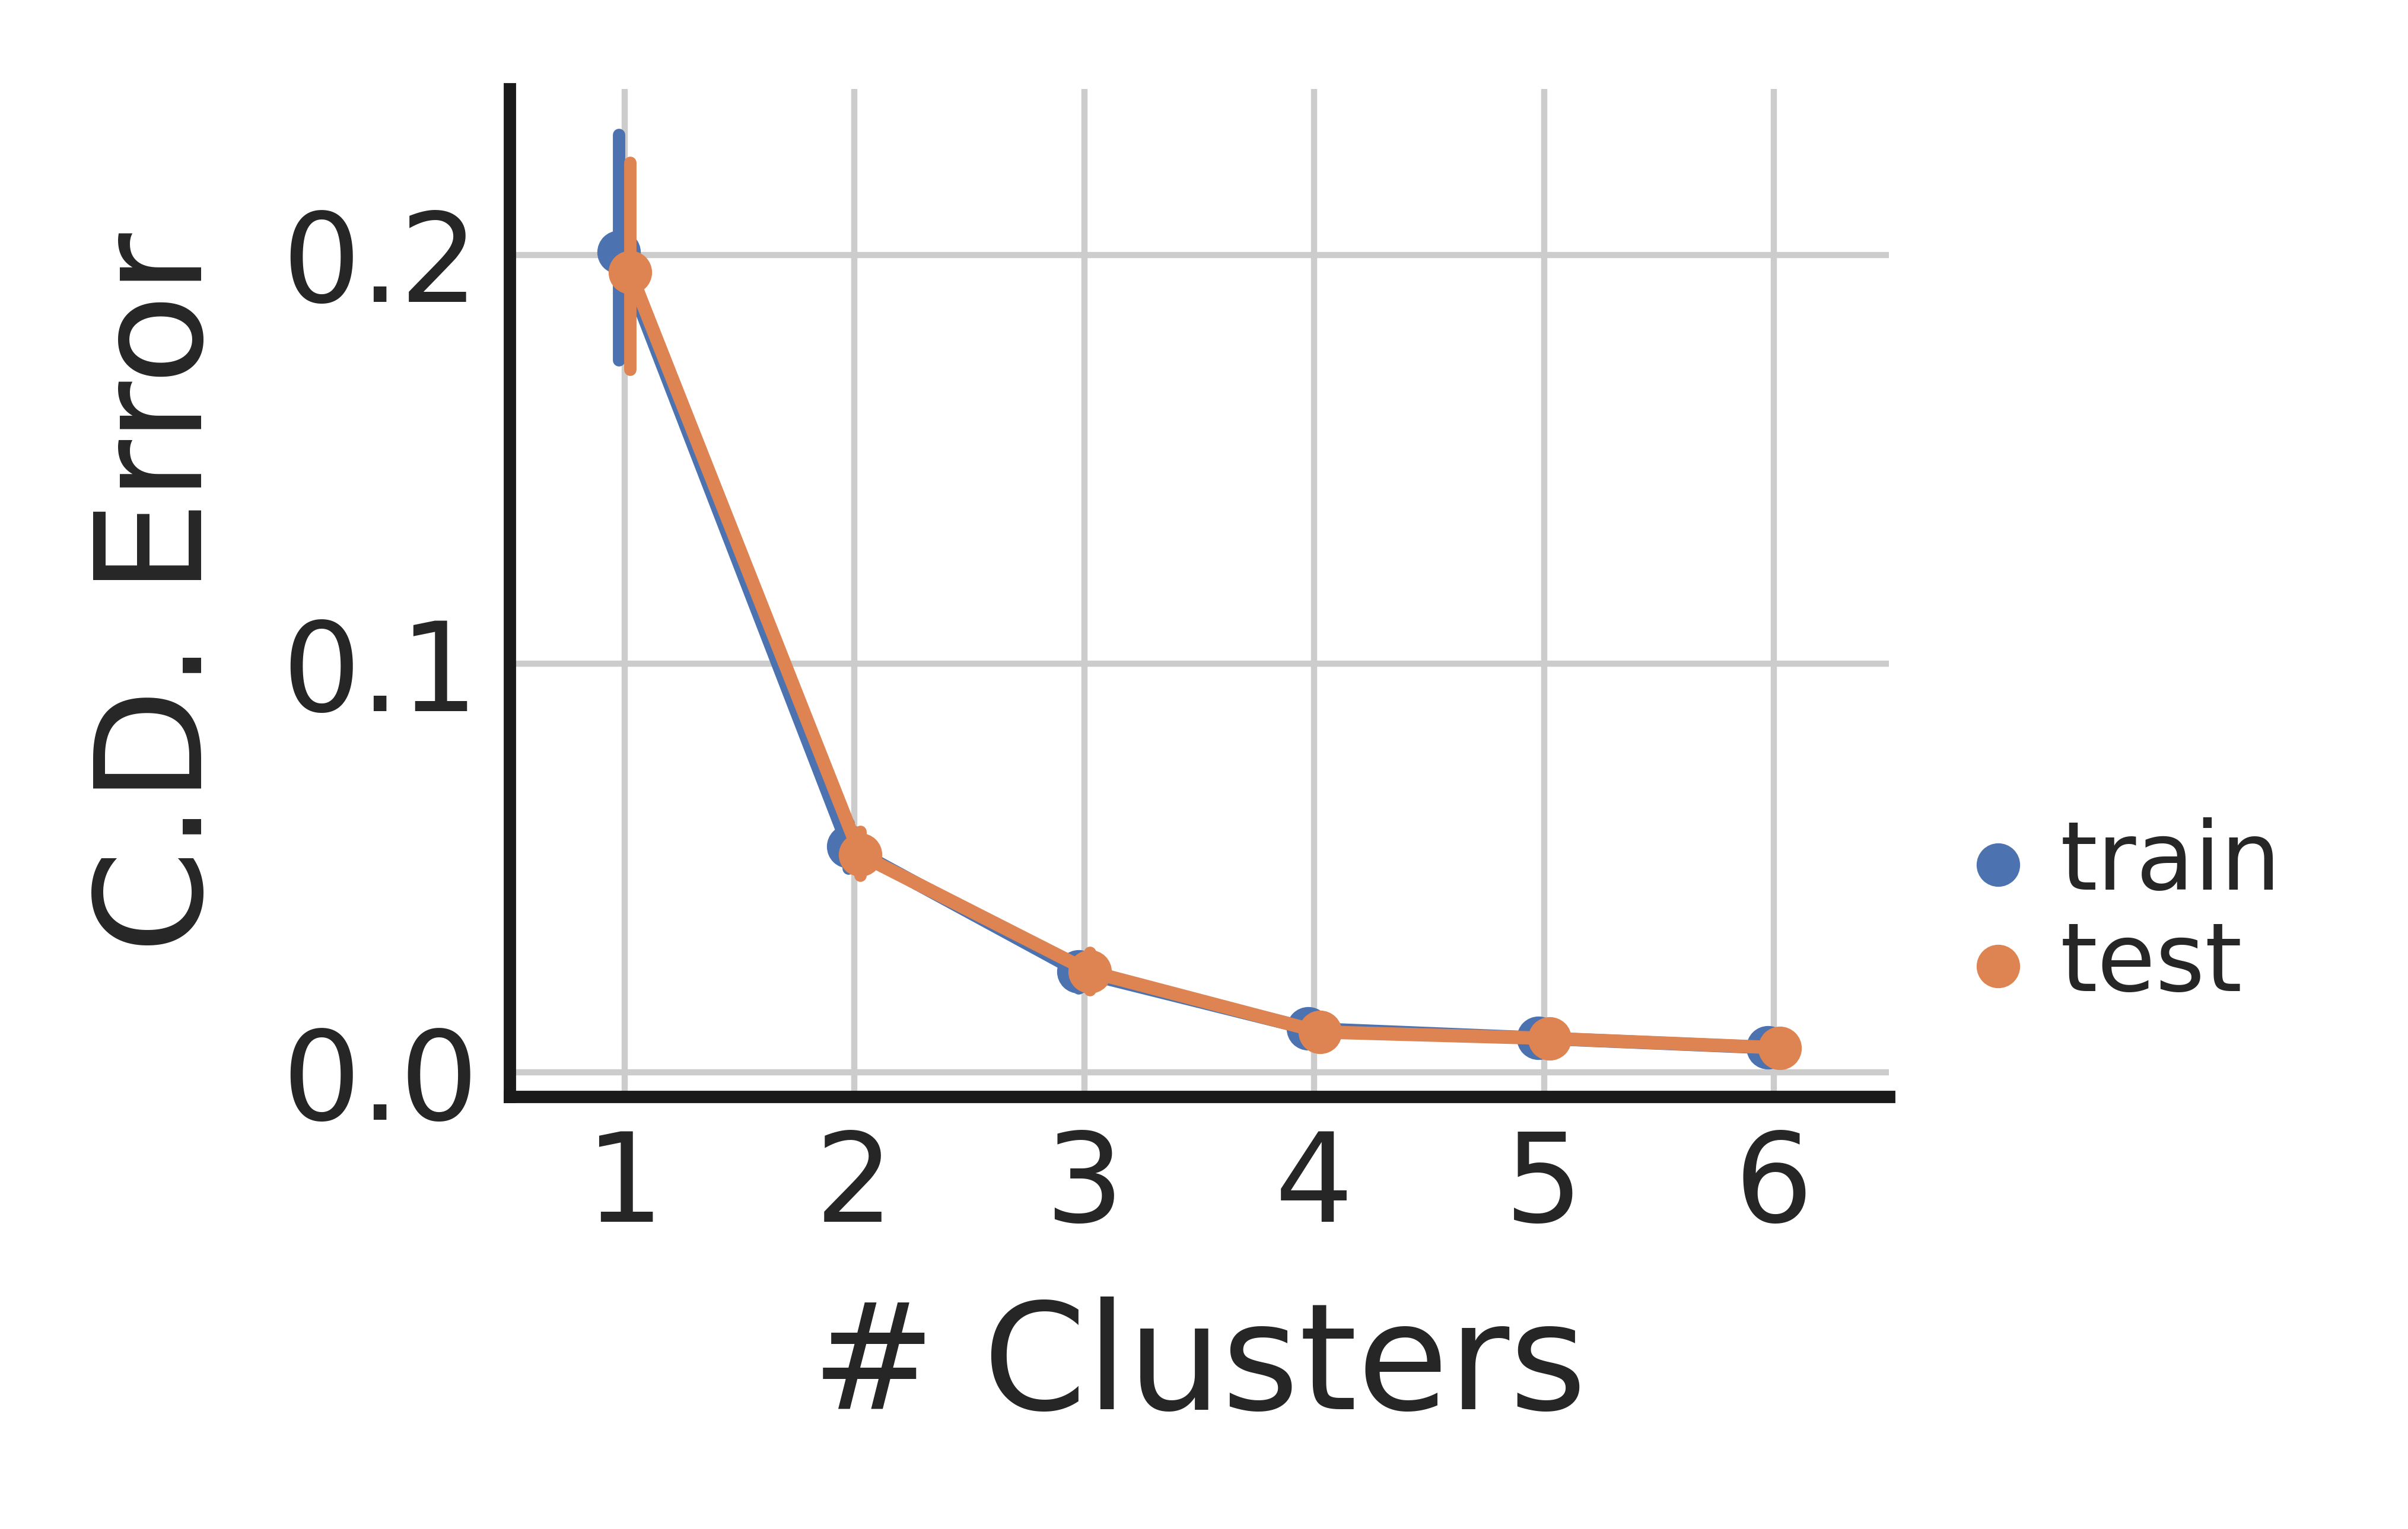

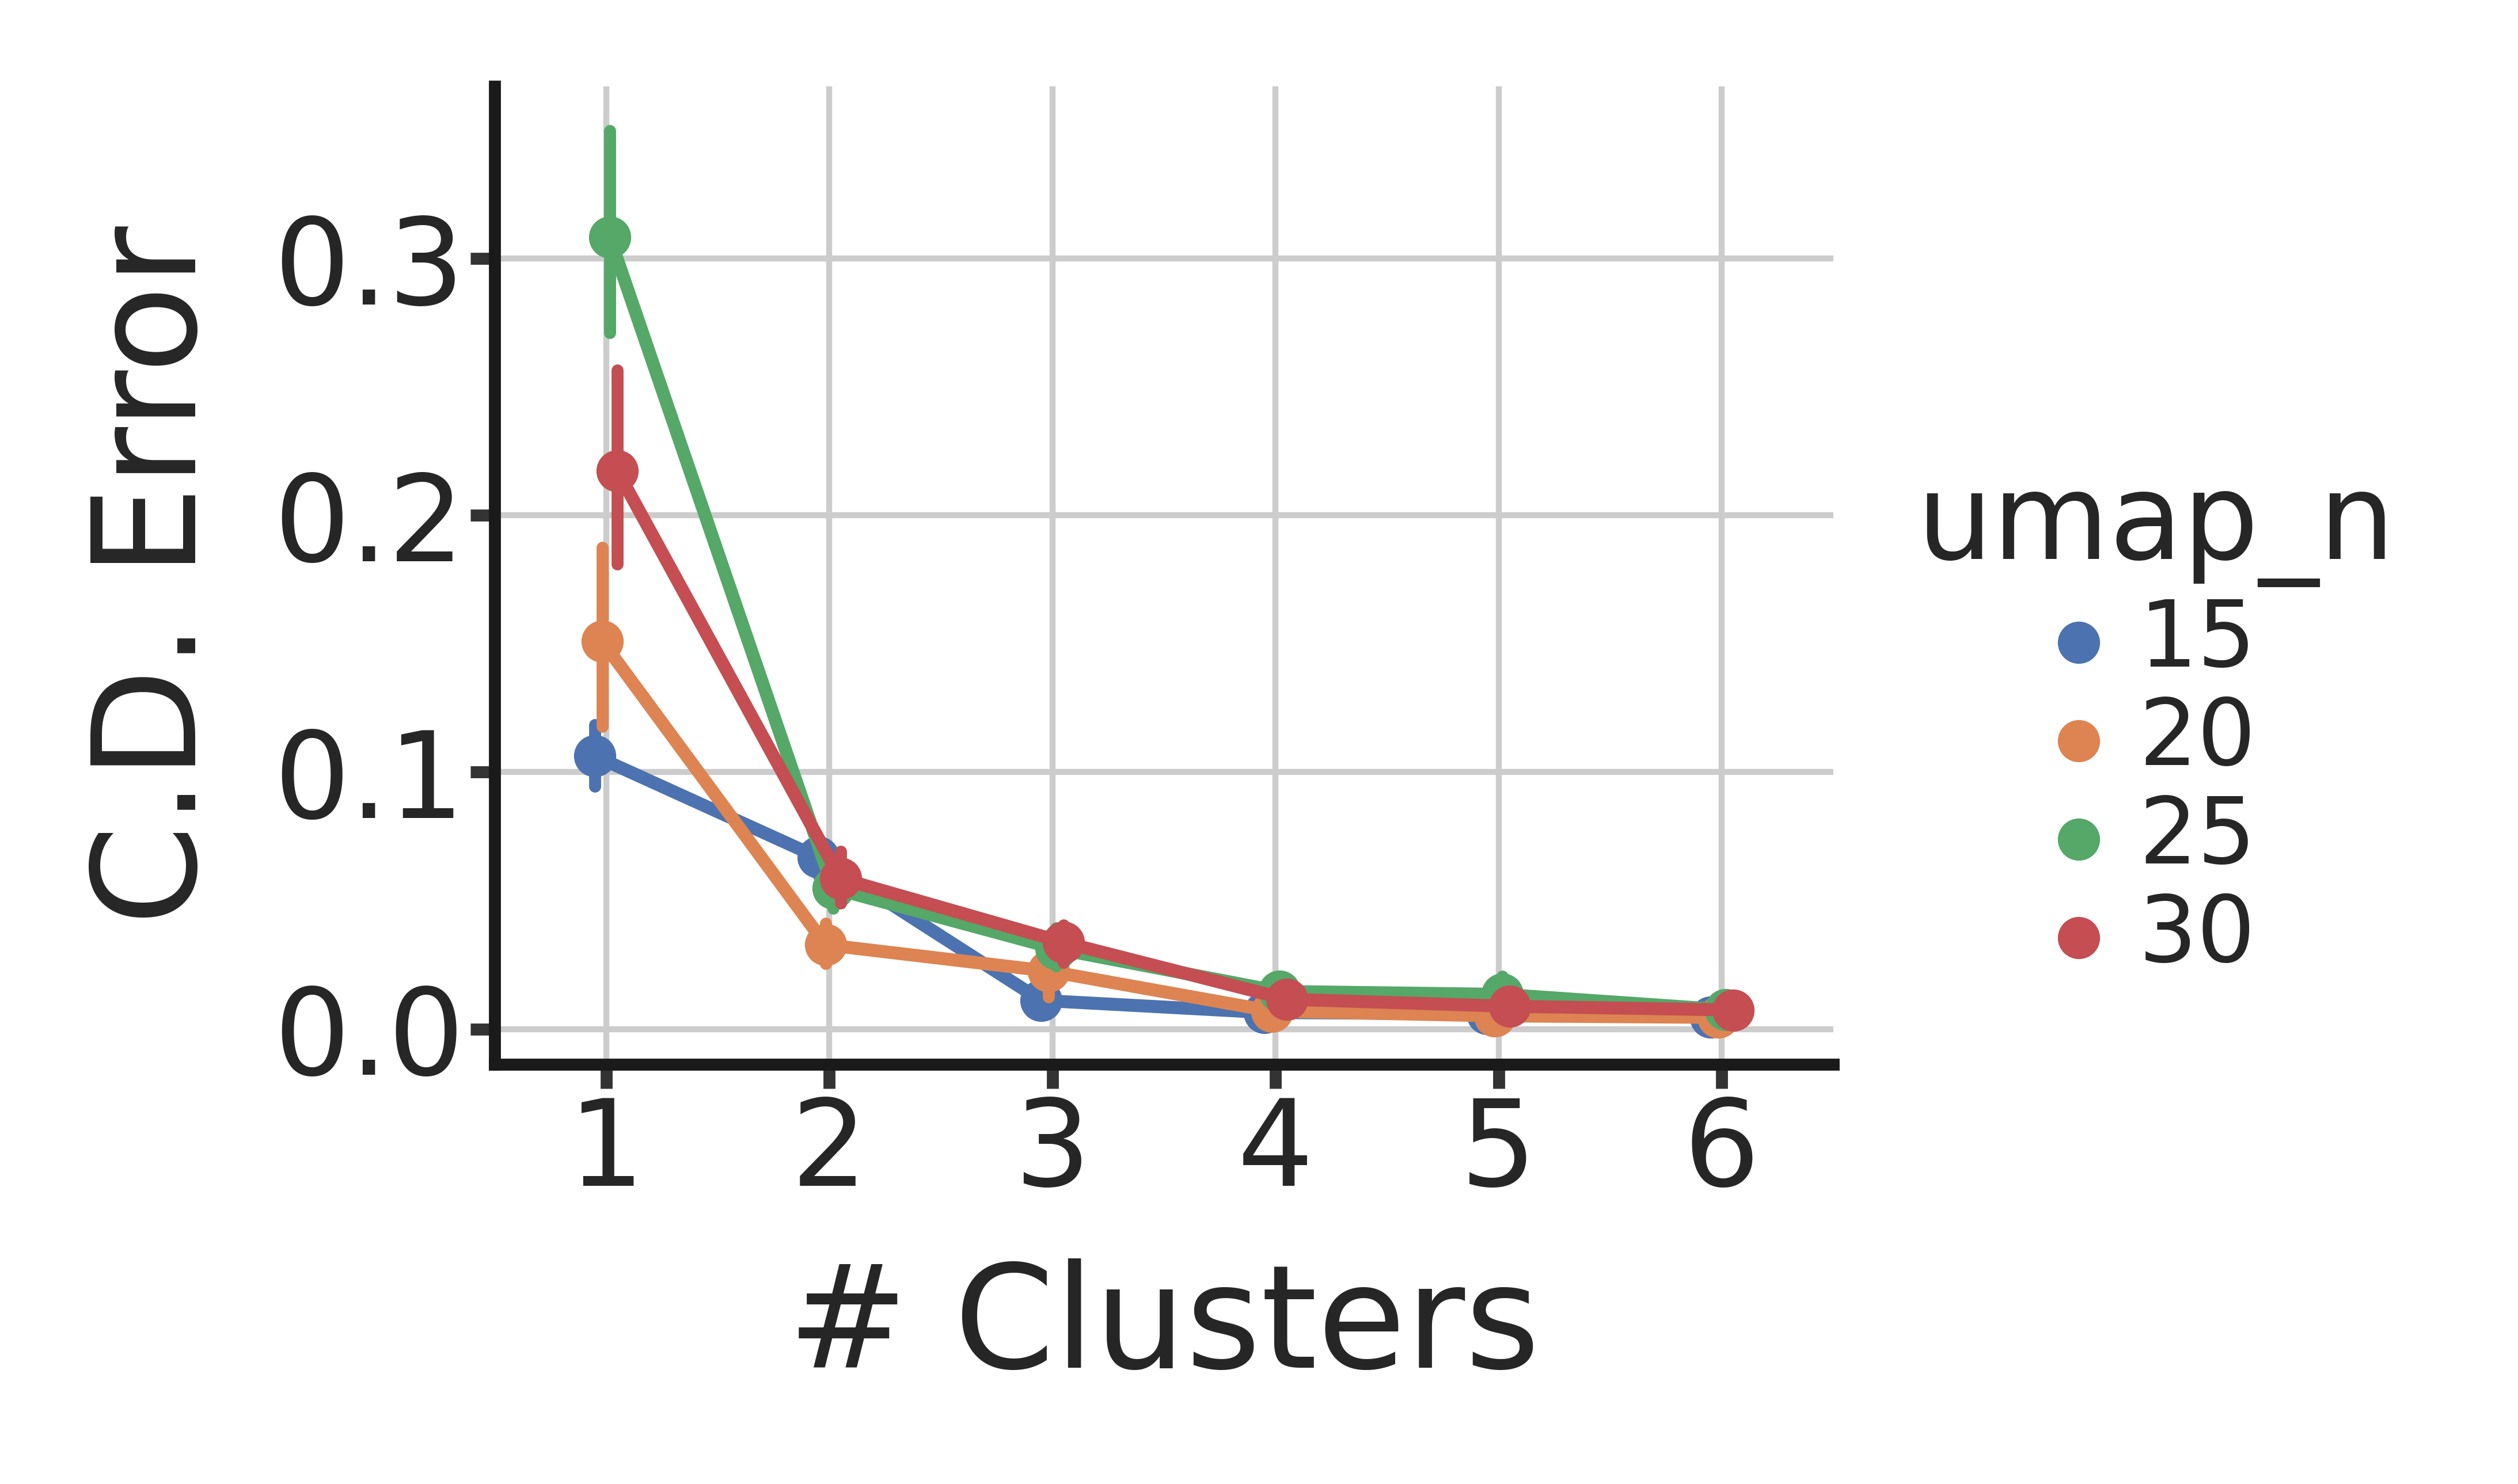

In [22]:
#f = pf.CrossTaskFigures()
f.plot_error_vs_OF_clusters(table=cluster_error_table, hue_var='split', score_type='cosine', save_flag=True)
f.plot_error_vs_OF_clusters(table=cluster_error_table[cluster_error_table.split=='test'], hue_var='umap_neighbor', score_type='cosine', save_flag=True)

(<Figure size 3000x2250 with 1 Axes>,
 <AxesSubplot:xlabel='# Clusters', ylabel='C.D. Error'>)

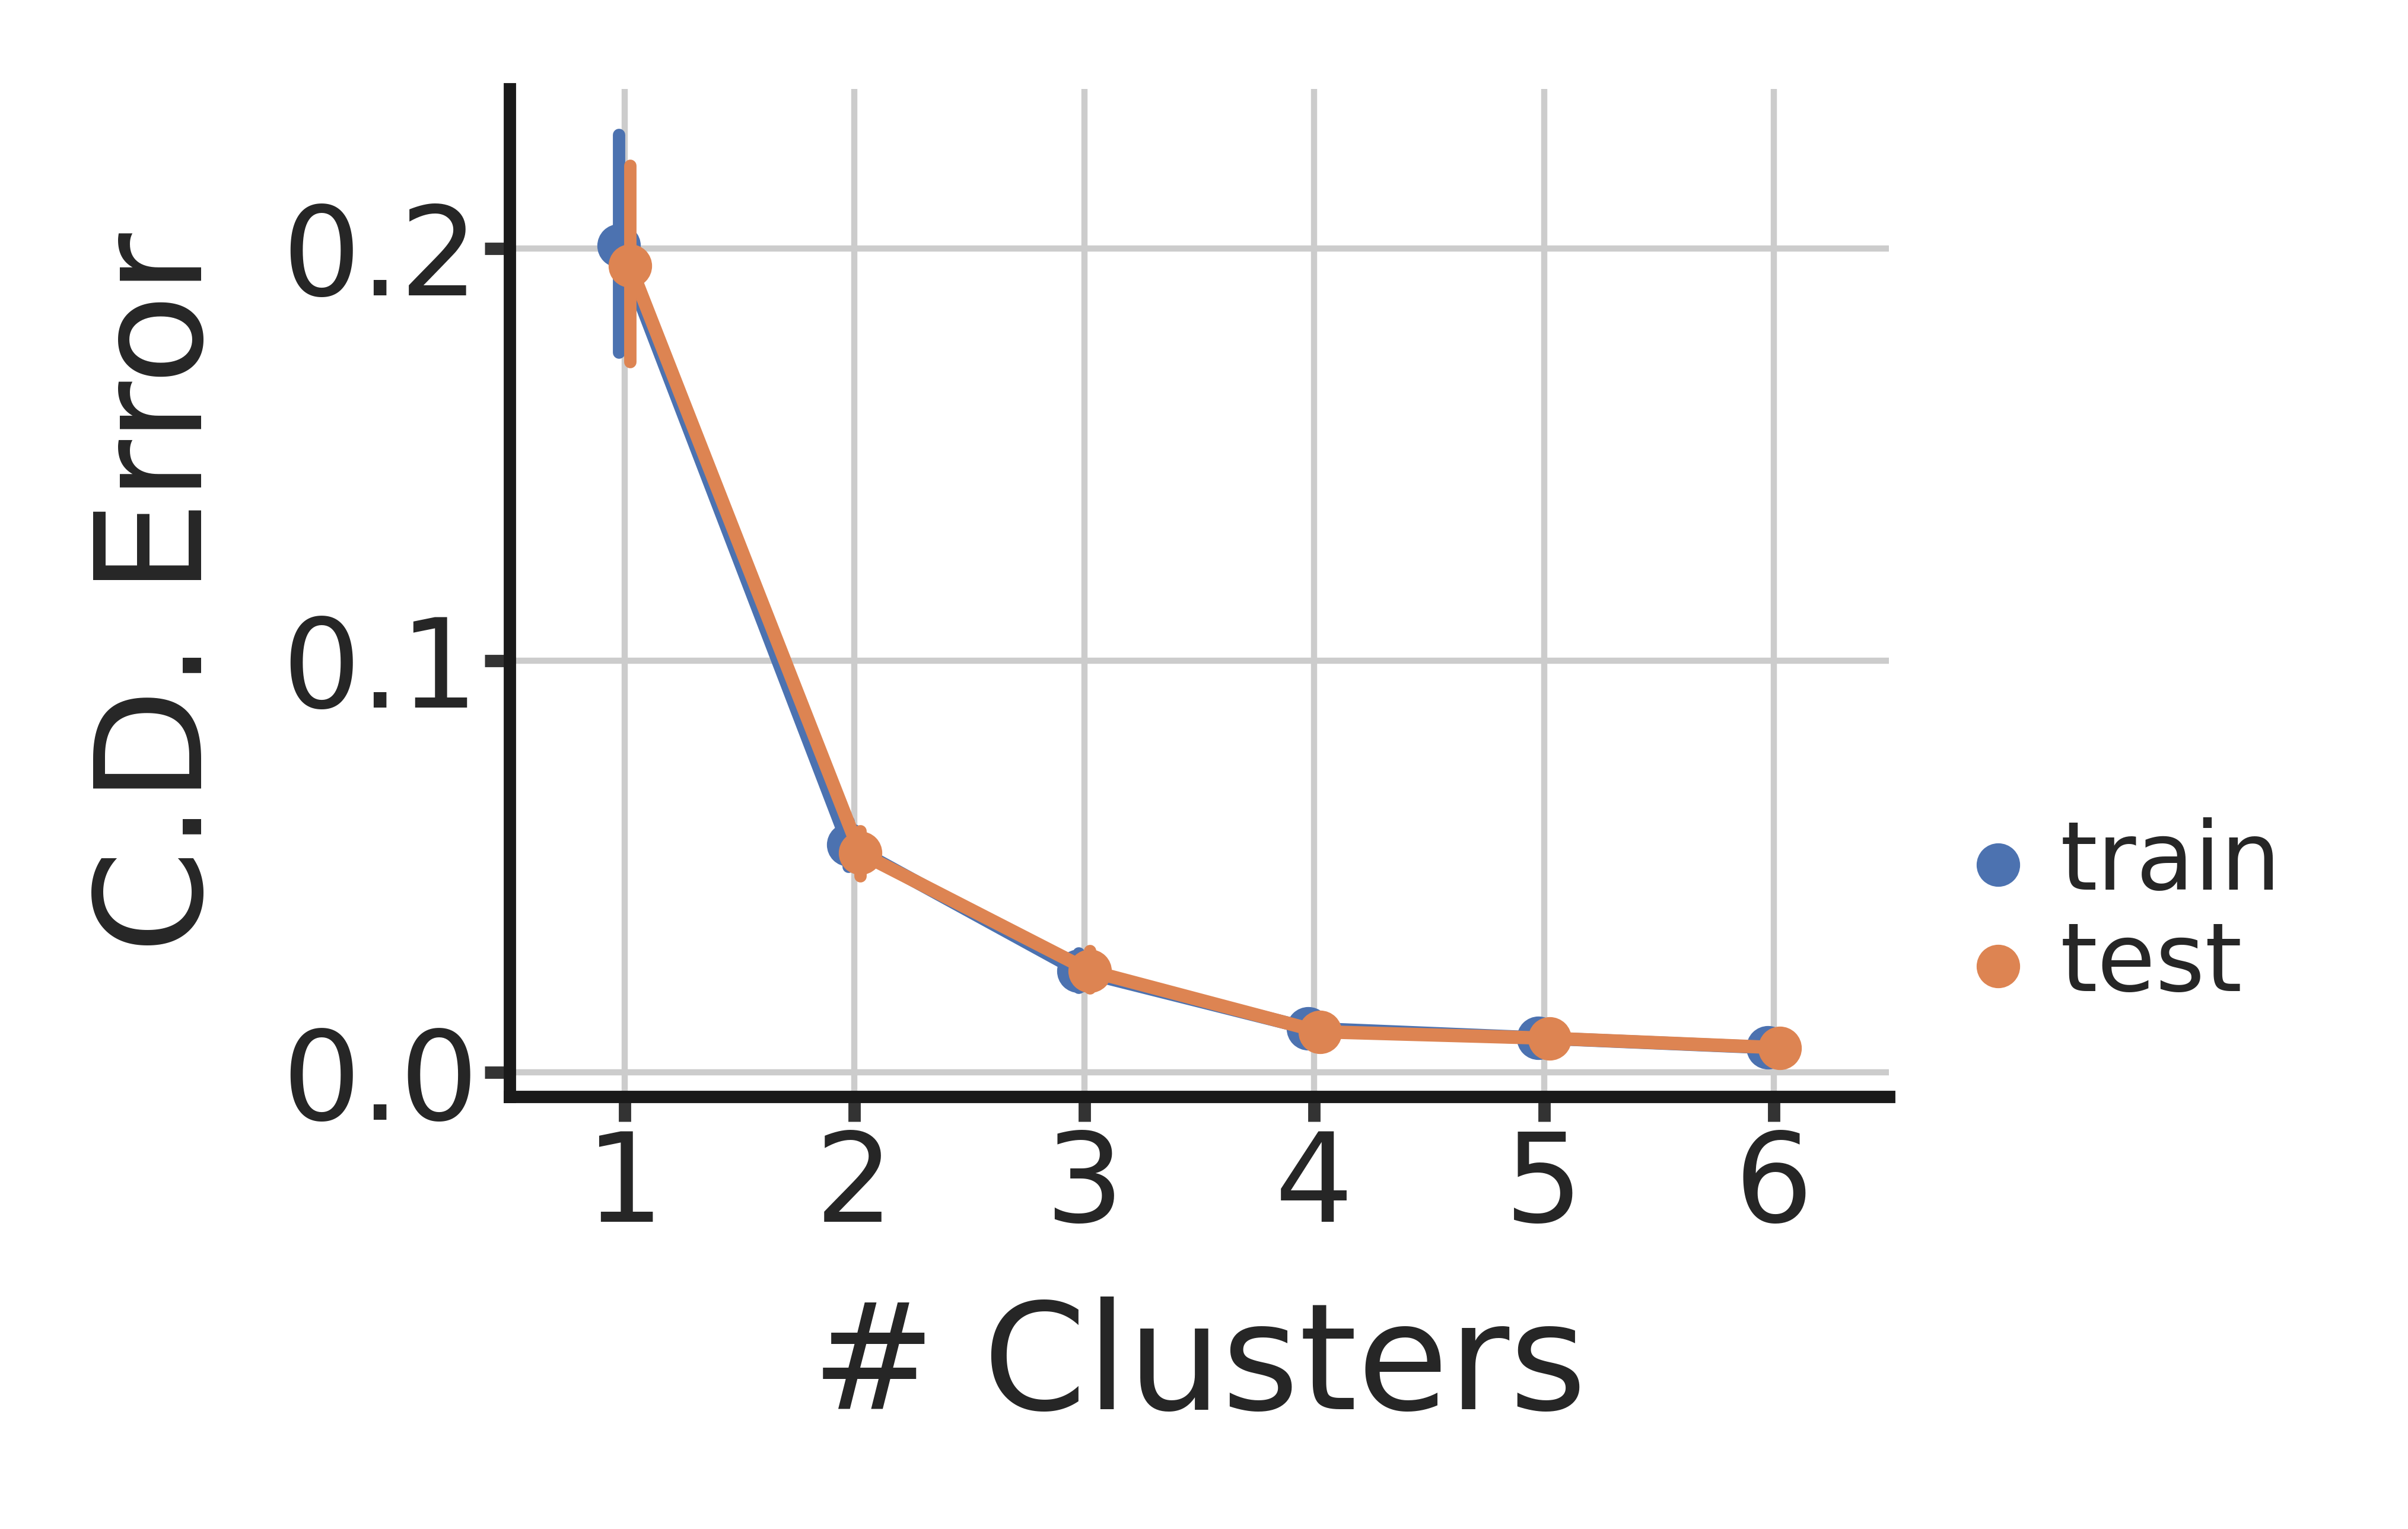

In [24]:
f.plot_error_vs_OF_clusters(table=cluster_error_table, hue_var='split', score_type='cosine', save_flag=True, save_format='svg')

In [22]:
%%time
ei = reload(ei)
info = ei.SummaryInfo()

overwrite = False
z_score = False
rs = 39
cluster_table = info.get_matched_of_cell_clusters(overwrite=overwrite, z_score=z_score, random_state=rs)

print(cluster_table.Cluster.value_counts())

0    98
2    60
1    59
Name: Cluster, dtype: int64
CPU times: user 40.6 ms, sys: 0 ns, total: 40.6 ms
Wall time: 39.9 ms


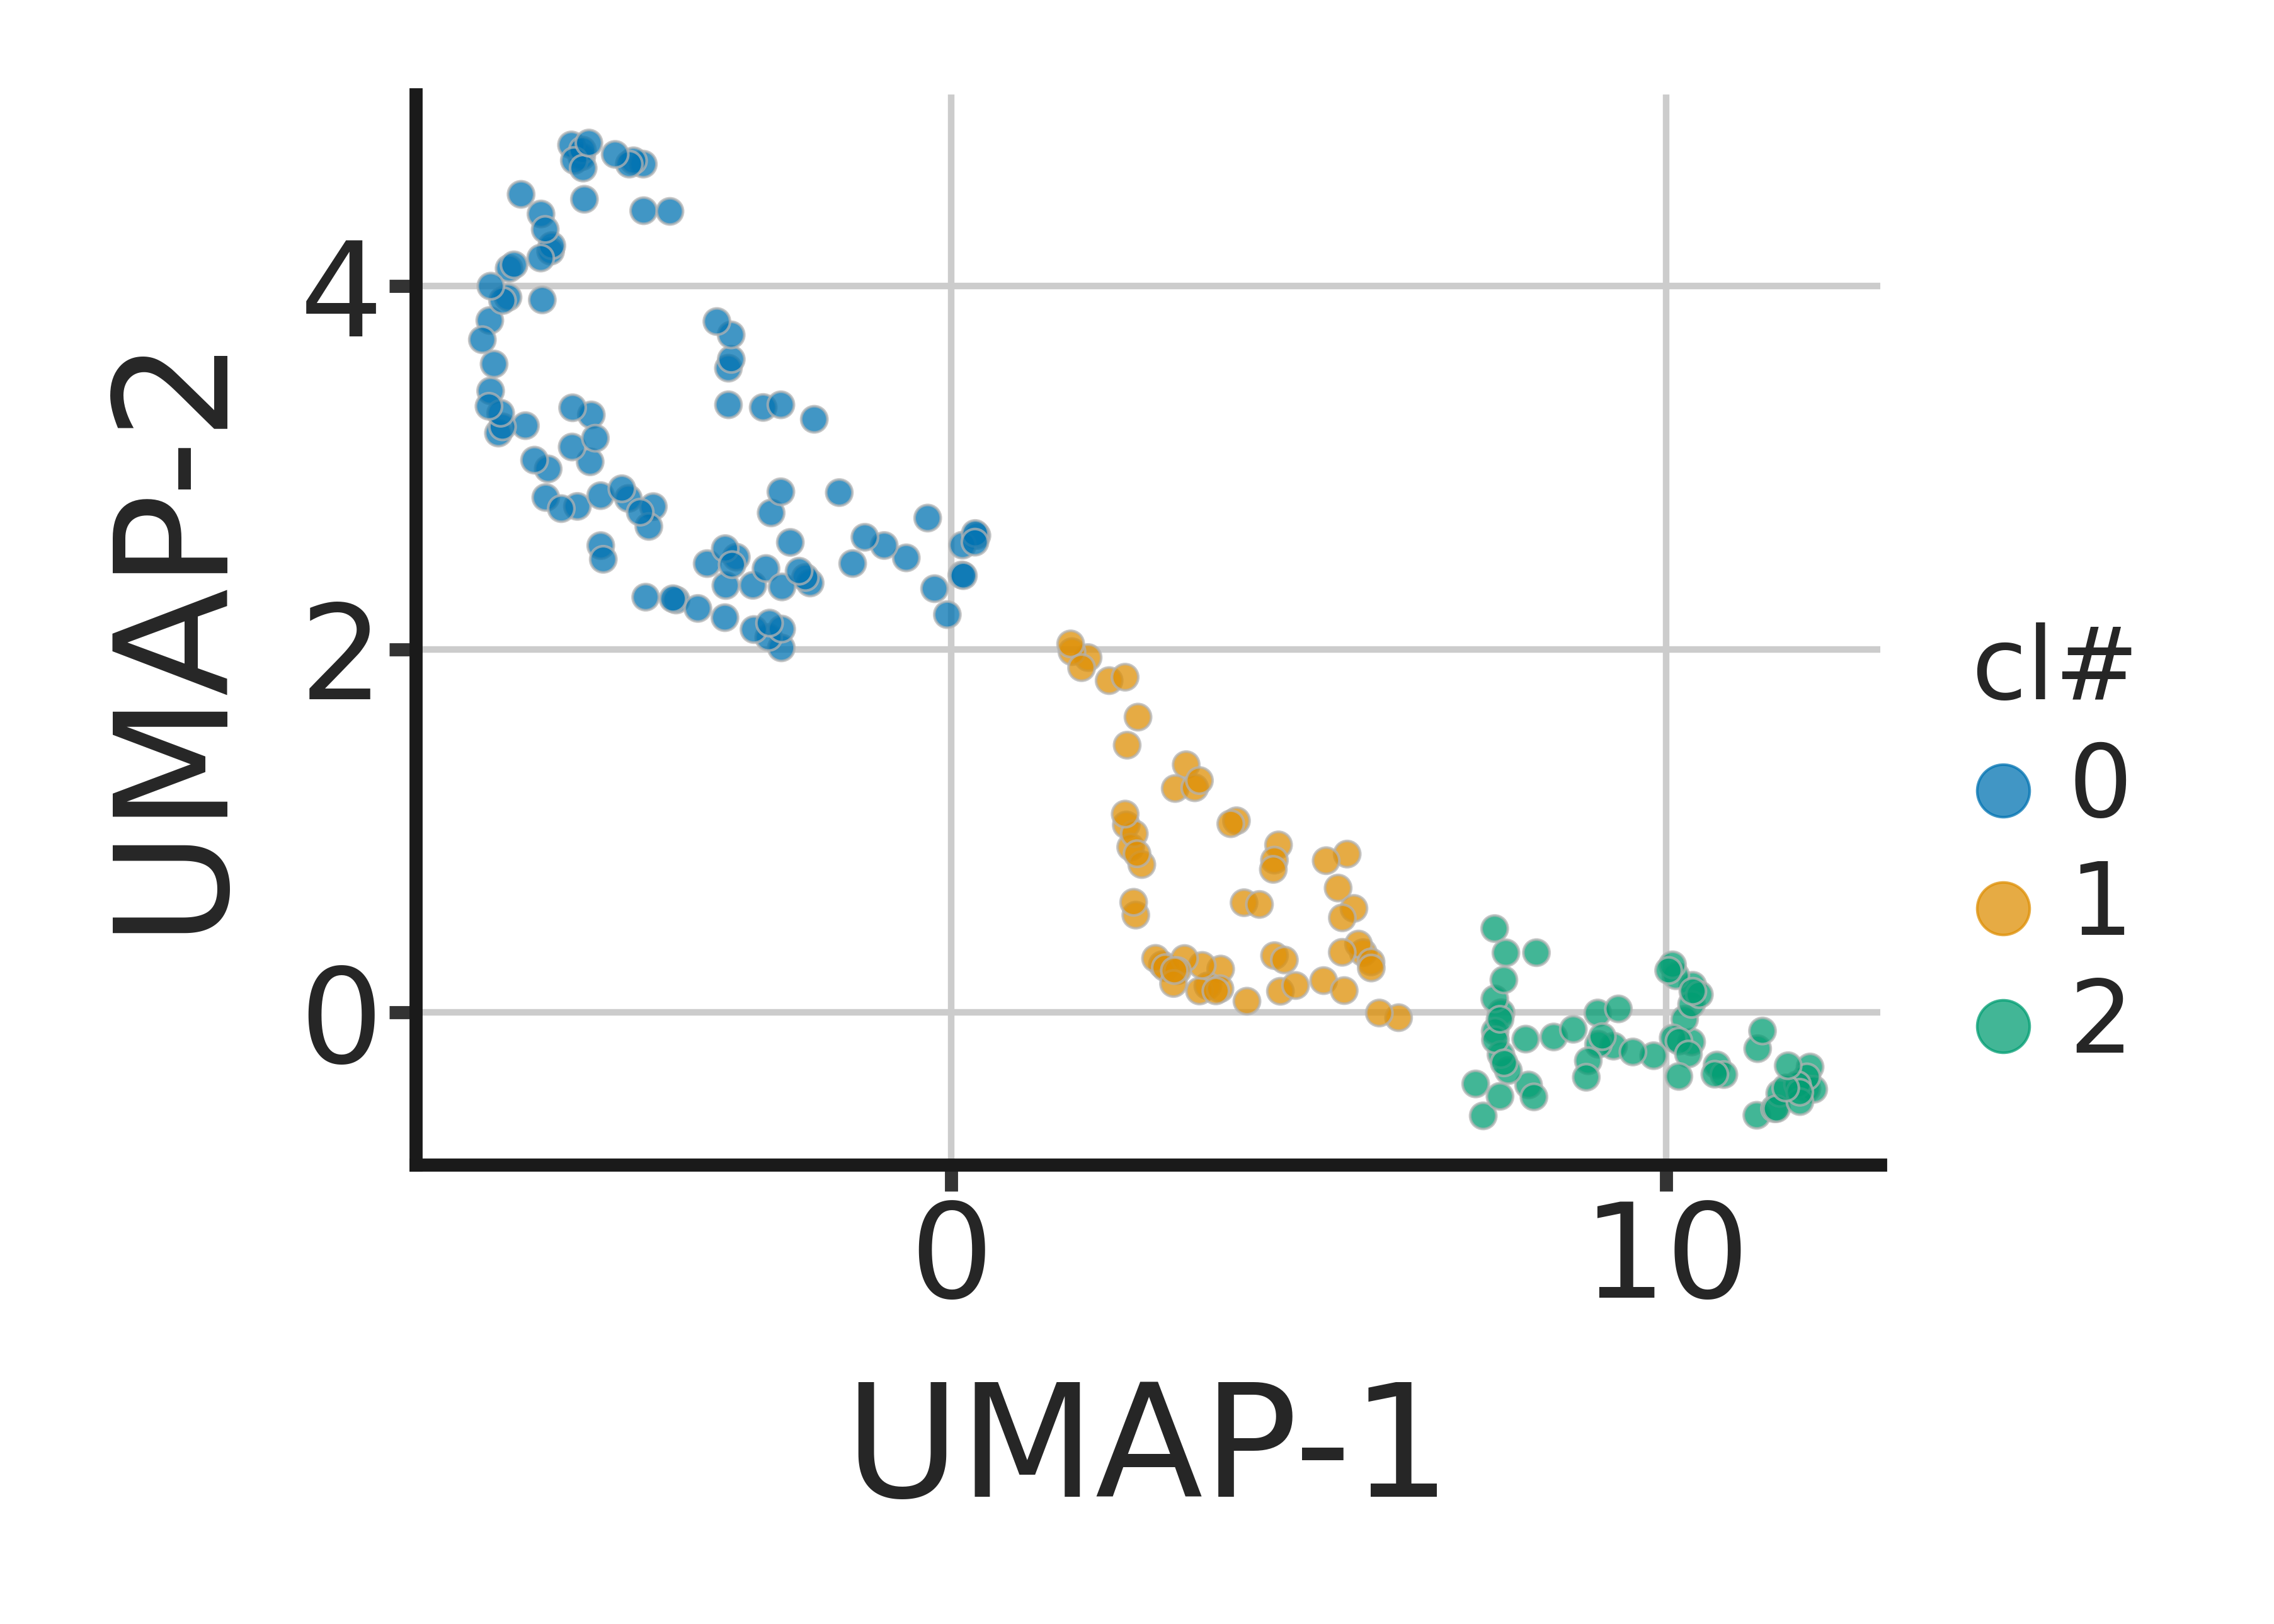

In [30]:
_ = f.plot_umap_clusters(save_flag=True, save_format='svg')

In [21]:
cluster_table.Cluster.value_counts()

NameError: name 'cluster_table' is not defined

## OF Cluster meaning

In [97]:
of_score_names

['OF-agg_sdp-map_r',
 'OF-agg_sdp-r2',
 'OF-hd-agg_sdp_coef',
 'OF-hd-coef',
 'OF-hd-map_r',
 'OF-hd-r2',
 'OF-pos-agg_sdp_coef',
 'OF-pos-coef',
 'OF-pos-map_r',
 'OF-pos-r2',
 'OF-speed-agg_sdp_coef',
 'OF-speed-coef',
 'OF-speed-map_r',
 'OF-speed-r2',
 'OF-metric_score_border',
 'OF-metric_score_grid',
 'OF-metric_score_hd',
 'OF-metric_score_speed',
 'OF-metric_score_pos']

[((0, 'hd'), (0, 'sp')), ((1, 'hd'), (1, 'sp')), ((2, 'hd'), (2, 'sp'))] [1.1601478747002833e-33, 2.3146029810679284e-20, 5.30611444628077e-21]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_sp vs. 1_hd: Custom statistical test, P_val:2.315e-20
0_sp vs. 0_hd: Custom statistical test, P_val:1.160e-33
2_sp vs. 2_hd: Custom statistical test, P_val:5.306e-21


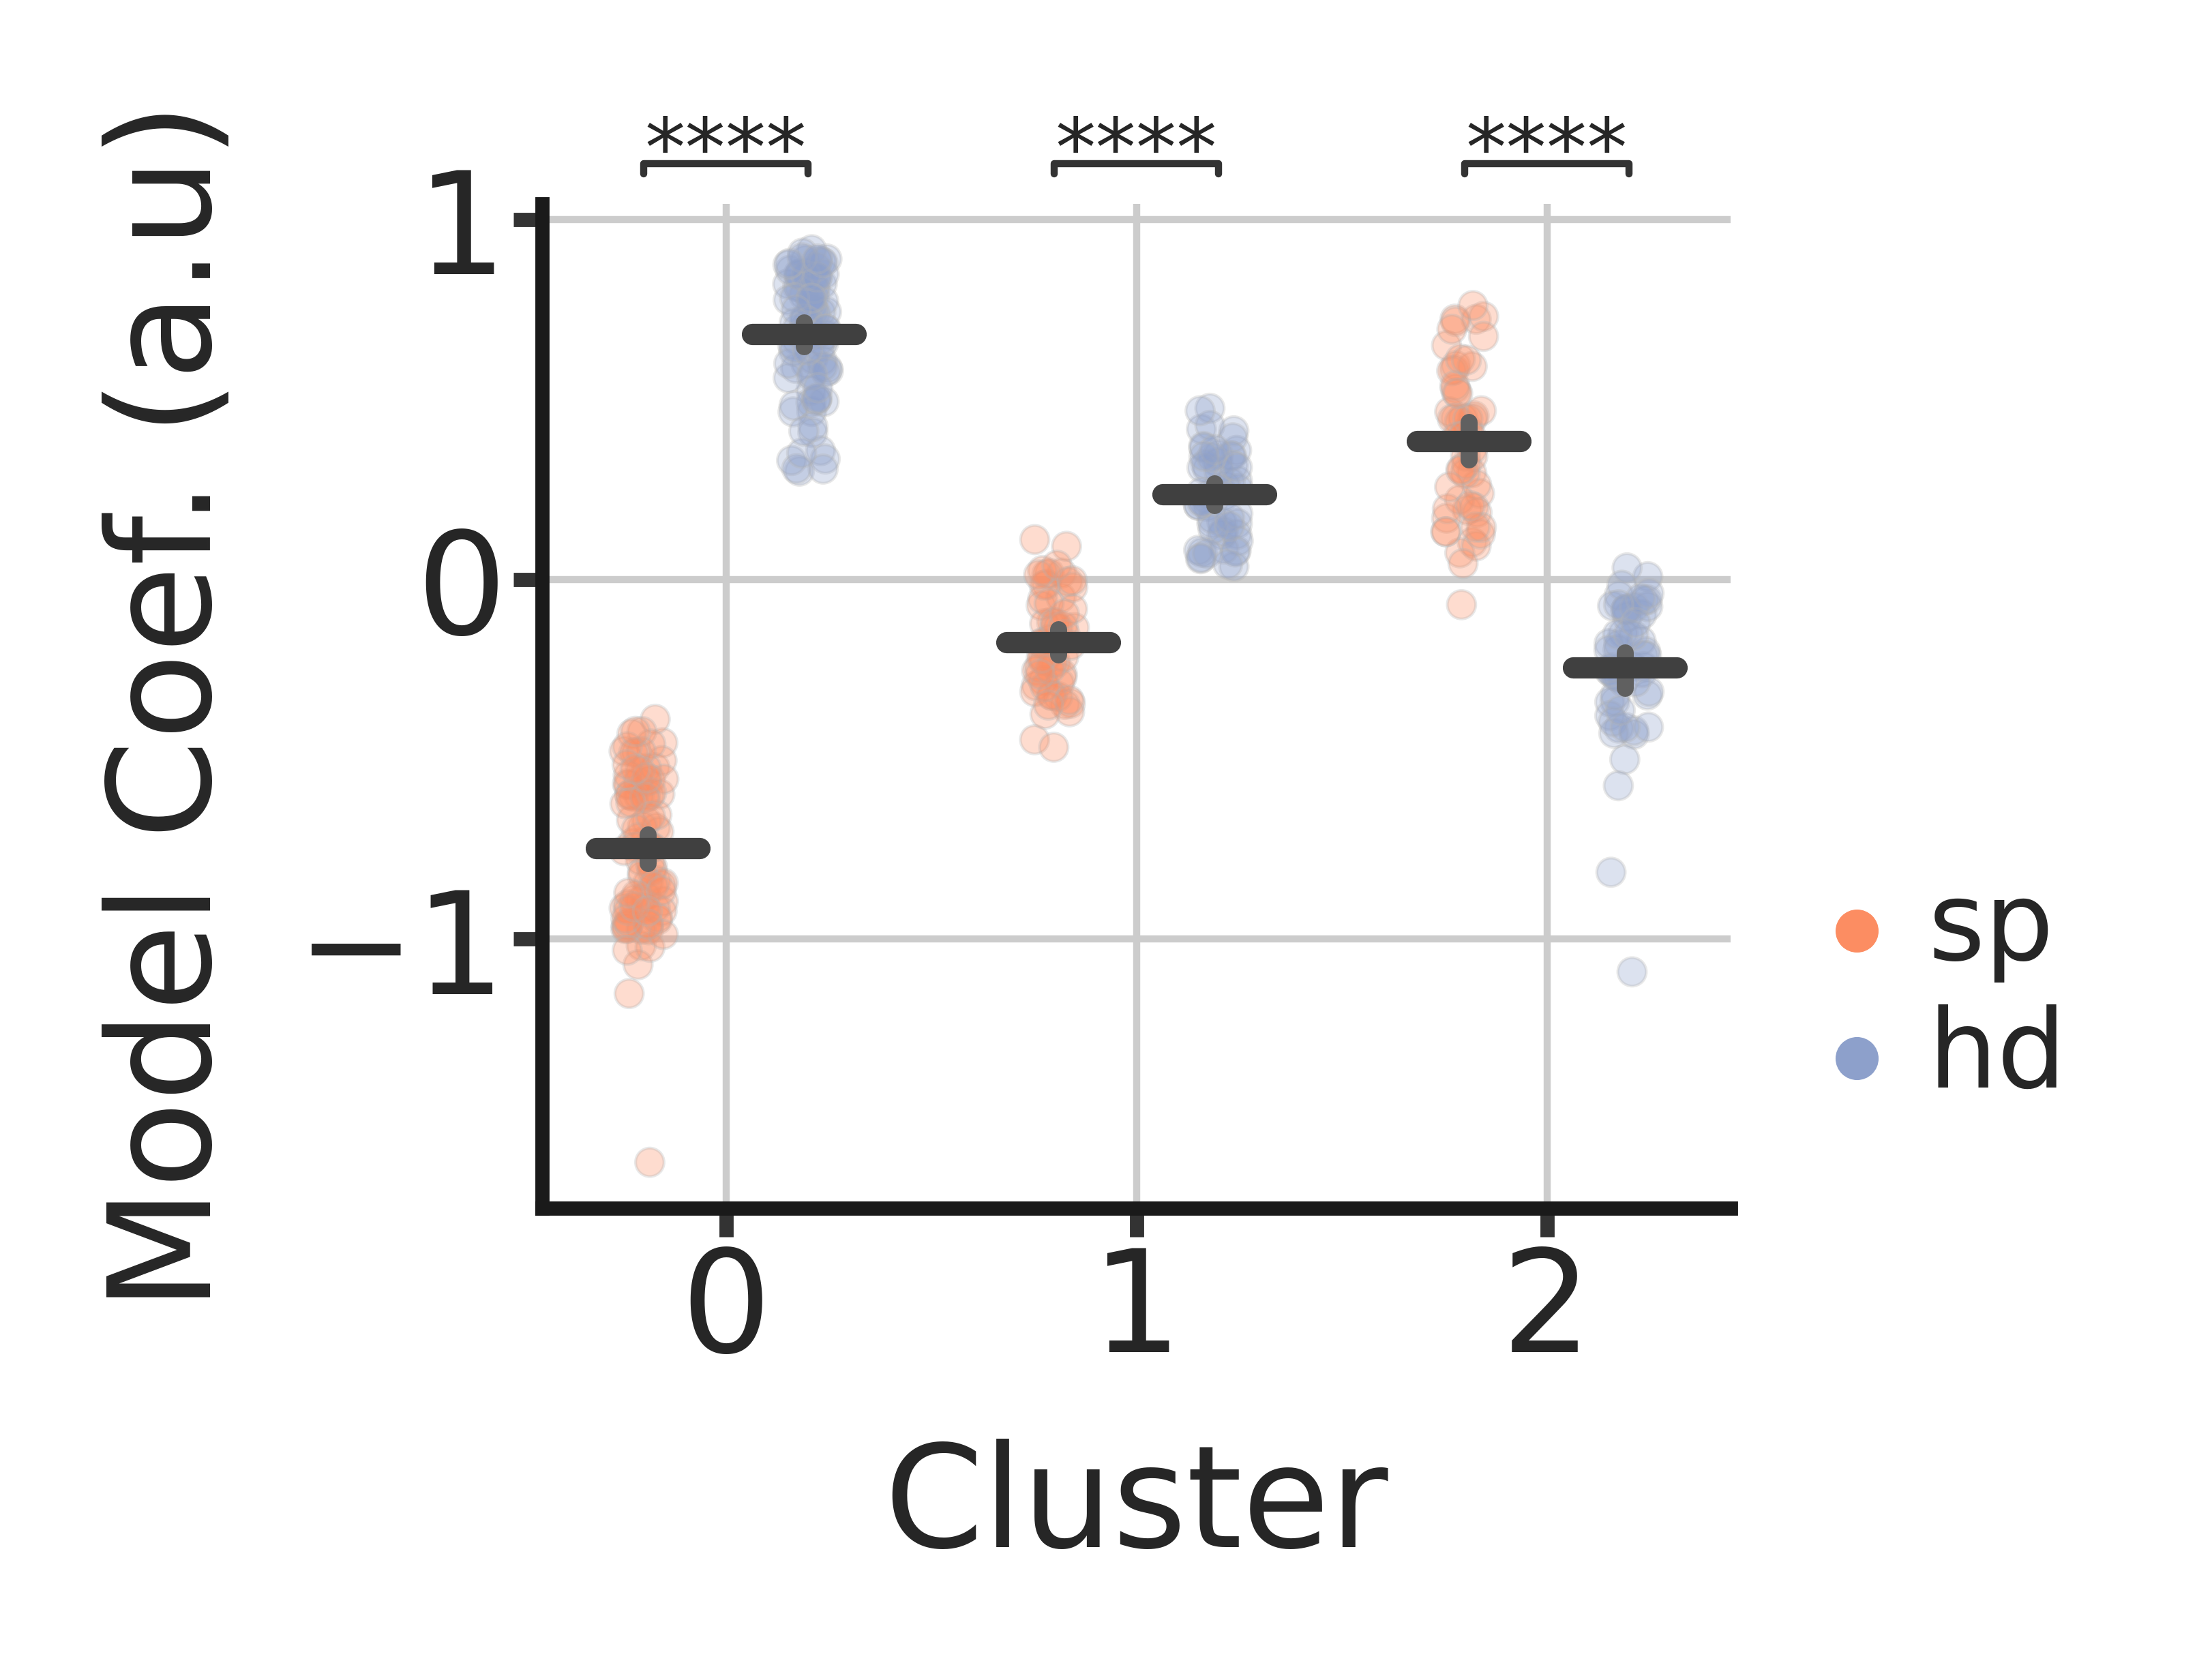

In [29]:
pf  = reload(pf)
f = pf.CrossTaskFigures()
_,ax = f.plot_scores_by_cluster(score_group='of_model_np', figsize=(1.5,1.3))
#f.plot_scores_by_cluster(score_group='of_model_np')

[(('pos', 1), ('pos', 0)), (('pos', 2), ('pos', 0)), (('pos', 2), ('pos', 1)), (('sp', 1), ('sp', 0)), (('sp', 2), ('sp', 0)), (('sp', 2), ('sp', 1)), (('hd', 1), ('hd', 0)), (('hd', 2), ('hd', 0)), (('hd', 2), ('hd', 1))] [8.927652773440279e-09, 4.746750288357727e-15, 7.259921919929337e-05, 1.6955650541273308e-25, 6.205446460614204e-26, 1.574248570155324e-20, 1.505151061061809e-23, 6.205446460614204e-26, 5.2135996866661335e-21]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sp_1 vs. sp_2: Custom statistical test, P_val:1.574e-20
hd_0 vs. hd_1: Custom statistical test, P_val:1.505e-23
hd_1 vs. hd_2: Custom statistical test, P_val:5.214e-21
pos_0 vs. pos_1: Custom statistical test, P_val:8.928e-09
pos_1 vs. pos_2: Custom statistical test, P_val:7.260e-05
sp_0 vs. sp_1: Custom statistical test, P_val:1.696e-25
hd_0 vs. hd_2: Custom statistical test, P_val:

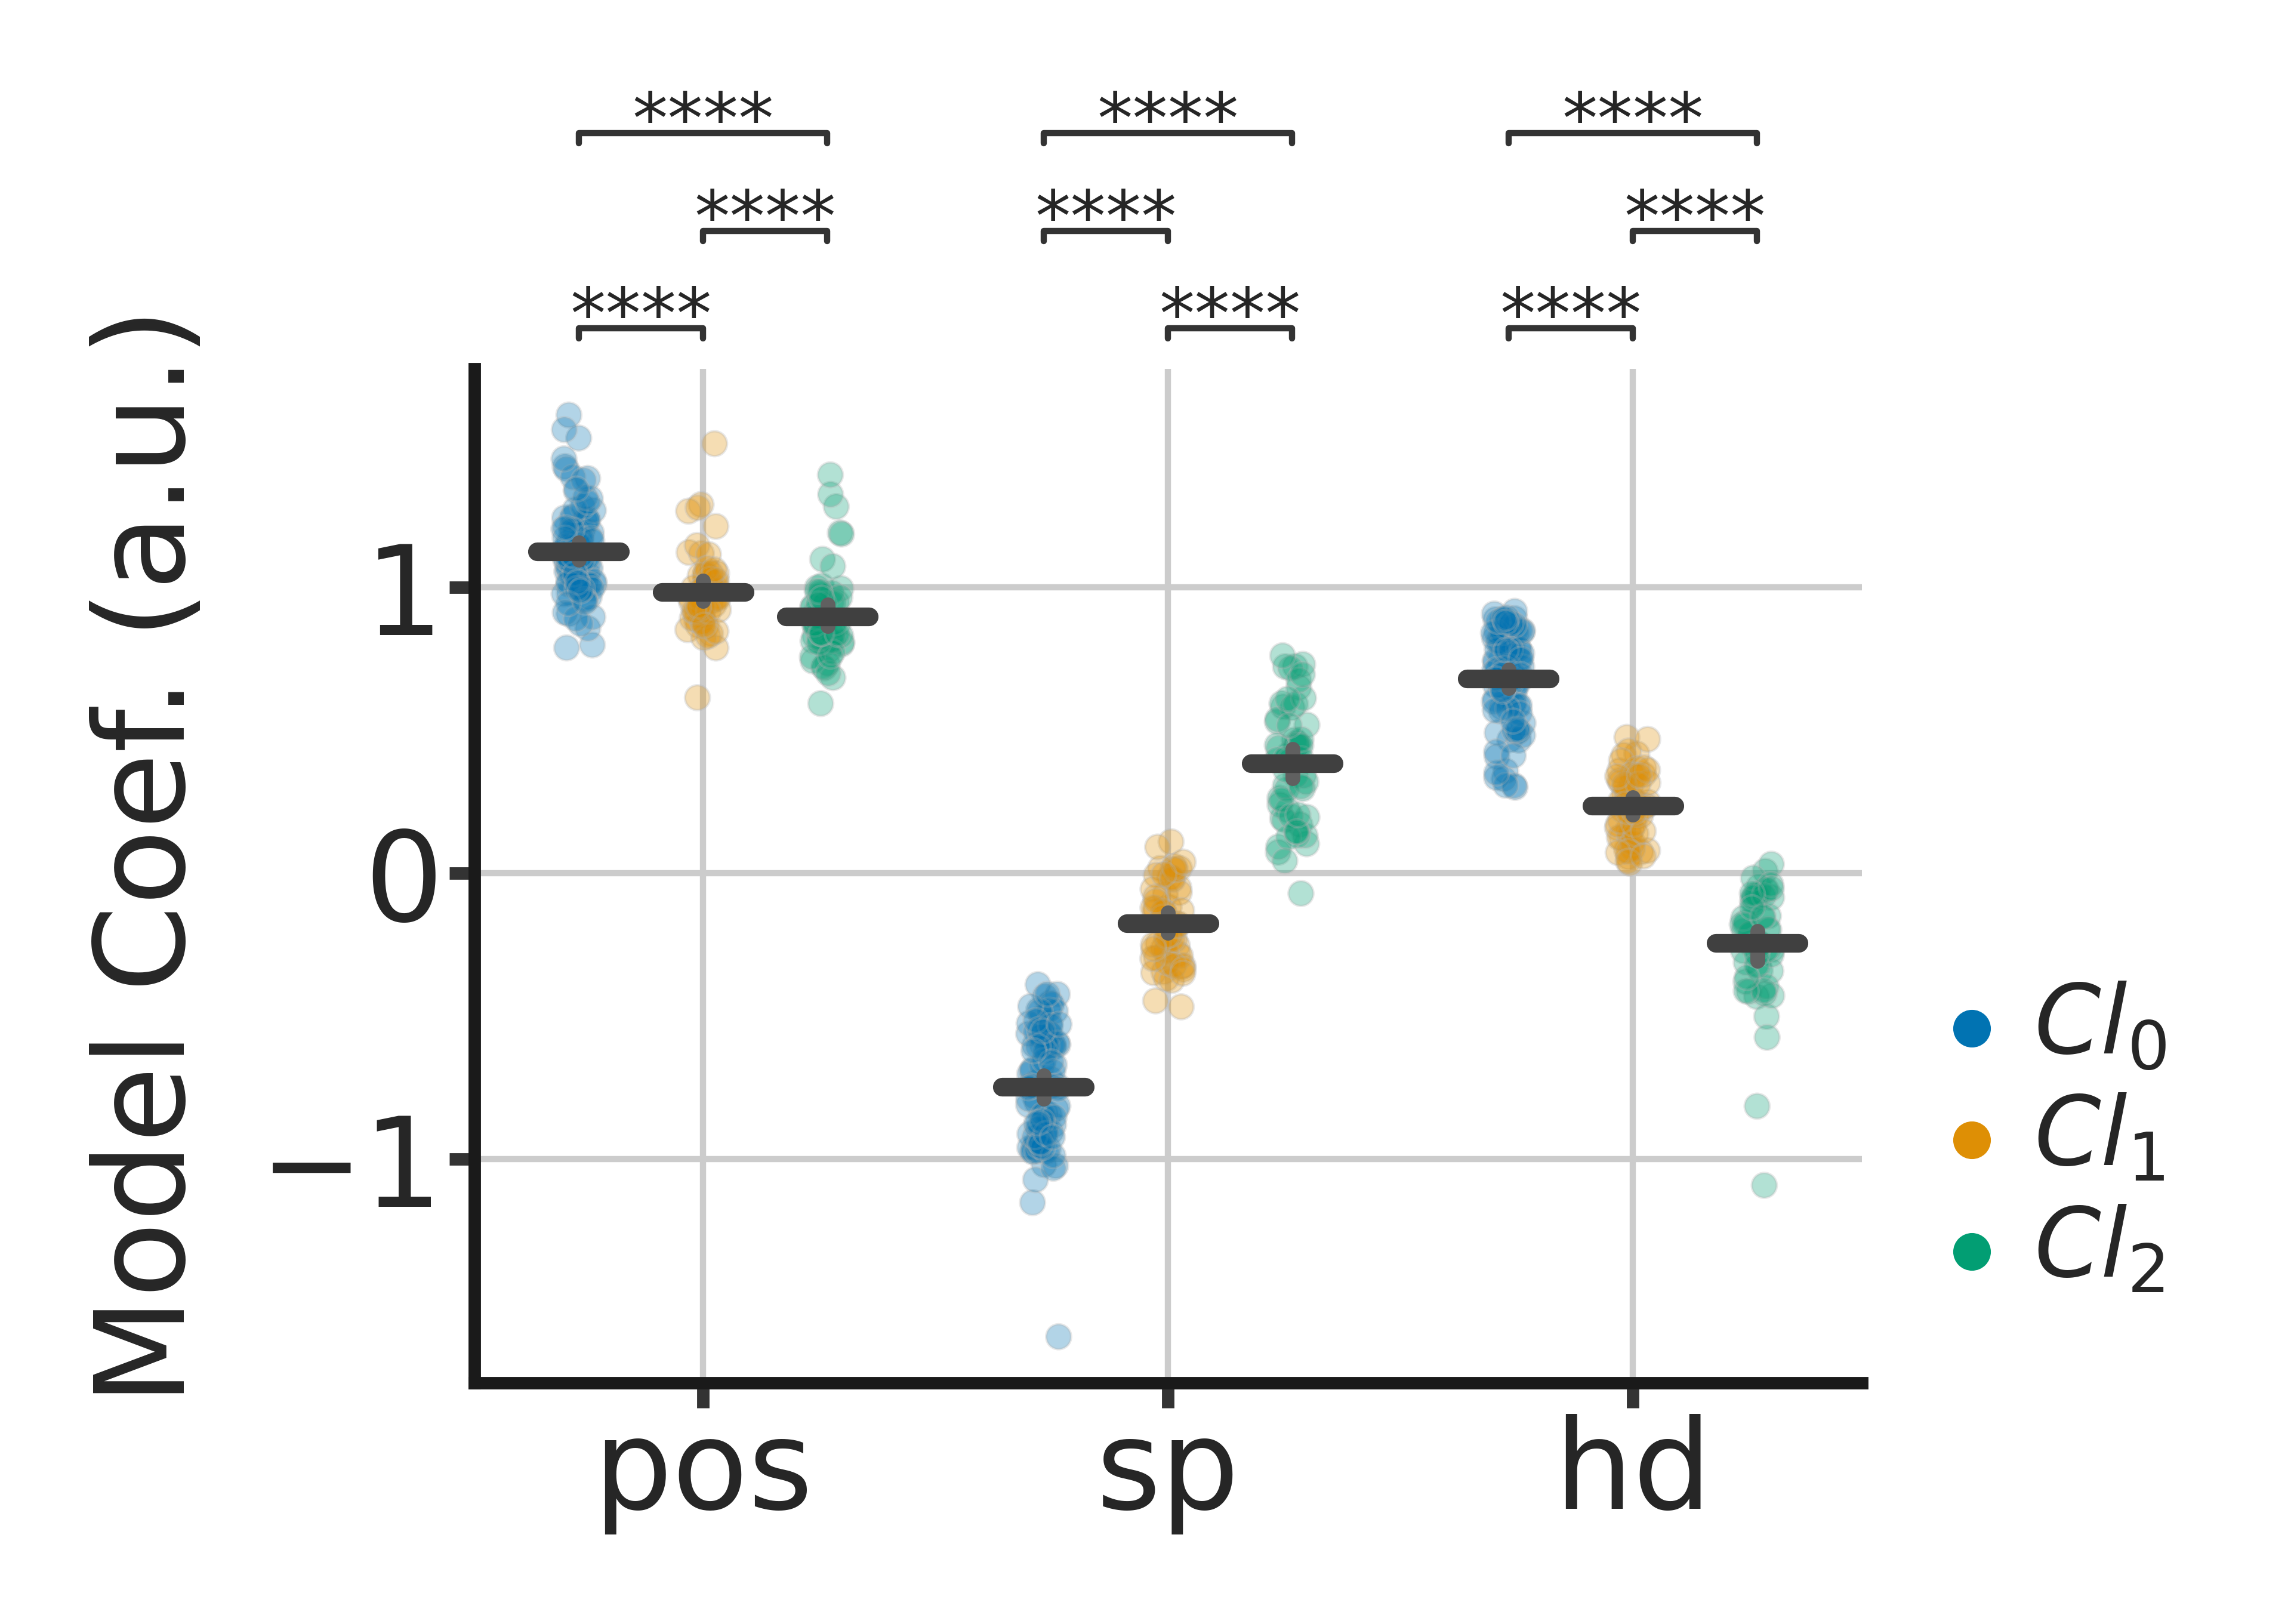

In [31]:
pf  = reload(pf)
f = pf.CrossTaskFigures()
_, ax = f.plot_scores_by_group(score_group='of_model')

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/seaborn/axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.8 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.8 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/seaborn/distributions.py:1699: 

(<Figure size 4500x4500 with 3 Axes>,
 [<AxesSubplot:xlabel='sp', ylabel='hd'>,
  <AxesSubplot:xlabel='sp', ylabel='Density'>,
  <AxesSubplot:xlabel='Density', ylabel='hd'>])

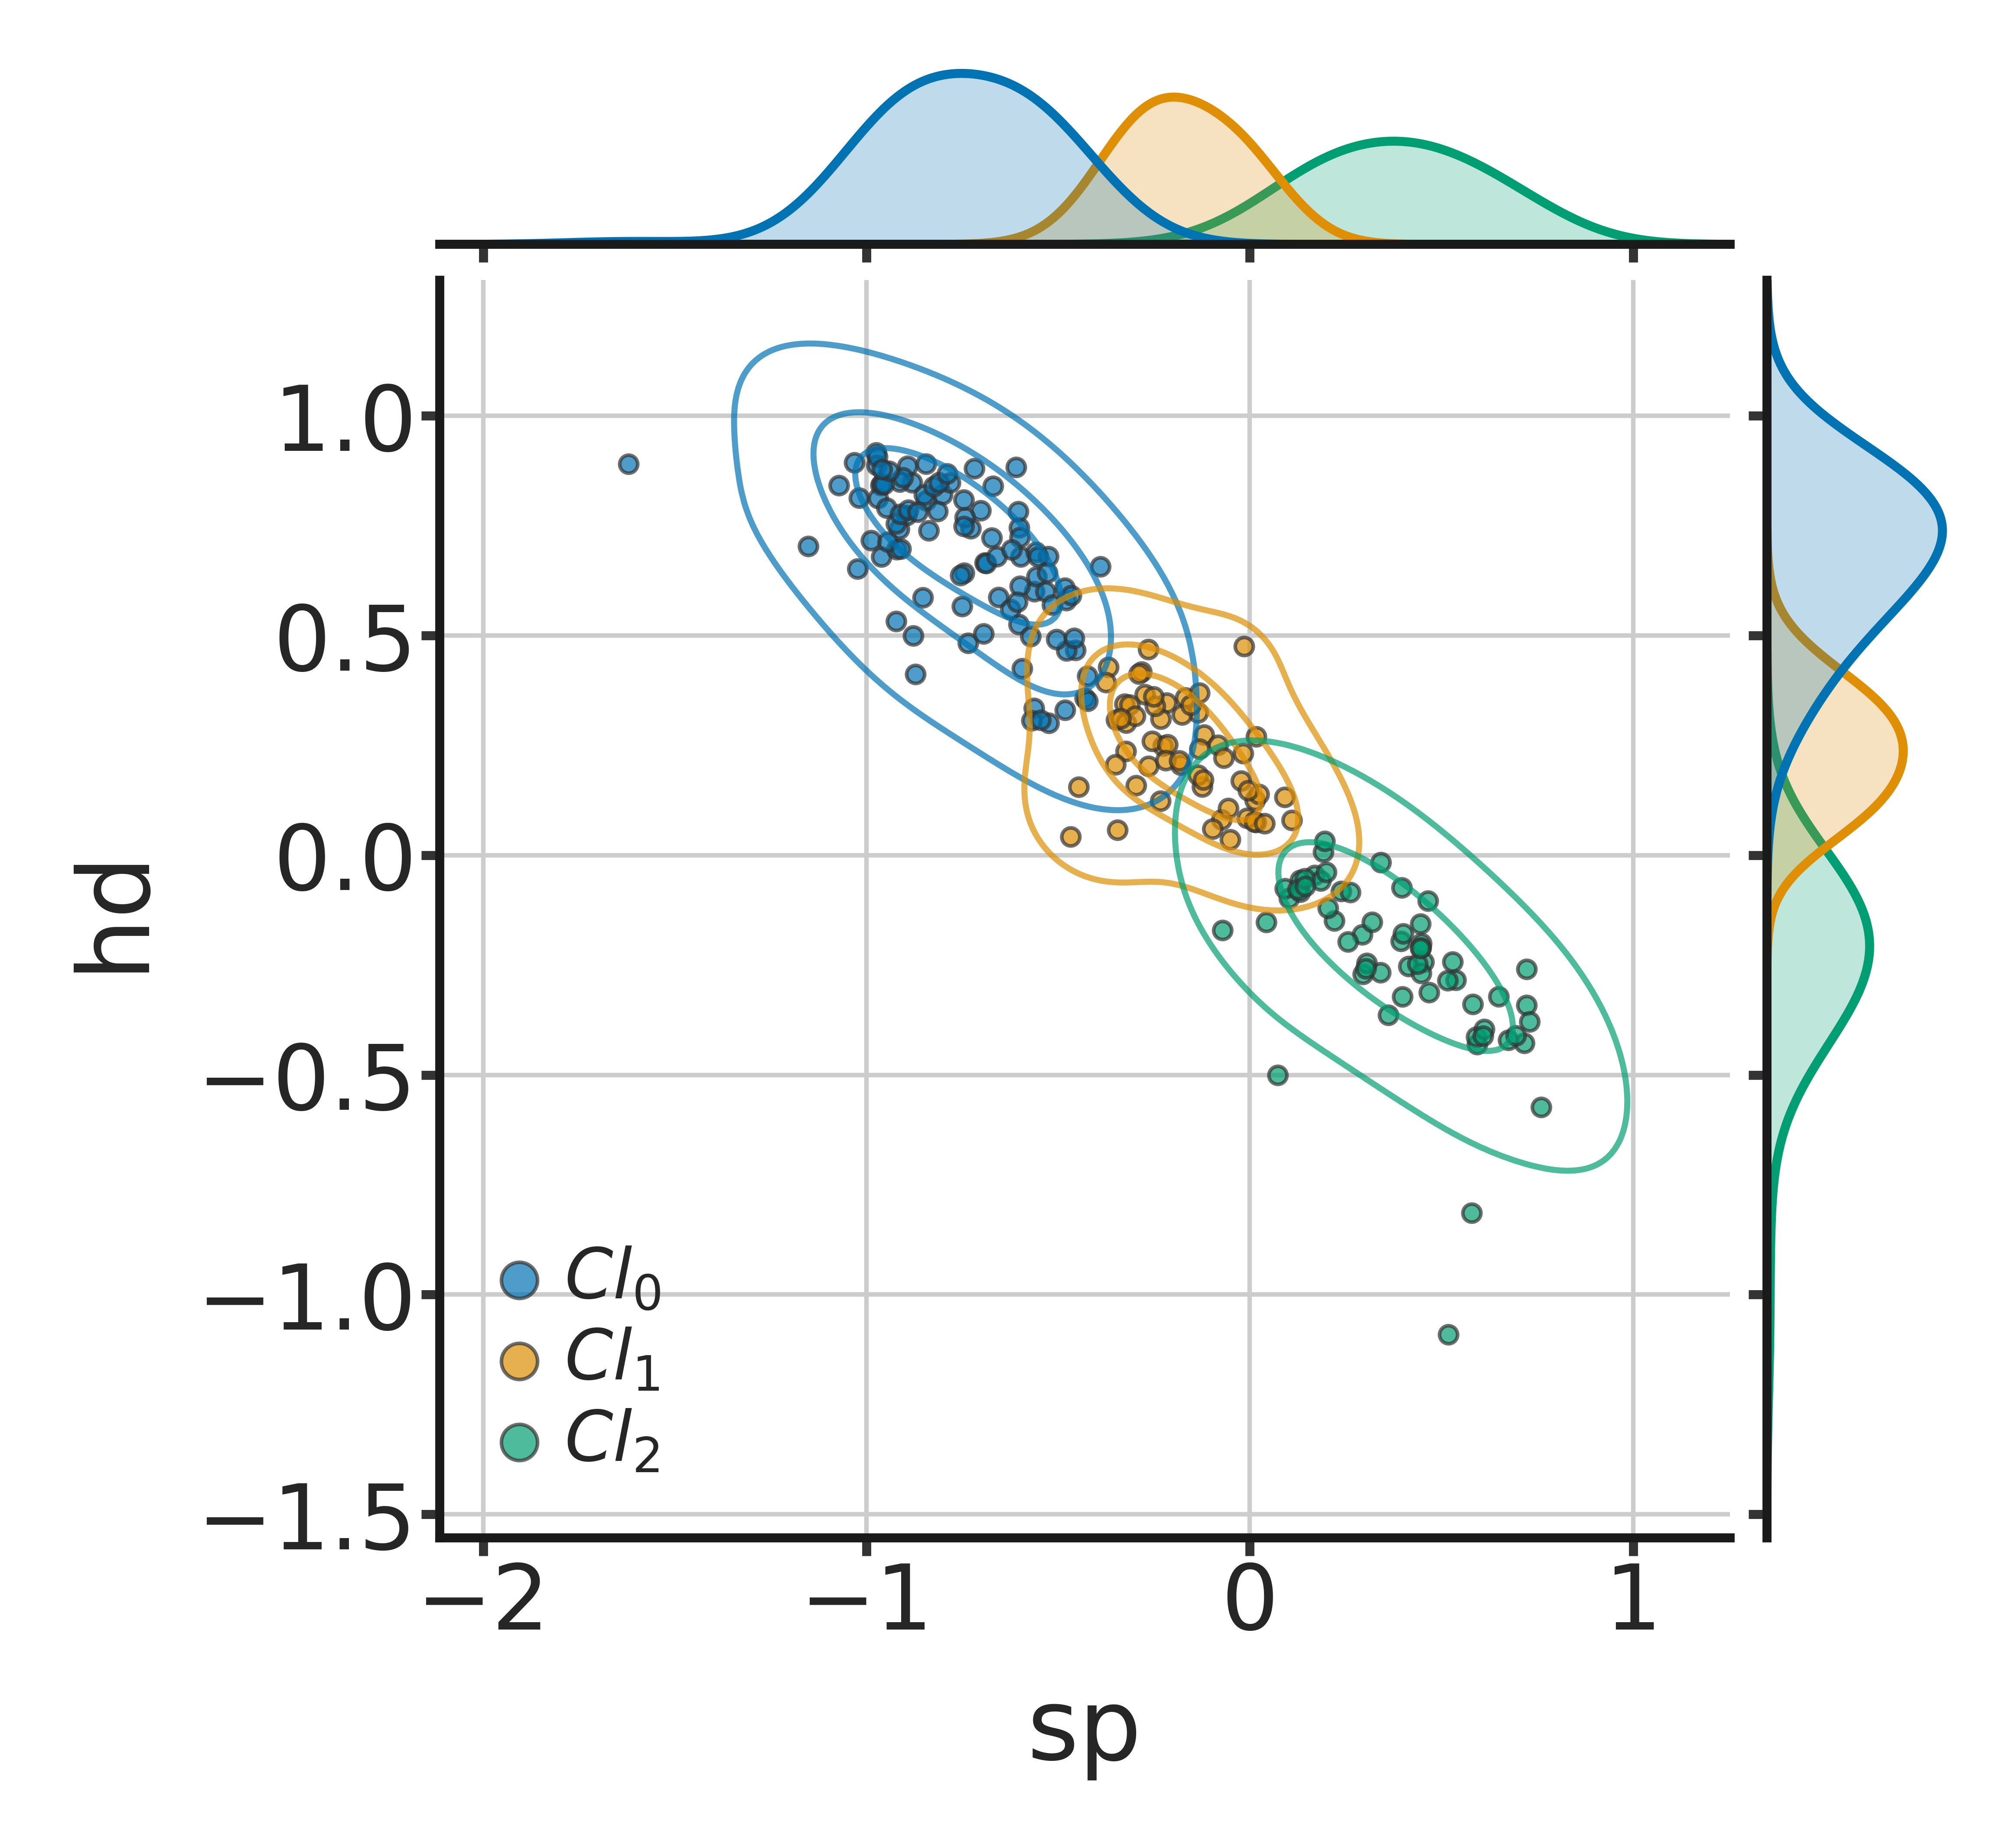

In [33]:
pf = reload(pf)
f = pf.CrossTaskFigures()
f.scatter_scores_by_cluster(score_group='of_model_np')

In [194]:
cvars = ['speed', 'hd', 'pos']
select_columns = [f"OF-{s}-agg_sdp_coef" for s in cvars]

table = combined_scores_table2[['subject','match_cl_id']+select_columns].copy()
table['Cluster'] = cluster_table.Cluster.astype(pd.api.types.CategoricalDtype())
table['umap1'] = cluster_table['UMAP-1']

vc={'match_cl_id':'0+C(match_cl_id)'}

table = table.dropna()
#table = table.rename(columns={'OF-speed-agg_sdp_coef':'sp', 'OF-hd-agg_sdp_coef':'hd', 'p'})
table=table.rename(columns={b:a for a,b in zip(cvars,select_columns) })
table = table.melt(id_vars=['Cluster', 'subject','match_cl_id','umap1'], value_name='score', var_name='of_coef')
table.head()

model_full = smf.mixedlm(formula="score ~ -1 + of_coef*Cluster",
                  groups='subject', re_formula='1', vc_formula=vc, data=table).fit(reml=False)
model_no_inter = smf.mixedlm(formula="score ~ -1 + of_coef+Cluster",
                  groups='subject', re_formula='1', vc_formula=vc, data=table).fit(reml=False)

print(model_full.summary())
print()
print(model_full.wald_test_terms())
print()
print(model_no_inter.summary())

LRT = 2*(model_full.llf-model_no_inter.llf)
chi2_p = stats.chi2.sf(LRT,4)
print(f"LRT = {LRT:0.2f}; Chi2_p={chi2_p}")

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home/alexgonzalez/anaconda3/envs/t

                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      score    
No. Observations:        651          Method:                  ML       
No. Groups:              3            Scale:                   0.1409   
Min. group size:         114          Log-Likelihood:          -293.7751
Max. group size:         297          Converged:               Yes      
Mean group size:         217.0                                          
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
of_coef[hd]                    0.541    0.212  2.549 0.011  0.125  0.958
of_coef[pos]                   1.056    0.212  4.972 0.000  0.640  1.472
of_coef[speed]                -0.544    0.212 -2.561 0.010 -0.960 -0.128
Cluster[T.1]                  -0.265    0.064 -4.129 0.000 -0.391 -0.

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 6.064986
  warnings.warn(msg, ConvergenceWarning)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/alexgonza

In [192]:
model_full = smf.mixedlm(formula="score ~ -1 + of_coef*umap1",
                  groups='subject', re_formula='1', vc_formula=vc, data=table).fit(reml=False)
model_no_inter = smf.mixedlm(formula="score ~ -1 + of_coef+umap1",
                  groups='subject', re_formula='1', vc_formula=vc, data=table).fit(reml=False)

print(model_full.summary())
print()
print(model_full.wald_test_terms())
print()
print(model_no_inter.summary())

LRT = 2*(model_full.llf-model_no_inter.llf)
chi2_p = stats.chi2.sf(LRT,4)
print(f"LRT = {LRT:0.2f}; Chi2_p={chi2_p}")

PatsyError: Error evaluating factor: NameError: name 'of_coef' is not defined
    score ~ -1 + of_coef*umap1
                 ^^^^^^^

In [36]:
table2 = table.copy()
for su in info.subjects:
    idx = (table2.subject==su)      
    table2.loc[idx,['umap1', 'score']] -= table2.loc[idx,['umap1', 'score']].mean().values

model_full = smf.ols(formula="score ~ 1 + of_coef*Cluster", data=table2).fit()
model_no_inter = smf.ols(formula="score ~ 1 + of_coef+Cluster", data=table2).fit()

print(model_full.summary())
print()
print(model_full.wald_test_terms())
print()
print(model_no_inter.summary())
print(f"LRT = {2*(model_full.llf-model_no_inter.llf):0.2f}")


                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1179.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:44:32   Log-Likelihood:                 240.12
No. Observations:                 651   AIC:                            -462.2
Df Residuals:                     642   BIC:                            -421.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [37]:
cluster_table.Cluster.value_counts()

0    98
2    60
1    59
Name: Cluster, dtype: int64

[((0, 'RW'), (0, 'Cue'))] [0.04145284319579556]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0_Cue vs. 0_RW: Custom statistical test, P_val:4.145e-02


(<Figure size 3000x2250 with 1 Axes>,
 <AxesSubplot:xlabel='Cluster', ylabel='$\\bar{z}_{\\Delta \\tau}$'>)

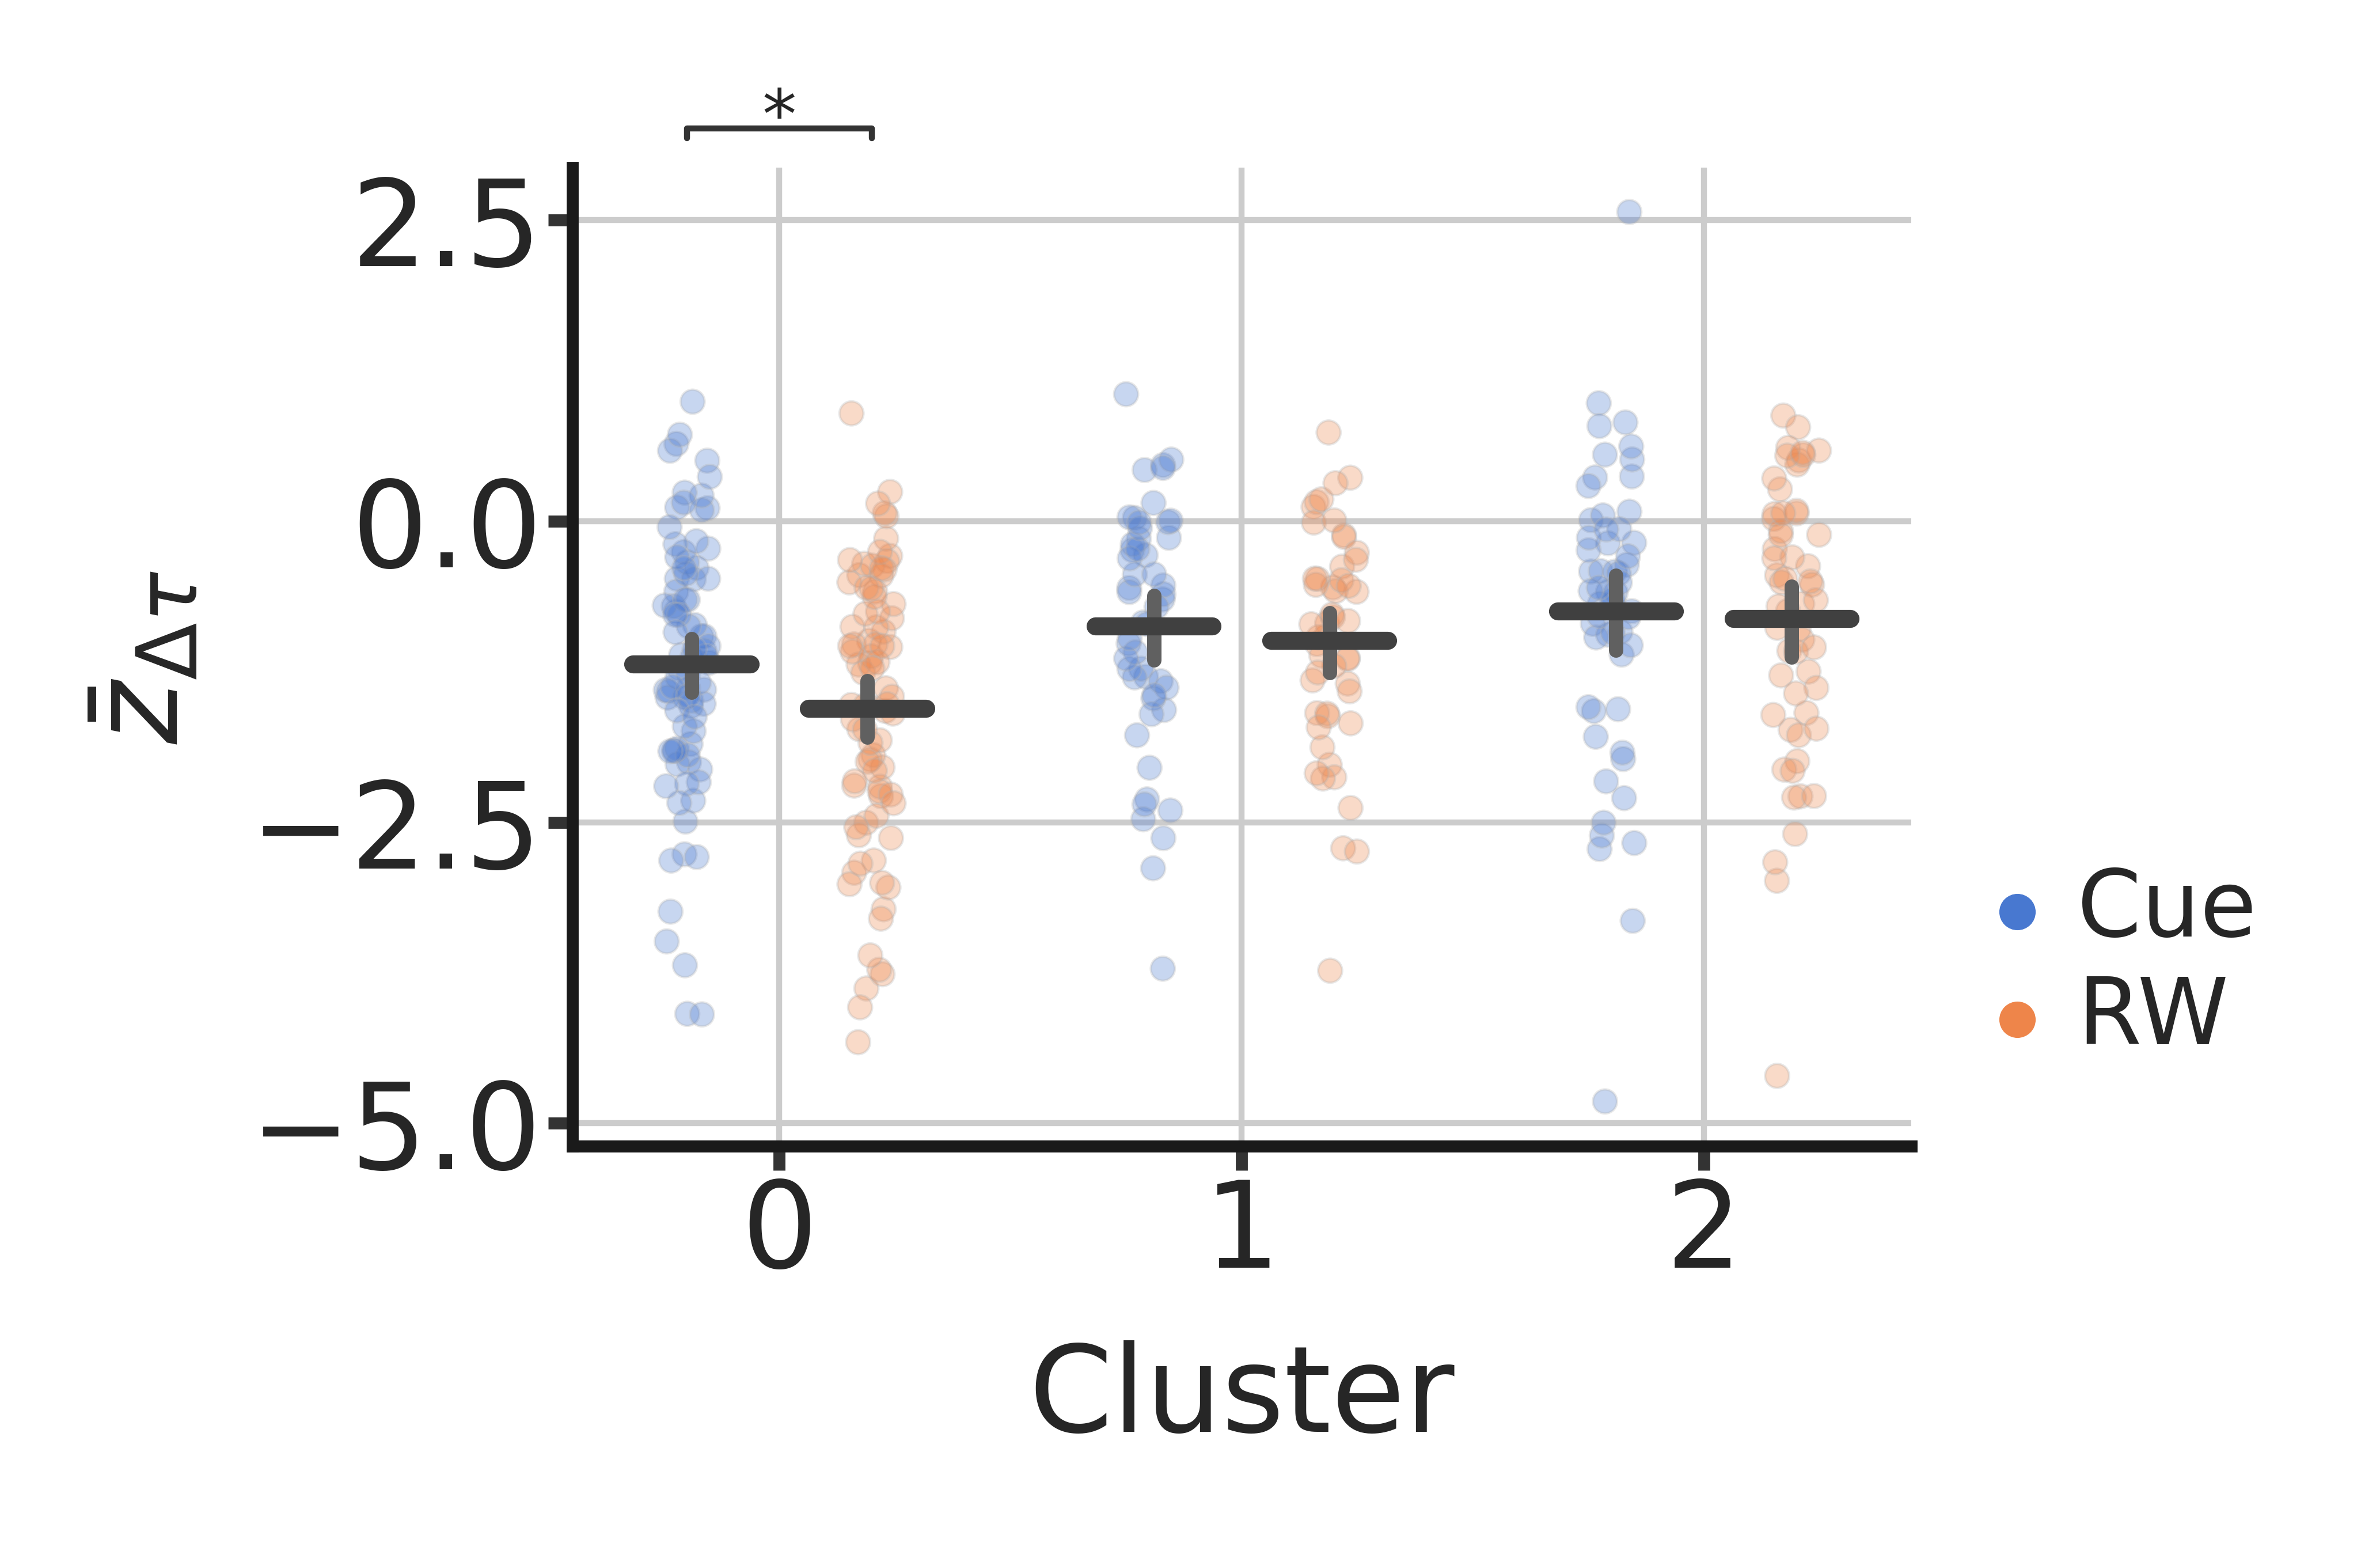

In [38]:
f = pf.CrossTaskFigures()
f.plot_scores_by_cluster(score_group='remap')

[(('Cue', 2), ('Cue', 0)), (('RW', 1), ('RW', 0)), (('RW', 2), ('RW', 0))] [0.009300405039694346, 0.004562743698967271, 0.00014982951219792888]


(<Figure size 3000x2250 with 1 Axes>,
 <AxesSubplot:ylabel='$\\bar{z}_{\\Delta \\tau}$'>)

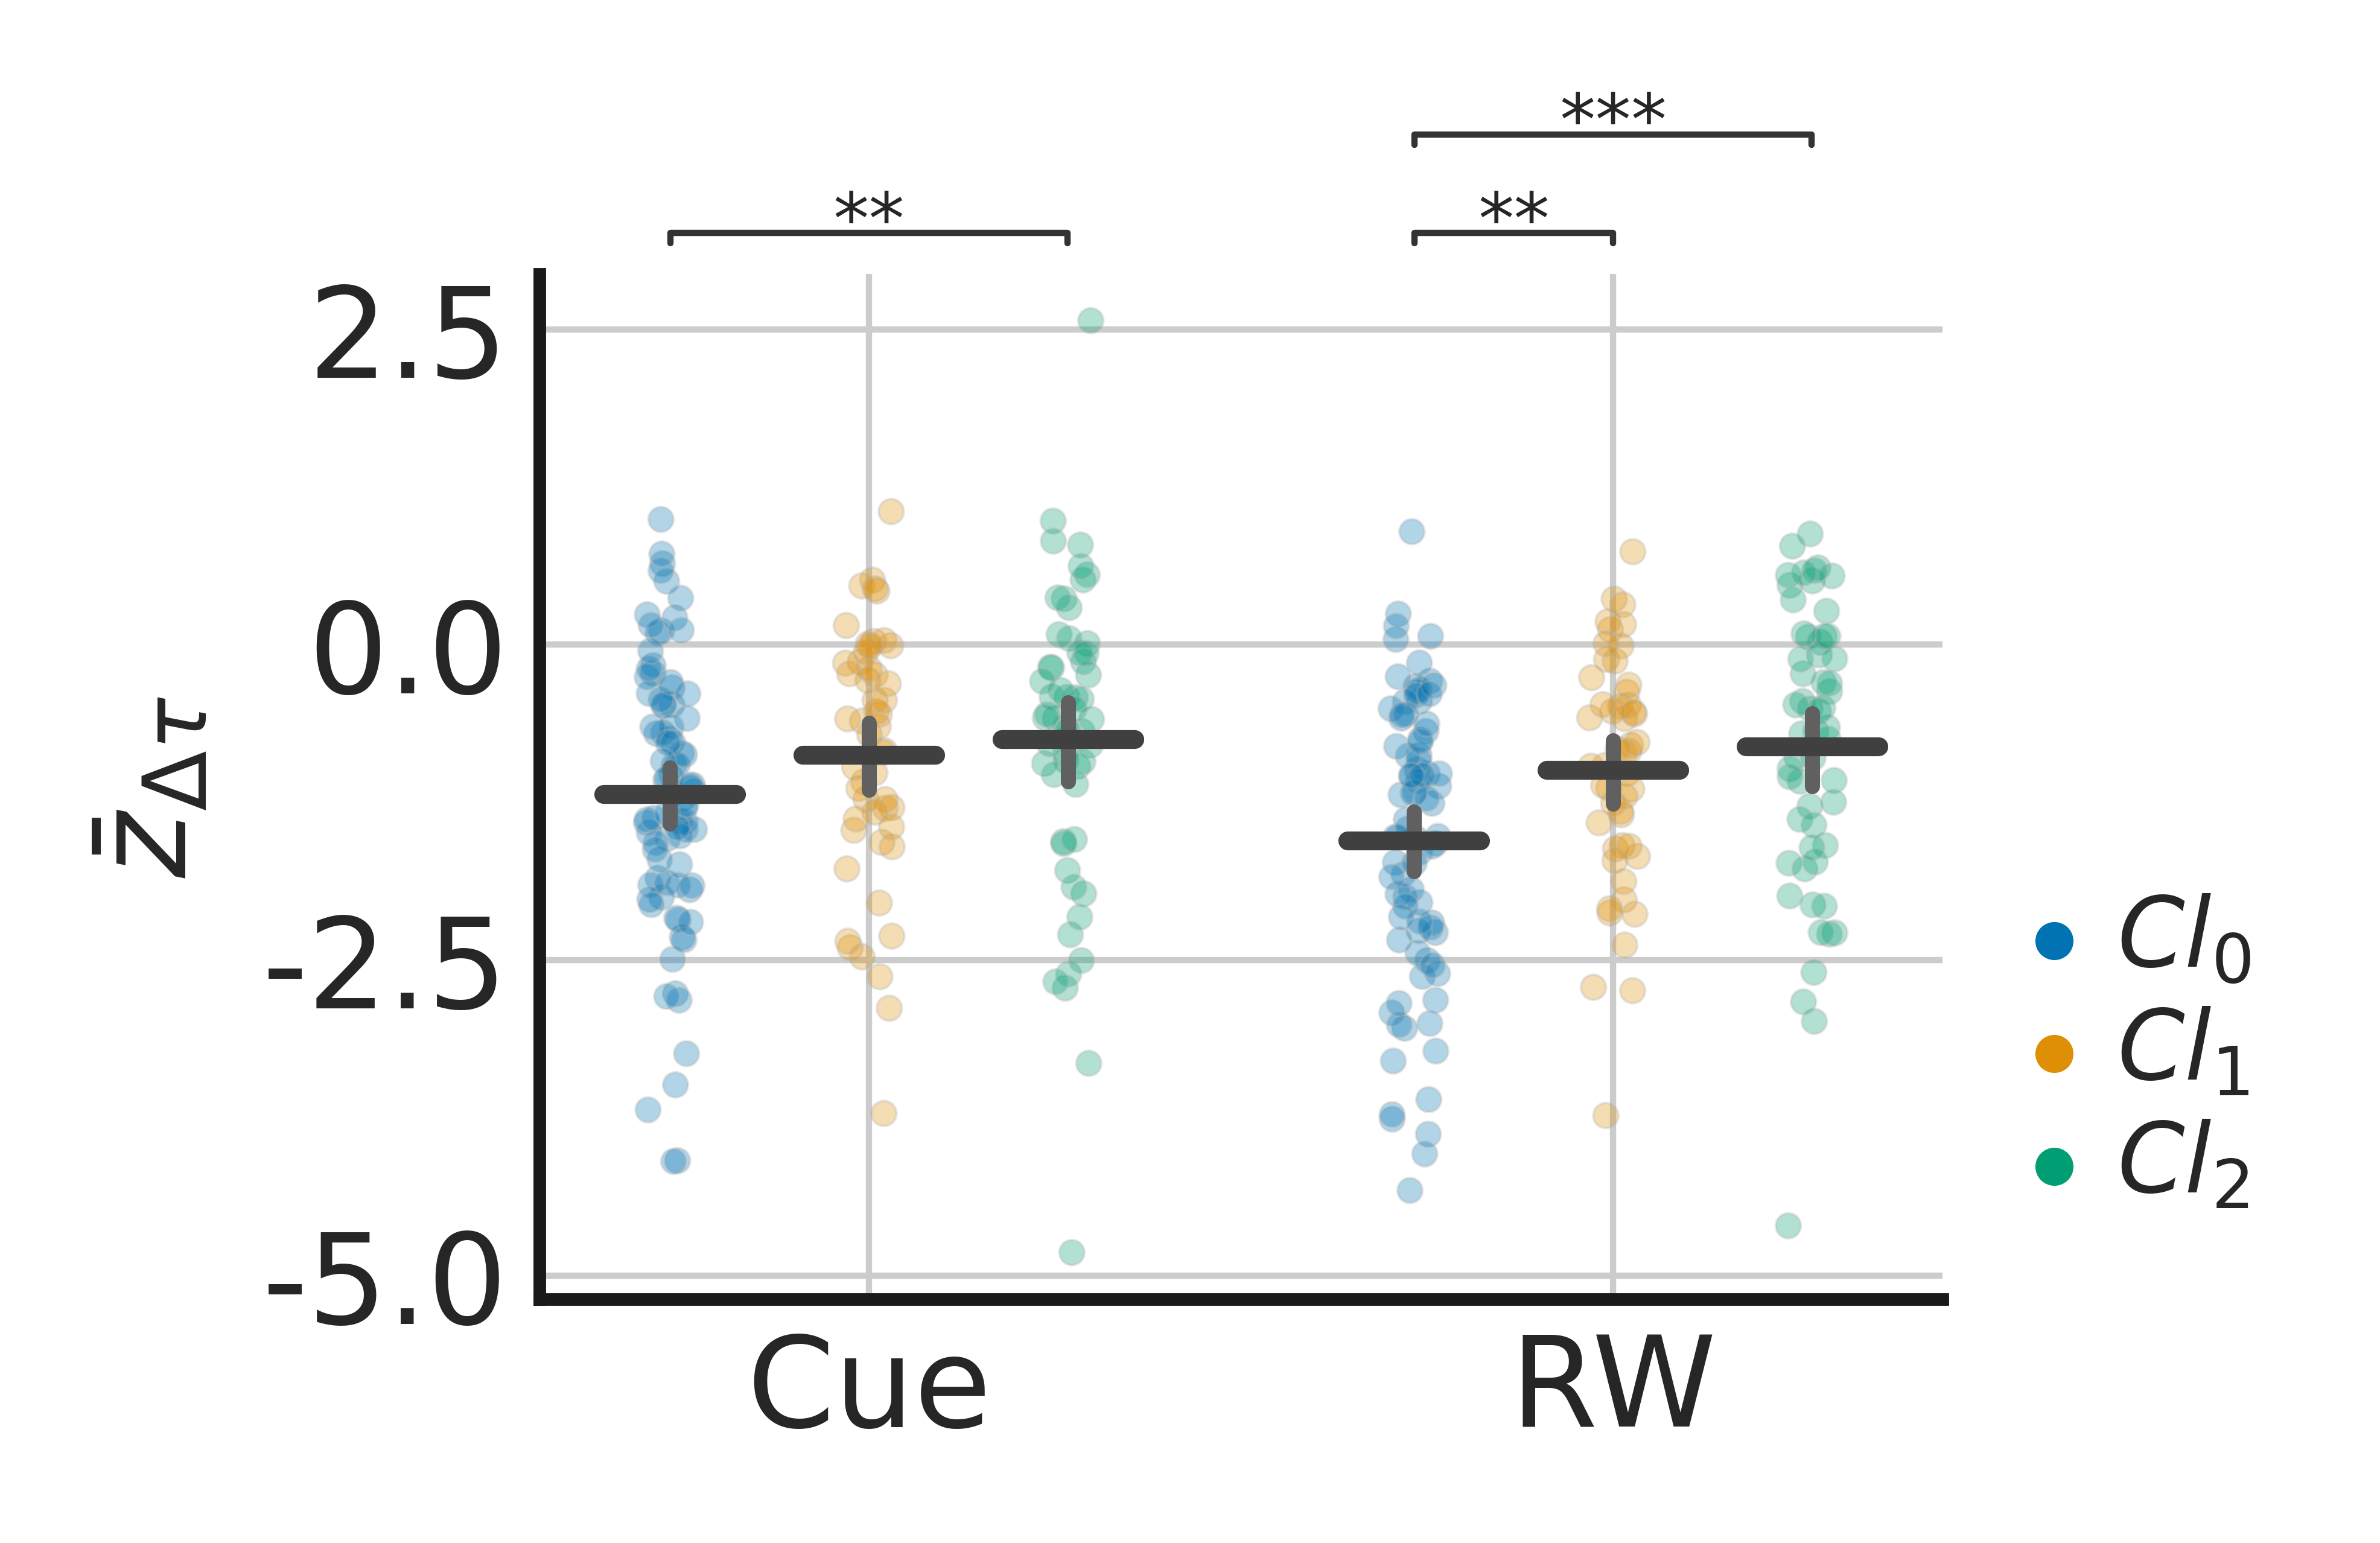

In [33]:
pf = reload(pf)
f = pf.CrossTaskFigures()
f.plot_scores_by_group(score_group='remap')

In [137]:
score_group = 'remap'
cols1, cols2 = f.get_score_table_columns_by_group(score_group)
table = combined_scores_table2[['subject', 'match_cl_id']+cols1].copy()
table['Cluster'] = cluster_table.Cluster.astype(pd.api.types.CategoricalDtype())
table['umap1'] = cluster_table['UMAP-1']

table = table.dropna()
table = table.rename(columns={s1: s2 for s1, s2 in zip(cols1, cols2)})
table = table.melt(id_vars=['Cluster', 'match_cl_id', 'subject', 'umap1'], value_name='score', var_name=score_group)
#table['score'] = -table['score']

table.head()

Cluster  match_cl_id subject      umap1 remap     score
0       1            0      Li   2.951423   Cue -0.477471
1       2            1      Li   9.045257   Cue  0.202963
2       2            1      Li  11.271812   Cue -0.478512
3       0            2      Li  -5.057338   Cue -0.183025
4       0            2      Li  -5.611038   Cue -0.183025

In [191]:
vc={'match_cl_id':'0+C(match_cl_id)'}

mdf = smf.mixedlm(formula="score ~ 1 + remap*Cluster",
                  groups='subject', re_formula='1',vc_formula=vc, data=table).fit(reml=False)
md_no_cluster_inter = smf.mixedlm(formula="score ~ 1+remap+Cluster ",
                  groups='subject', re_formula='1',vc_formula=vc, data=table).fit(reml=False)
md_no_cluster = smf.mixedlm(formula="score ~ 1+remap ",
                  groups='subject', re_formula='1',vc_formula=vc, data=table).fit(reml=False)


print(mdf.summary())
print(mdf.wald_test_terms())
# print(md_no_cluster_inter.summary())
# print(md_no_cluster.summary())


print("Interaction test")
LRT = 2*(mdf.llf-md_no_cluster_inter.llf)
chi2_p = stats.chi2.sf(LRT,2)
print(f"LRT = {LRT:0.2f}; Chi2_p={chi2_p}")

print("Fixed test")
LRT = 2*(md_no_cluster_inter.llf-md_no_cluster.llf)
chi2_p = stats.chi2.sf(LRT,2)
print(f"LRT = {LRT:0.2f}; Chi2_p={chi2_p}")

print("Overall")
LRT = 2*(mdf.llf-md_no_cluster.llf)
chi2_p = stats.chi2.sf(LRT,2)
print(f"LRT = {LRT:0.2f}; Chi2_p={chi2_p}")



               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     score    
No. Observations:     382         Method:                 ML       
No. Groups:           3           Scale:                  0.6092   
Min. group size:      62          Log-Likelihood:         -536.8511
Max. group size:      176         Converged:              Yes      
Mean group size:      127.3                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                -1.122    0.185 -6.064 0.000 -1.485 -0.759
remap[T.RW]              -0.482    0.118 -4.076 0.000 -0.714 -0.250
Cluster[T.1]              0.196    0.192  1.018 0.309 -0.181  0.573
Cluster[T.2]              0.012    0.202  0.058 0.953 -0.384  0.407
remap[T.RW]:Cluster[T.1]  0.150    0.191  0.786 0.432 -0.225  0

In [189]:
smf.mixedlm(formula="score ~ 1+remap ",
                  groups='subject', re_formula='1',vc_formula=vc, data=table).fit().summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:             MixedLM  Dependent Variable:  score    
No. Observations:  382      Method:              REML     
No. Groups:        3        Scale:               0.6244   
Min. group size:   62       Log-Likelihood:      -543.5084
Max. group size:   176      Converged:           Yes      
Mean group size:   127.3                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       -1.060    0.207 -5.116 0.000 -1.466 -0.654
remap[T.RW]     -0.318    0.081 -3.935 0.000 -0.477 -0.160
subject Var      0.102    0.155                           
match_cl_id Var  0.604    0.167                           
==========================================================

"""

<AxesSubplot:>

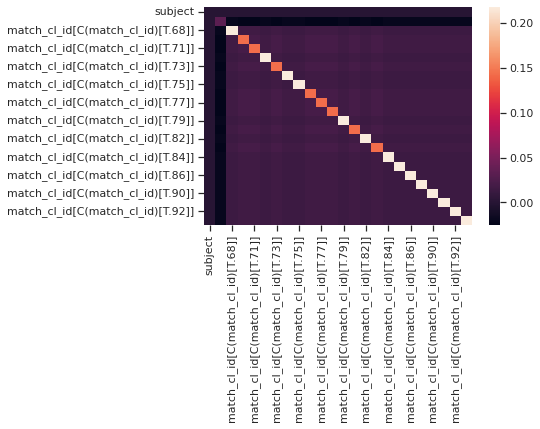

In [167]:
b=mdf.profile_re(0,'vc',dist_low=-0.1, dist_high=0.1)
plt.plot(b[:,0], 2*b[:,1])

ValueError: 0 is not in list

In [174]:
mdf.cov_re

subject
subject  0.000033

In [136]:
stats.chi2.sf(5.55,2)

0.06234947668967344

In [116]:
(mdf.resid**2).sum(), (md_no_cluster.resid**2).sum()

(189.6402712005554, 188.66827048771495)

In [134]:
mdf = smf.mixedlm(formula="score ~ 1 + remap * umap1",
                  groups='subject', re_formula='1',vc_formula=vc, data=table).fit()
md_no_cluster = smf.mixedlm(formula="score ~ 1 + remap+umap1",
                  groups='subject', re_formula='1',vc_formula=vc, data=table).fit()


print(mdf.summary())
print(mdf.wald_test_terms())

print(md_no_cluster.summary())

LRT = 2*(mdf.llf-md_no_cluster.llf)
chi2_p = stats.chi2.sf(LRT,1)
print(f"LRT = {LRT:0.2f}; Chi2_p={chi2_p}")

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  score    
No. Observations:    382      Method:              REML     
No. Groups:          3        Scale:               0.6111   
Min. group size:     62       Log-Likelihood:      -545.6501
Max. group size:     176      Converged:           Yes      
Mean group size:     127.3                                  
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         -1.089    0.199 -5.466 0.000 -1.479 -0.699
remap[T.RW]       -0.379    0.084 -4.527 0.000 -0.543 -0.215
umap1              0.007    0.015  0.486 0.627 -0.022  0.036
remap[T.RW]:umap1  0.033    0.014  2.462 0.014  0.007  0.060
subject Var        0.089    0.144                           
match_cl_id Var    0.597    0.167                           

                  chi2        P>chi

[(('$Z+C$', 1), ('$Z+C$', 0)), (('$Z+C$', 2), ('$Z+C$', 0)), (('$ZxC$', 1), ('$ZxC$', 0)), (('$ZxC$', 2), ('$ZxC$', 0)), (('$Z_i+R$', 1), ('$Z_i+R$', 0)), (('$Z_i+R$', 2), ('$Z_i+R$', 0)), (('$Z_ixR$', 1), ('$Z_ixR$', 0)), (('$Z_ixR$', 2), ('$Z_ixR$', 0))] [8.193643557375625e-07, 2.821441634026605e-07, 2.399824123432301e-08, 2.337636306450669e-08, 4.9938921059026815e-06, 0.00011751649017308476, 4.820002604403957e-08, 3.830134017285755e-06]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$Z_i+R$_0 vs. $Z_i+R$_1: Custom statistical test, P_val:4.994e-06
$Z_ixR$_0 vs. $Z_ixR$_1: Custom statistical test, P_val:4.820e-08
$Z+C$_0 vs. $Z+C$_1: Custom statistical test, P_val:8.194e-07
$ZxC$_0 vs. $ZxC$_1: Custom statistical test, P_val:2.400e-08
$Z_i+R$_0 vs. $Z_i+R$_2: Custom statistical test, P_val:1.175e-04
$Z_ixR$_0 vs. $Z_ixR$_2: Custom statistical test, P_v

(<Figure size 3000x2250 with 1 Axes>,
 <AxesSubplot:xlabel='Model', ylabel='$R^2$'>)

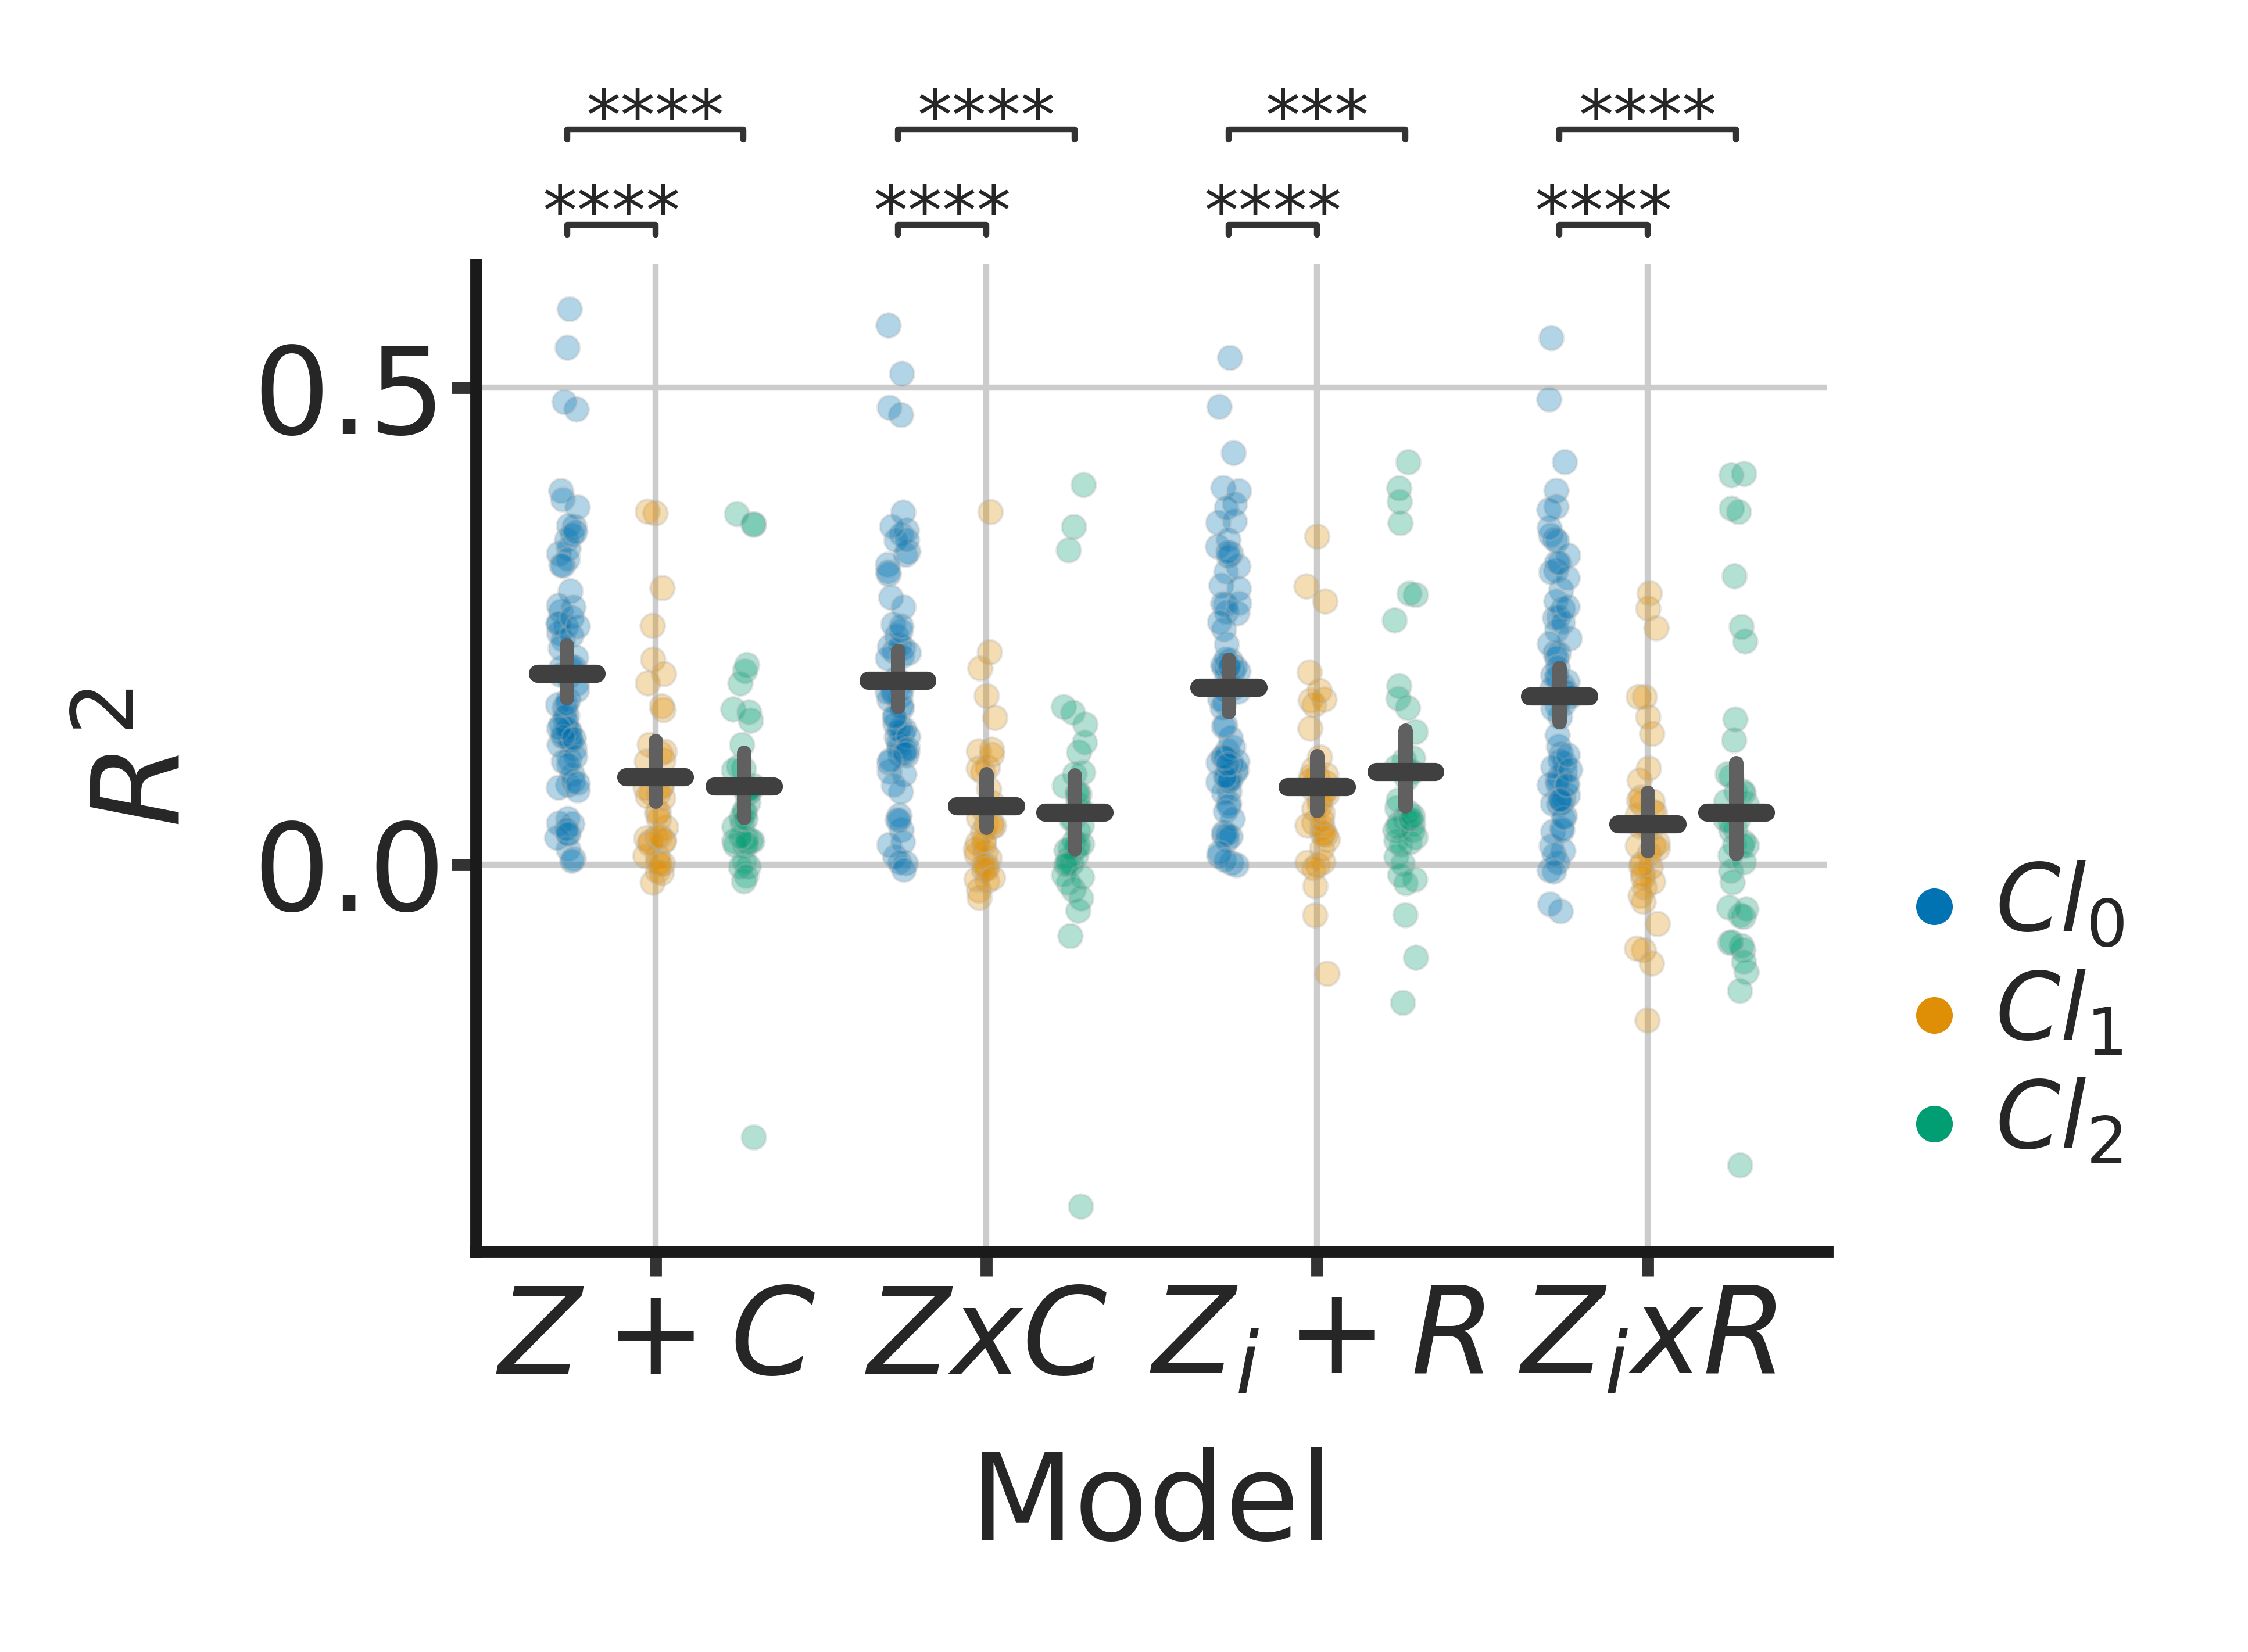

In [47]:
pf = reload(pf)
f = pf.CrossTaskFigures()
score_group='enc'
#f.plot_scores_by_cluster(score_group=score_group)
f.plot_scores_by_group(score_group=score_group)
#f.scatter_scores_by_cluster(score_group=score_group)

In [122]:
score_group = 'enc'
cols1, _ = f.get_score_table_columns_by_group(score_group)
table = combined_scores_table2[['subject', 'match_cl_id']+cols1].copy()
table['Cluster'] = cluster_table.Cluster.astype(pd.api.types.CategoricalDtype())
table['umap1'] = cluster_table['UMAP-1']

table = table.dropna()
table = table.rename(columns={s1: s1.split('-')[1] for s1 in cols1})
table = table.melt(id_vars=['Cluster', 'subject', 'match_cl_id', 'umap1'], value_name='score', var_name=score_group)

table['cond'] = table[score_group].apply(lambda s: s.split('_')[1] )
table['remap2'] = table[score_group].apply(lambda s: s.split('_')[0] )


table.head()

Cluster subject  match_cl_id      umap1       enc     score cond remap2
0       1      Li            0   2.951423  rate_cue  0.043149  cue   rate
1       2      Li            1   9.045257  rate_cue  0.023974  cue   rate
2       2      Li            1  11.271812  rate_cue  0.026001  cue   rate
3       0      Li            2  -5.057338  rate_cue  0.024433  cue   rate
4       0      Li            2  -5.611038  rate_cue  0.024433  cue   rate

In [124]:
# mdf = smf.mixedlm(formula="np.log(score+1) ~ -1 + remap*Cluster",
#                   groups='subject', re_formula='1', data=table).fit()
# mdf = smf.mixedlm(formula=" np.log(score+1) ~ -1 + remap2*cond*Cluster", #remap2 + cond + Cluster + remap2:cond:Cluster",
#                   groups='subject', re_formula='1', data=table).fit()
# mdfn = smf.mixedlm(formula="np.log(score+1) ~ -1 + remap2 + cond + Cluster",
#                   groups='subject', re_formula='1', data=table).fit()

vc={'match_cl_id':'0+C(match_cl_id)'}

mdf = smf.mixedlm(formula=" score ~ -1 + remap2 + cond + Cluster",
                  groups='subject', re_formula='1', vc_formula=vc, data=table).fit()
mdfn = smf.mixedlm(formula="score ~ -1 + remap2 + cond",
                  groups='subject', re_formula='1', vc_formula=vc, data=table).fit()

print(mdf.summary())
print()
print(mdf.wald_test_terms())
print()
print(mdfn.summary())

LRT = 2*(mdf.llf-mdfn.llf)
chi2_p = stats.chi2.sf(LRT,1)
print(f"LRT = {LRT:0.2f}; Chi2_p={chi2_p}")

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  score   
No. Observations:   584      Method:              REML    
No. Groups:         3        Scale:               0.0042  
Min. group size:    112      Log-Likelihood:      605.6389
Max. group size:    284      Converged:           Yes     
Mean group size:    194.7                                 
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
remap2[global]   0.129    0.041  3.158 0.002  0.049  0.209
remap2[rate]     0.146    0.041  3.568 0.000  0.066  0.226
cond[T.rw]      -0.007    0.005 -1.244 0.213 -0.017  0.004
Cluster[T.1]     0.008    0.015  0.568 0.570 -0.021  0.037
Cluster[T.2]     0.010    0.016  0.610 0.542 -0.022  0.042
subject Var      0.004    0.072                           
match_cl_id Var  0.011    0.027                           


      

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [348]:
mdf.pvalues

remap2[global]    1.028784e-02
remap2[rate]      2.971429e-03
cond[T.rw]        6.092666e-01
Cluster[T.1]      6.435592e-15
Cluster[T.2]      1.497241e-12
subject Var       2.752044e-01
dtype: float64

[(('Cue', 1), ('Cue', 0)), (('Cue', 2), ('Cue', 0)), (('RW', 1), ('RW', 0)), (('RW', 2), ('RW', 0))] [2.044935458923297e-06, 0.0026865897899100584, 1.2374956124657817e-06, 1.630186740266905e-06]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cue_0 vs. Cue_1: Custom statistical test, P_val:2.045e-06
RW_0 vs. RW_1: Custom statistical test, P_val:1.237e-06
RW_0 vs. RW_2: Custom statistical test, P_val:1.630e-06
Cue_0 vs. Cue_2: Custom statistical test, P_val:2.687e-03


(<Figure size 3000x2250 with 1 Axes>,
 <AxesSubplot:xlabel='Model', ylabel='$R^2$'>)

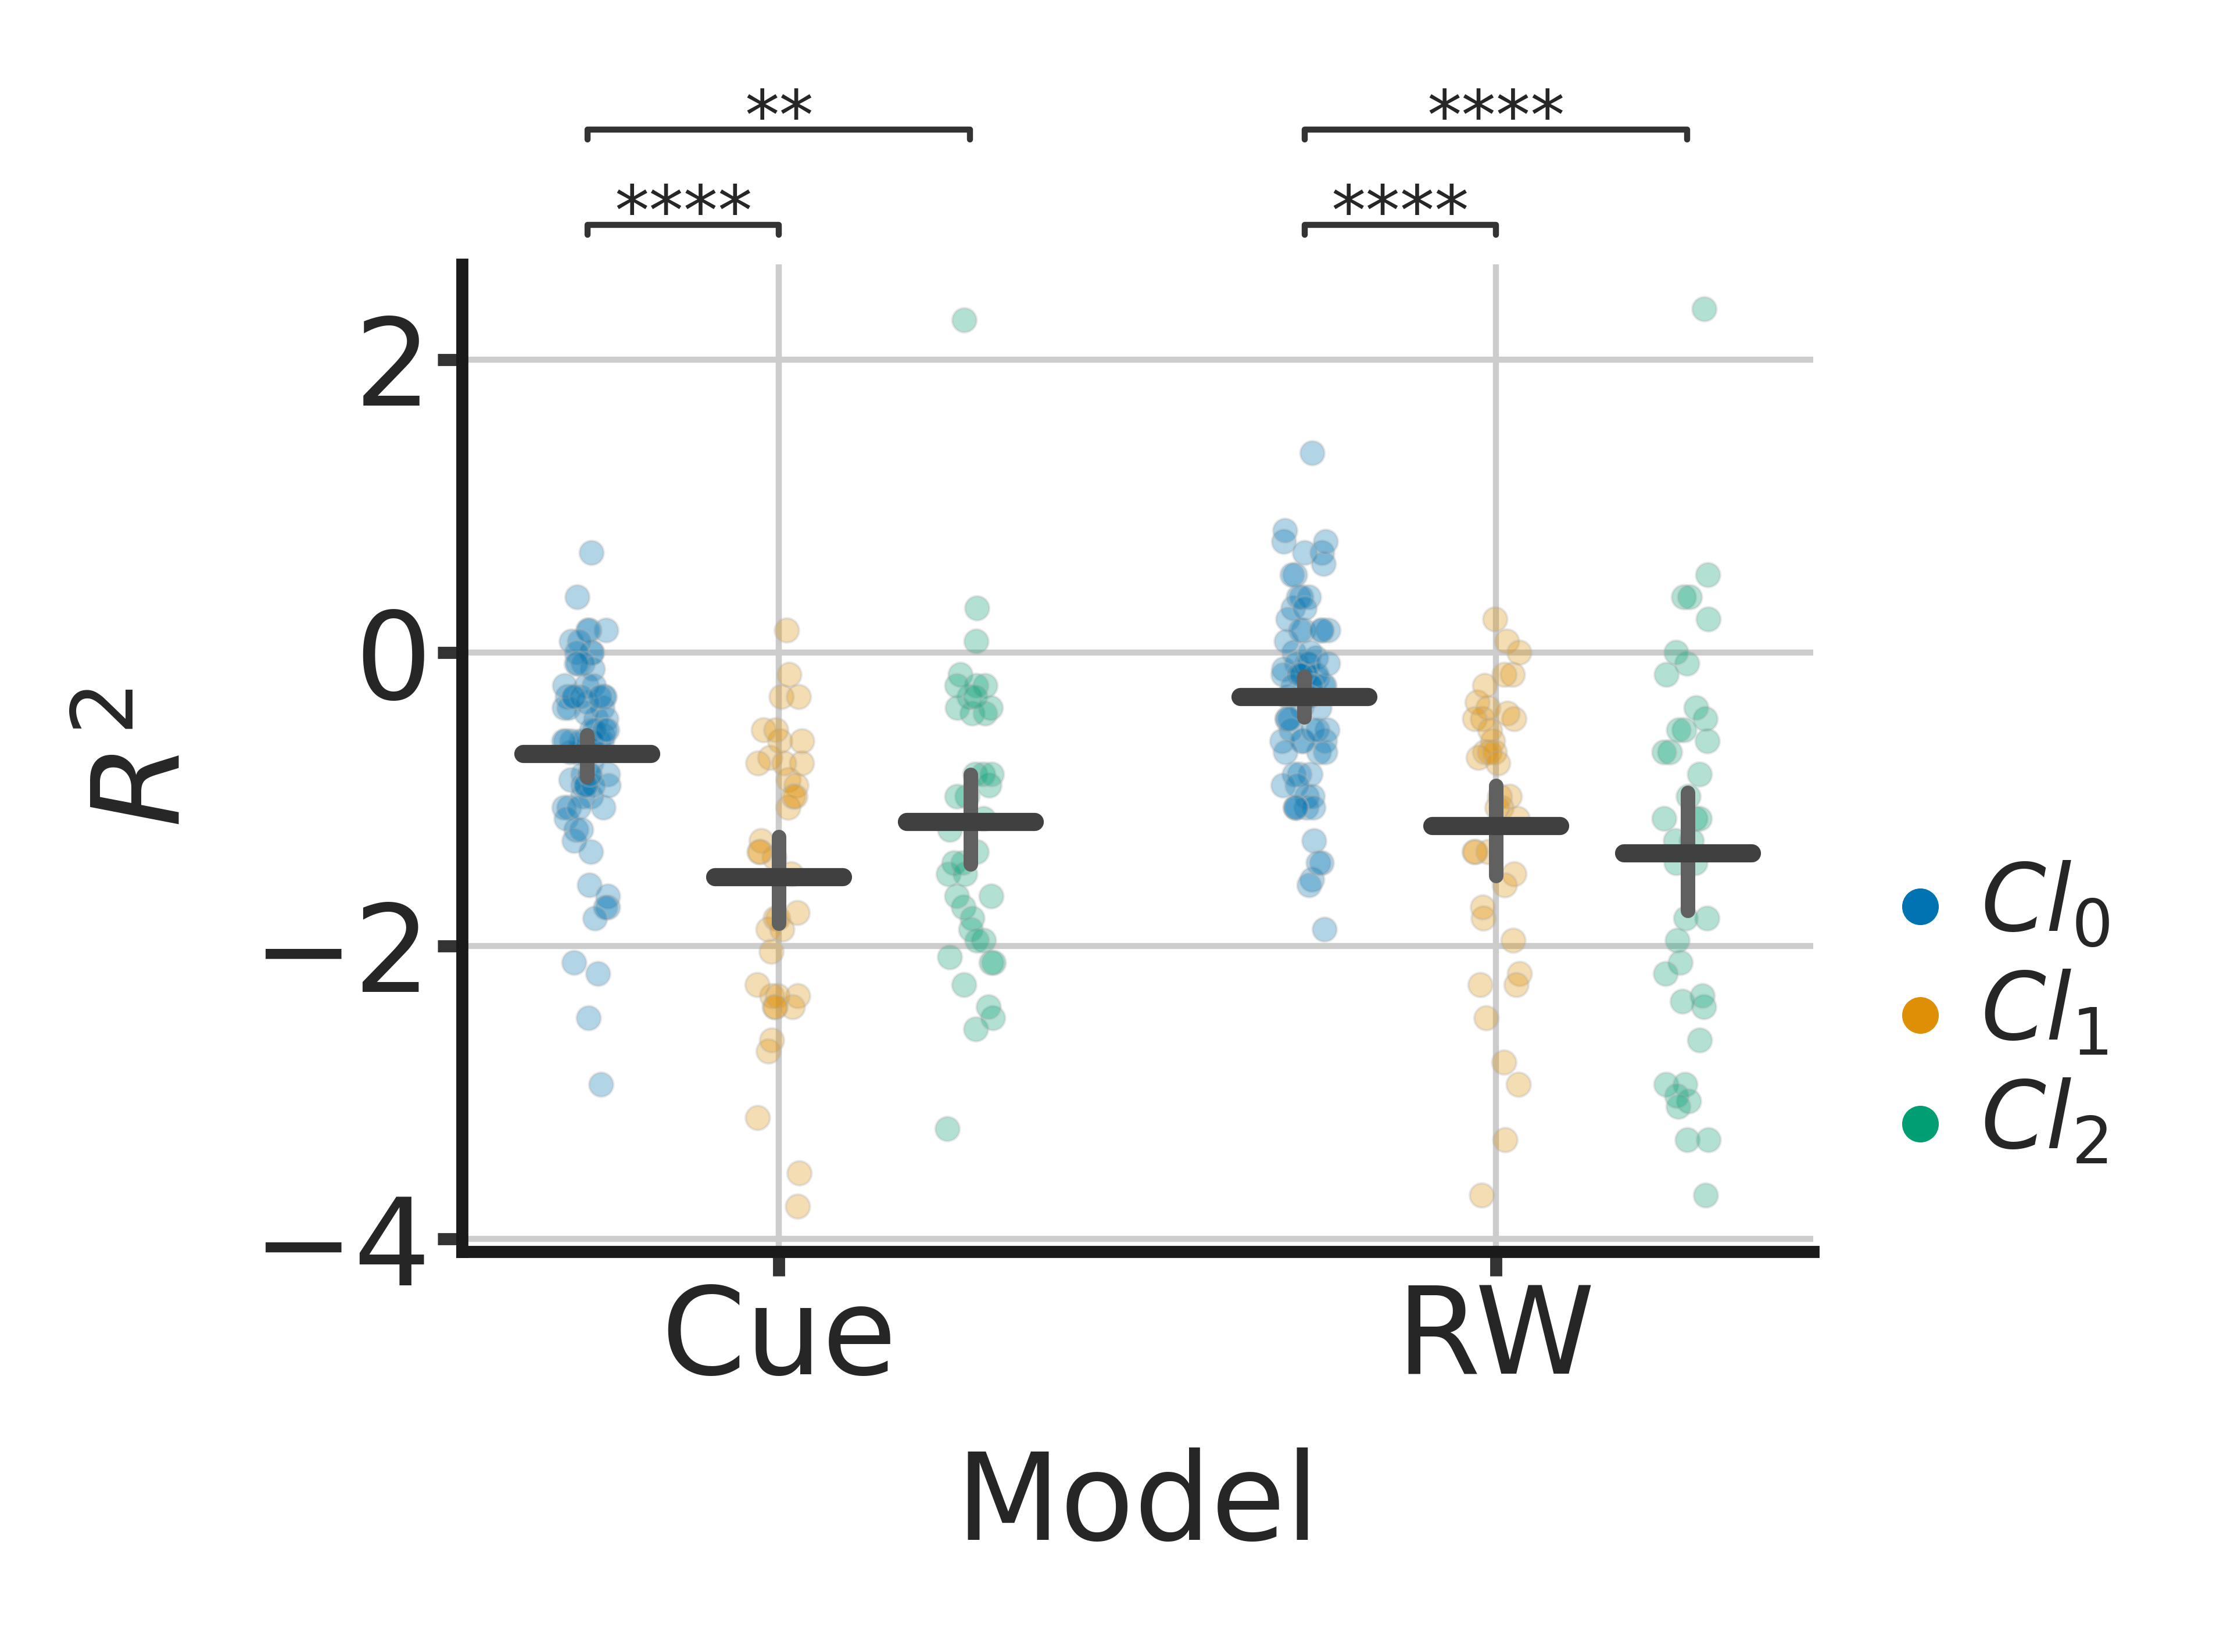

In [50]:
pf = reload(pf)
f = pf.CrossTaskFigures()
score_group='delta_enc'
#f.plot_scores_by_cluster(score_group=score_group)
f.plot_scores_by_group(score_group=score_group)
#f.scatter_scores_by_cluster(score_group=score_group)

In [125]:
select_columns = ['TM-enc_uz_cue', 'TM-enc_uz_rw']
table = combined_scores_table2[['subject', 'match_cl_id']+select_columns].copy()
table['Cluster'] = cluster_table.Cluster.astype(pd.api.types.CategoricalDtype())
table['umap1'] = cluster_table['UMAP-1']

table = table.dropna()
table = table.rename(columns={'TM-enc_uz_cue':'Cue', 'TM-enc_uz_rw':'RW'})
table = table.melt(id_vars=['Cluster', 'subject','match_cl_id', 'umap1'], value_name='score', var_name='remap')

table.head()

Cluster subject  match_cl_id      umap1 remap     score
0       1      Li            0   2.951423   Cue -0.831522
1       2      Li            1   9.045257   Cue -1.058301
2       2      Li            1  11.271812   Cue -0.680336
3       0      Li            2  -5.057338   Cue -0.907115
4       0      Li            2  -5.611038   Cue -0.907115

In [126]:
mdf = smf.mixedlm(formula="score ~ -1 + remap+Cluster",
                  groups='subject', re_formula='1', vc_formula=vc,data=table).fit()
mdfn = smf.mixedlm(formula="score ~ -1 + remap",
                  groups='subject', re_formula='1',vc_formula=vc, data=table).fit()

print(mdf.summary())
print(mdf.wald_test_terms())
print()
print(mdfn.summary())
LRT = 2*(mdf.llf-mdfn.llf)
chi2_p = stats.chi2.sf(LRT,1)
print(f"LRT = {LRT:0.2f}; Chi2_p={chi2_p}")

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score    
No. Observations: 324     Method:             REML     
No. Groups:       3       Scale:              0.7109   
Min. group size:  56      Log-Likelihood:     -410.9915
Max. group size:  160     Converged:          Yes      
Mean group size:  108.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
remap[Cue]   -0.871    0.200 -4.359 0.000 -1.262 -0.479
remap[RW]    -0.549    0.200 -2.747 0.006 -0.940 -0.157
Cluster[T.1] -0.249    0.130 -1.919 0.055 -0.504  0.005
Cluster[T.2] -0.152    0.135 -1.132 0.258 -0.416  0.111
subject Var   0.090    0.118                           

              chi2    P>chi2  df constraint
remap    25.169343  0.000003              2
Cluster   3.719475  0.155714              2

         Mixed Linear Model Regress

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Thur vs. Fri: Mann-Whitney-Wilcoxon test two-sided, P_val:6.477e-01 U_stat=6.305e+02
Thur vs. Sat: Mann-Whitney-Wilcoxon test two-sided, P_val:4.690e-02 U_stat=2.180e+03
Sun vs. Fri: Mann-Whitney-Wilcoxon test two-sided, P_val:2.680e-02 U_stat=9.605e+02


(<AxesSubplot:xlabel='day', ylabel='total_bill'>,
  <statannotations.Annotation.Annotation at 0x7f9582d76670>])

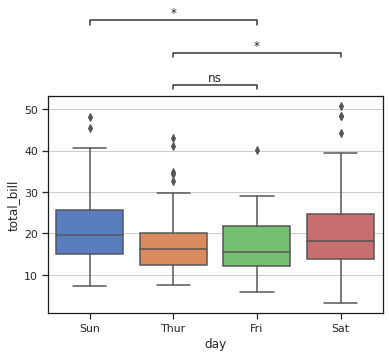

In [104]:
import seaborn as sns

from statannotations.Annotator import Annotator

df = sns.load_dataset("tips")
x = "day"
y = "total_bill"
order = ['Sun', 'Thur', 'Fri', 'Sat']

ax = sns.boxplot(data=df, x=x, y=y, order=order)

pairs=[("Thur", "Fri"), ("Thur", "Sat"), ("Fri", "Sun")]

annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

In [403]:
f.match_of_clusters.Cluster.astype(pd.api.types.CategoricalDtype()).

[0, 2, 1]
Categories (3, int64): [0, 1, 2]

In [391]:
select_columns = [f"OF-{s}-agg_sdp_coef" for s in ['speed', 'hd']]
print (f.match_scores_table[select_columns][f.match_of_clusters.Cluster==2].mean(),
np.nanmean(f.match_scores_table[select_columns][f.match_of_clusters.Cluster==2].values, axis=0))

OF-speed-agg_sdp_coef    0.317105
OF-hd-agg_sdp_coef      -0.184966
dtype: float64 [ 0.31710537 -0.18496614]


In [363]:
select_columns = [f"OF-{s}-agg_sdp_coef" for s in ['speed', 'hd']]
f.match_scores_table[select_columns]


OF-speed-agg_sdp_coef  OF-hd-agg_sdp_coef
0                -0.609305            0.882866
1                 0.535622           -0.370536
2                 0.535622           -0.370536
3                 0.314193            0.059493
4                 0.314193            0.059493
..                     ...                 ...
295               0.204592           -0.120512
296              -0.096583            0.059701
297              -0.096583            0.059701
298              -0.183313            0.214869
299              -0.754441            0.636815

[300 rows x 2 columns]

In [359]:
combined_scores_table[[f"OF-{s}-agg_sdp_coef" for s in ['speed', 'hd']]]

OF-speed-agg_sdp_coef  OF-hd-agg_sdp_coef
0                -0.609305            0.882866
1                 0.535622           -0.370536
2                 0.535622           -0.370536
3                 0.314193            0.059493
4                 0.314193            0.059493
..                     ...                 ...
295               0.204592           -0.120512
296              -0.096583            0.059701
297              -0.096583            0.059701
298              -0.183313            0.214869
299              -0.754441            0.636815

[300 rows x 2 columns]

In [353]:
sns.palettes.color_palette(palette="Set2")[1:][:2]

[(0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549)]

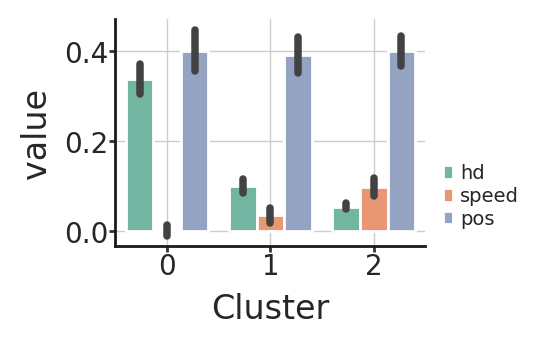

In [130]:
selected_columns = [c for c in of_score_names if ('metric' in c) and (c.split('_')[2] in ['hd', 'speed', 'pos'])]

selected_table = combined_scores_table[selected_columns].copy()
selected_table['Cluster'] = cluster_table['Cluster']
selected_table['Cluster_z'] = cluster_table_z['Cluster']
t2 = selected_table.melt(id_vars=['Cluster', 'Cluster_z'], var_name='of_metrics', value_name='value')

f,ax = plt.subplots(figsize=(2,1.5), dpi=200)
sns.barplot(data=t2, x='Cluster', y='value', hue='of_metrics', palette="Set2", ax=ax)

pf.setup_axes(ax)

legend_fontsize=7
h, l = ax.get_legend_handles_labels()
l = [ll.split('_')[2] for ll in l]
ax.legend(h, l, loc='lower left', bbox_to_anchor=(1, 0), frameon=False,
          fontsize=legend_fontsize, labelspacing=0.2, handlelength=0.5, handletextpad=0.4)

In [132]:
tm_score_names

['TM-remap_cue',
 'TM-remap_rw',
 'TM-stability_tm',
 'TM-rate_cue',
 'TM-rate_rw',
 'TM-global_cue',
 'TM-global_rw',
 'TM-enc_uz_cue',
 'TM-enc_uz_rw',
 'TM-fr_uz_cue',
 'TM-fr_uz_rw']

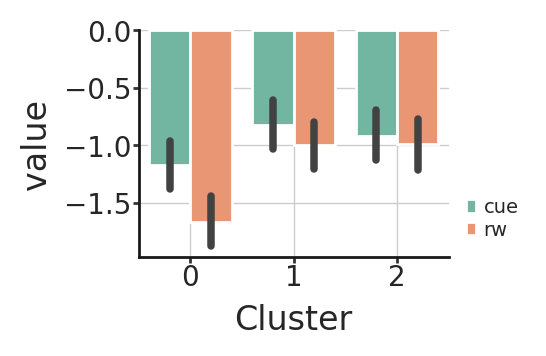

In [131]:
selected_columns = [c for c in tm_score_names if ('TM-remap' in c) ]

selected_table = combined_scores_table[selected_columns].copy()
selected_table['Cluster'] = cluster_table['Cluster']
selected_table['Cluster_z'] = cluster_table_z['Cluster']

var_name='remap'
t2 = selected_table.melt(id_vars=['Cluster', 'Cluster_z'], var_name=var_name, value_name='value')

f,ax = plt.subplots(figsize=(2,1.5), dpi=200)
sns.barplot(data=t2, x='Cluster', y='value', hue=var_name, palette="Set2", ax=ax)

pf.setup_axes(ax)

legend_fontsize=7
h, l = ax.get_legend_handles_labels()
l = [ll.split('_')[1] for ll in l]
ax.legend(h, l, loc='lower left', bbox_to_anchor=(1, 0), frameon=False,
          fontsize=legend_fontsize, labelspacing=0.2, handlelength=0.5, handletextpad=0.4)


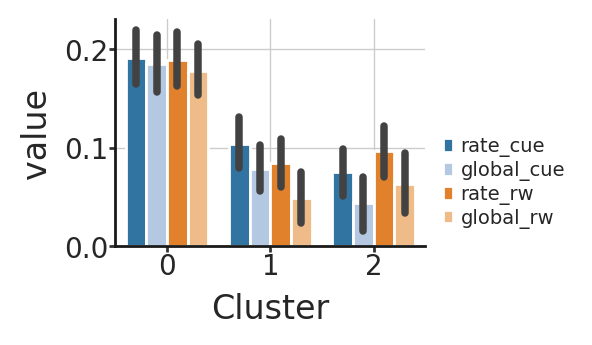

In [148]:
selected_columns = ['TM-rate_cue','TM-global_cue','TM-rate_rw','TM-global_rw',]

selected_table = combined_scores_table[selected_columns].copy()
selected_table['Cluster'] = cluster_table['Cluster']
selected_table['Cluster_z'] = cluster_table_z['Cluster']

var_name='remap'
t2 = selected_table.melt(id_vars=['Cluster', 'Cluster_z'], var_name=var_name, value_name='value')

f,ax = plt.subplots(figsize=(2,1.5), dpi=200)
sns.barplot(data=t2, x='Cluster', y='value', hue=var_name, palette="tab20", ax=ax)

pf.setup_axes(ax)

legend_fontsize=7
h, l = ax.get_legend_handles_labels()
l = [ll.split('-')[1] for ll in l]
ax.legend(h, l, loc='lower left', bbox_to_anchor=(1, 0), frameon=False,
          fontsize=legend_fontsize, labelspacing=0.2, handlelength=0.5, handletextpad=0.4)

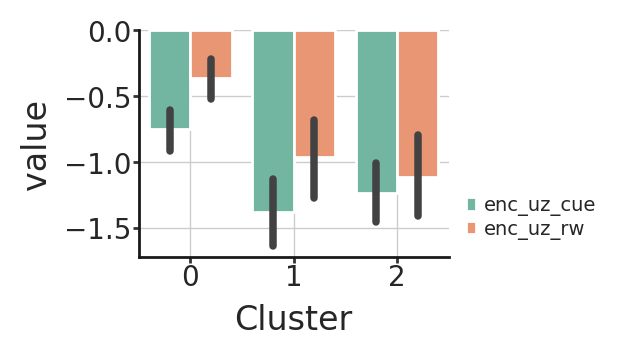

In [146]:
selected_columns = ['TM-enc_uz_cue',
 'TM-enc_uz_rw']

selected_table = combined_scores_table[selected_columns].copy()
selected_table['edgecolorCluster'] = cluster_table['Cluster']
selected_table['Cluster_z'] = cluster_table_z['Cluster']

var_name='remap'
t2 = selected_table.melt(id_vars=['Cluster', 'Cluster_z'], var_name=var_name, value_name='value')

f,ax = plt.subplots(figsize=(2,1.5), dpi=200)
sns.barplot(data=t2, x='Cluster', y='value', hue=var_name, palette="Set2", ax=ax)

pf.setup_axes(ax)

legend_fontsize=7
h, l = ax.get_legend_handles_labels()
l = [ll.split('-')[1] for ll in l]
ax.legend(h, l, loc='lower left', bbox_to_anchor=(1, 0), frameon=False,
          fontsize=legend_fontsize, labelspacing=0.2, handlelength=0.5, handletextpad=0.4)

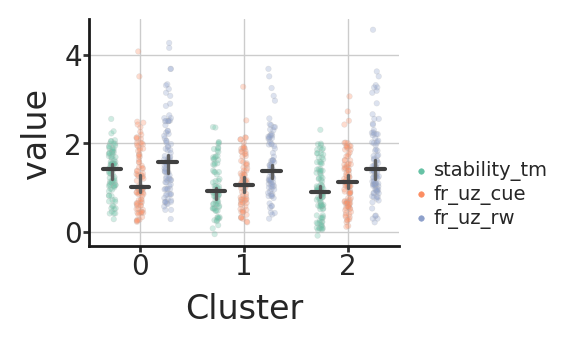

In [330]:
selected_columns = ['TM-stability_tm','TM-fr_uz_cue', 'TM-fr_uz_rw']

selected_table = combined_scores_table[selected_columns].copy()
selected_table['Cluster'] = cluster_table['Cluster']

x_var = 'Cluster'
y_var = 'value'
hue_var='remap'

t2 = selected_table.melt(id_vars=['Cluster'], var_name=hue_var, value_name='value')

f,ax = plt.subplots(figsize=(2,1.5), dpi=200)
#sns.barplot(data=t2, x='Cluster', y='value', hue=var_name, palette="Set2", ax=ax)
#sns.violinplot(data=t2, x='Cluster', y='value', hue=var_name, palette="Set2", inner=None, color='white', ax=ax)
#sns.pointplot(data=t2, x='Cluster', y='value', hue=var_name, palette="Set2", dodge=0.55, join=False, ax=ax)
marker_size= 2
marker_ec ='0.7'
marker_lw = 0.2
marker_alpha=0.3

mean_lw = 1.5
mean_lc = 0.25

sns.stripplot(data=t2, x=x_var, y=y_var, hue=hue_var, palette="Set2", dodge=True, size=marker_size, 
              alpha=marker_alpha, edgecolor=marker_ec, linewidth=marker_lw, ax=ax)



legend_fontsize=7
h, l = ax.get_legend_handles_labels()
for hh in h:    
    hh.set_sizes([marker_size*2])
    hh.set_lw(marker_lw)
l = [ll.split('-')[1] for ll in l]
ax.legend(h, l, loc='lower left', bbox_to_anchor=(1, 0), frameon=False,
          fontsize=legend_fontsize, labelspacing=0.2, handlelength=0.5, handletextpad=0.4)

pf.setup_axes(ax)

add_median_ci(ax, t2, x_var, y_var, hue_var, mean_lw, mean_lc, func=np.nanmedian)
        


In [326]:
def add_median_ci(ax, data, x_var, y_var, hue_var, mean_lw=1.5, mean_lc=0.2, func=np.nanmean):
    
    mean_err_lw = mean_lw*4/5
    mean_err_lc = mean_lc*1.5
    
    
    x_vals = t2[x_var].unique()
    n_x_vals = len(x_vals)
    hue_vals = t2[hue_var].unique()
    n_hue_vals = len(hue_vals)

    hue_locs = np.linspace(-0.535,0.535, n_hue_vals+2)[1:-1]
    hue_spacing = hue_locs[1]-hue_locs[0]
    err_width = hue_spacing/3

    for ii, xx in enumerate(x_vals):
        for jj, hh in enumerate(hue_vals):
            idx = (t2[x_var]==xx)  & (t2[hue_var]==hh)
            x_loc = ii + hue_locs[jj]

            y_median = func(t2[y_var][idx])

            vals = t2[y_var][idx]
            ax.plot([x_loc-err_width, x_loc+err_width], [y_median]*2, color=str(mean_lc), lw=mean_lw, zorder=10)
            ci = bootstrap(data=(vals,), statistic=func)

            ax.plot([x_loc]*2, ci.confidence_interval, color=str(mean_err_lc), lw=mean_err_lw, zorder=9)
            
def modify_legend(ax, labels, legend_fontsize=7, marker_size title=None):
    
    
    h, l = ax.get_legend_handles_labels()
    for hh in h:    
        hh.set_sizes([marker_size*2])
        hh.set_lw(marker_lw)
    l = [ll.split('-')[1] for ll in l]
    if title is not None:
        ax.legend(h, l, loc='lower left', bbox_to_anchor=(1, 0), frameon=False,
              fontsize=legend_fontsize, labelspacing=0.2, handlelength=0.5, handletextpad=0.4,
                 title)
    else:
        ax.legend(h, l, loc='lower left', bbox_to_anchor=(1, 0), frameon=False,
              fontsize=legend_fontsize, labelspacing=0.2, handlelength=0.5, handletextpad=0.4)
    

        

In [292]:
bootstrap(data=(vals,), statistic=np.nanmedian)

TypeError: 'BootstrapResult' object is not subscriptable

In [288]:
from scipy.stats import bootstrap
vals = t2[y_var][idx]
bootstrap(data=(vals,), statistic=np.nanmedian)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1.1851360237646538, high=1.6136642472488365), standard_error=0.11090809962239287)

In [281]:
np.atleast_1d(vals).shape[0]

80

In [223]:
n =3
np.linspace(-0.5,0.5, n+2)[1:-1]

array([-0.25,  0.  ,  0.25])

In [188]:
sns.stripplot?

Signature:
sns.stripplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    jitter=True,
    dodge=False,
    orient=None,
    color=None,
    palette=None,
    size=5,
    edgecolor='gray',
    linewidth=0,
    ax=None,
    **kwargs,
)
Docstring:
Draw a scatterplot where one variable is categorical.

A strip plot can be drawn on its own, but it is also a good complement
to a box or violin plot in cases where you want to show all observations
along with some representation of the underlying distribution.


Input data can be passed in a variety of formats, including:

- Vectors of data represented as lists, numpy arrays, or pandas Series
  objects passed directly to the ``x``, ``y``, and/or ``hue`` parameters.
- A "long-form" DataFrame, in which case the ``x``, ``y``, and ``hue``
  variables will determine how the data are plotted.
- A "wide-form" DataFrame, such that each numeric column will be plotted.
- An array or list of vectors.

I

array(10)

In [ ]:
selected_columns = [c for c in of_score_names if ('agg_sdp_coef' in c) ]

selected_table = combined_scores_table[selected_columns].copy()
selected_table['Cluster'] = cluster_table['Cluster']
selected_table['Cluster_z'] = cluster_table_z['Cluster']
t2 = selected_table.melt(id_vars=['Cluster', 'Cluster_z'], var_name='of_metrics', value_name='value')
sns.barplot(data=t2, x='Cluster', y='value', hue='of_metrics', palette="Set2")

In [305]:
def umap_cell_clusters(data, n_umap_clusters=2, **umap_params):
    params = {'n_components': n_umap_clusters, 'n_neighbors': 25, 'min_dist': 0.1}
    params.update(umap_params)
    return UMAP(**params).fit_transform(data)
              
def cluster_data(data, n_clusters=3, method='kmeans', return_all=False, **cluster_params):
          
    params = {}
    if method == 'bikmeans':
        params.update(cluster_params)
        params['n_clusters'] = n_clusters
        func = BisectingKMeans(**params)
    elif method == 'agg':
        params.update(cluster_params)
        params['n_clusters'] = n_clusters
        func = AgglomerativeClustering(**params)
    else:
        params.update(cluster_params)
        params['n_clusters'] = n_clusters
        func = KMeans(**params)
              
    model = func.fit(data)
    labels = model.predict(data)
              
    if return_all:      
        centroids = model.cluster_centers_
        return labels, centroids, model
    
    return labels
    
              
def score_clusters(data, labels, metric='MSE'):
    n_clusters = len(labels.unique())

    n_dims = data.shape[1]
    cluster_means = np.zeros((n_clusters, n_dims))
    for ii in range(n_clusters):
        idx = labels==ii
        cluster_means[ii] = data[labels==ii].mean()

    #resorted_clusters = 
              
    score_by_cluster = pd.DataFrame(index=range(n_clusters), columns=['n_samples', 'score'])
    for ii in range(n_clusters):
        idx = labels==ii
        mu = data[labels==ii].mean()

        score = (((x-mu)**2).sum(axis=1)).mean()
        score_by_cluster.loc[ii] = np.sum(idx), score

    return score_by_cluster

def cosine_clustering_score(data, labels):
    n_samps = data.shape[0]
    n_clusters = len(np.unique(labels))
    centroids_by_samp = np.zeros_like(data)*np.nan
    for jj in range(n_clusters):
        idx = labels==jj
        if idx.sum()>0:
            centroids_by_samp[idx] = data[idx].mean(axis=0)

    d = sample_cosine_dist(data, centroids_by_samp)
    return np.mean(d)
   
def sample_cosine_dist(x,y):
    xn = np.linalg.norm(x,ord=2,axis=1)
    yn = np.linalg.norm(y,ord=2,axis=1)
    return 1-(x*y).sum(axis=1)/(xn*yn)
    
def cluster_MSE(x, mu):
    return ((x-mu)**2).sum(axis=1).mean()

def MSE_clustering_score(X, labels, weighting='sample_weighted_mean'):
    cluster_labels = np.unique(labels)
    n_clusters = len(cluster_labels)
        
    cluster_scores = np.zeros(n_clusters)
    for ii, g in enumerate(cluster_labels):
        idx = np.where(labels==g)[0]
        mu = X[idx].mean(axis=0)
        cluster_scores[ii] = cluster_MSE(X[idx], mu)
    
    if weighting == 'median':
        error = np.median(cluster_scores)
    elif weighting == 'mean':
        error = np.mean(cluster_scores)
    elif weighting == 'sample_weighted_mean':
        weights = 1/np.bincount(labels)
        error = np.mean(cluster_scores*weights)
    elif weighting == 'sample_weighted_median':
        weights = 1/np.bincount(labels)
        error = np.median(cluster_scores*weights)
    else:
        error = group_norms.sum()
        
    return error

In [291]:
%%time
np.random.seed(0)

score_key = 'agg_sdp_coef'
OF_cluster_score_names = [c for c in of_score_names if score_key in c]

X = combined_scores_table[OF_cluster_score_names]
X = X.sub(X.mean(axis=1).values,axis=0)
X = X.div(X.std(axis=1).values,axis=0)
umap_coords = umap_cell_clusters(X)

CPU times: user 6.11 s, sys: 223 ms, total: 6.34 s
Wall time: 1.79 s


Text(0, 0.5, 'UMAP-2')

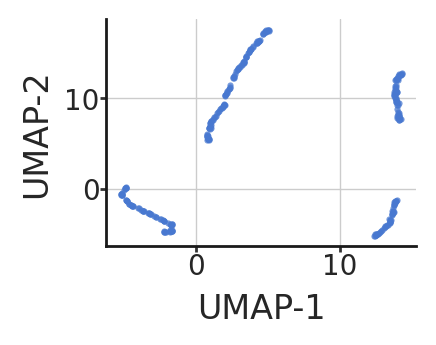

In [292]:
f,ax=plt.subplots(figsize=(2,1.5), dpi=200)
pf.setup_axes(ax)

ax.scatter(*umap_coords.T, s=5, lw=0, alpha=0.75)
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")

### KMEANS

In [310]:
%%time

np.random.seed(0)

umap_neighbors = np.arange(15,35, 5)
n_neighbor_expt = len(umap_neighbors)
n_folds = 5
n_repeats = 3

clusters_range = np.arange(1,7)
n_cluster_range = len(clusters_range)
scores = np.zeros(len(clusters))
n_split = 2

of_clusters_table = pd.DataFrame(index=np.arange(n_repeats*n_cluster_range*n_neighbor_expt*n_folds*n_split), 
                                 columns=['repeat', 'n_clusters', 'umap_neighbor', 'fold', 'split', 'cosine', 'MSE'])

X = combined_scores_table[OF_cluster_score_names]
X = X.sub(X.mean(axis=1).values,axis=0)
X = X.div(X.std(axis=1).values,axis=0)

cnt = 0
for rr in range(n_repeats):
    for ii in range(n_neighbor_expt):
        X2 = umap_cell_clusters(X,**{'n_components': 2, 'n_neighbors': umap_neighbors[ii], 'min_dist': 0.1})
        n_samps, n_dims = X2.shape

        for kk in clusters_range:    
            kf = KFold(n_splits=n_folds, shuffle=True)

            fold = 0
            for train_idx, test_idx in kf.split(X):
                Xtrain = X2[train_idx]
                Xtest = X2[test_idx]

                train_labels, centroids, model = cluster_data(Xtrain, n_clusters=kk, method='bikmeans', return_all=True)
                test_labels = model.predict(Xtest)

                train_cs = cosine_clustering_score(Xtrain, train_labels)
                test_cs = cosine_clustering_score(Xtest, test_labels)

                train_mse = MSE_clustering_score(Xtrain, train_labels)
                test_mse = MSE_clustering_score(Xtest, test_labels)

                of_clusters_table.loc[cnt] = rr, kk, umap_neighbors[ii], fold, 'train', train_cs, train_mse
                cnt+=1

                of_clusters_table.loc[cnt] = rr, kk, umap_neighbors[ii], fold, 'test', test_cs, test_mse
                cnt+=1

                fold+=1

CPU times: user 4min 33s, sys: 7.42 s, total: 4min 40s
Wall time: 32.2 s


Text(0, 0.5, 'C.D. Error')

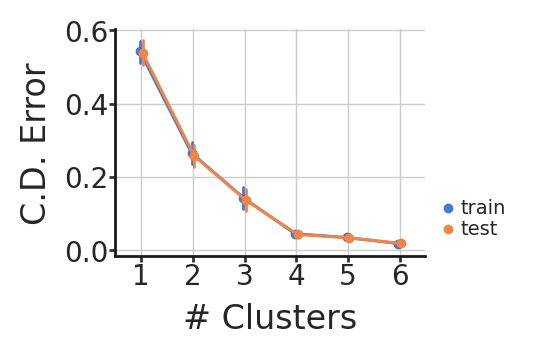

In [311]:
f,ax=plt.subplots(figsize=(2,1.5), dpi=200)
sns.pointplot(data=of_clusters_table, x='n_clusters', y='score', hue='split', dodge=True, errwidth=1, scale=0.4, ax=ax)
pf.setup_axes(ax)
h,l = ax.get_legend_handles_labels()
ax.legend(h, l, loc='lower left', bbox_to_anchor=(1,0), frameon=False, fontsize=7, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)
ax.set_xlabel("# Clusters")
ax.set_ylabel("C.D. Error")


Text(0, 0.5, 'MSE')

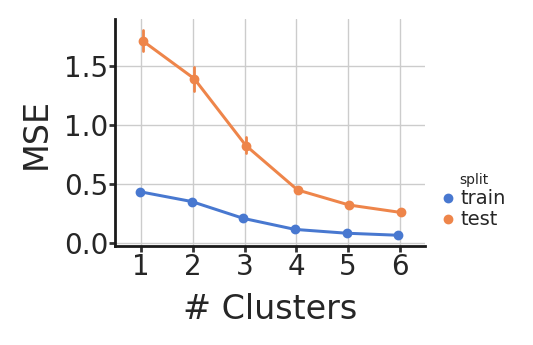

In [367]:
f,ax=plt.subplots(figsize=(2,1.5), dpi=200)
sns.pointplot(data=of_clusters_table, x='n_clusters', y='MSE', hue='split', dodge=True, errwidth=1, scale=0.4, ax=ax)
pf.setup_axes(ax)
h,l = ax.get_legend_handles_labels()
ll = ax.legend(h, l, loc='lower left', bbox_to_anchor=(1,0), frameon=False, fontsize=7, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)
ll.set_title("split", prop={'size': 5})
ax.set_xlabel("# Clusters")
ax.set_ylabel("MSE")


In [360]:
ll.set_title?

Signature: ll.set_title(title, prop=None)
Docstring:
Set the legend title. Fontproperties can be optionally set
with *prop* parameter.
File:      ~/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/matplotlib/legend.py
Type:      method


Text(0, 0.5, 'C.D. Error')

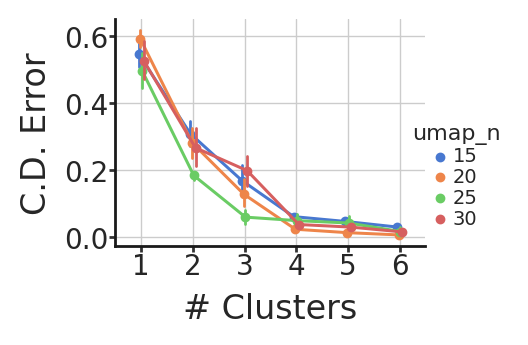

In [313]:
f,ax=plt.subplots(figsize=(2,1.5), dpi=200)
sns.pointplot(data=of_clusters_table, x='n_clusters', y='score', hue='umap_neighbor', dodge=True, errwidth=1, scale=0.4, ax=ax)
pf.setup_axes(ax)
h,l = ax.get_legend_handles_labels()
ax.legend(h, l, loc='lower left', bbox_to_anchor=(0.9,0), frameon=False, fontsize=7, labelspacing=0.1, handlelength=0.5, handletextpad=0.4, title='umap_n', title_fontsize=8)
ax.set_xlabel("# Clusters")
ax.set_ylabel("C.D. Error")


## Final Clustering

In [352]:
%%time
np.random.seed(0)

score_key = 'agg_sdp_coef'
z_score = False
OF_cluster_score_names = [c for c in of_score_names if score_key in c]

X = combined_scores_table[OF_cluster_score_names]

if z_score:
    X = X.sub(X.mean(axis=1).values,axis=0)
    X = X.div(X.std(axis=1).values,axis=0)
    n_clusters=4
else:
    n_clusters=3

umap_coords = umap_cell_clusters(X,**{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0.1, 'random_state':42})
labels, centroids, model = cluster_data(umap_coords, n_clusters=n_clusters, method='bikmeans', return_all=True)

dat = pd.DataFrame(columns=['UMAP-1','UMAP-2', 'Label'])
dat['Label'] = labels
dat[['UMAP-1', 'UMAP-2']] = umap_coords
dat['subject'] = combined_scores_table['subject']

CPU times: user 1.56 s, sys: 11.7 ms, total: 1.57 s
Wall time: 1.17 s


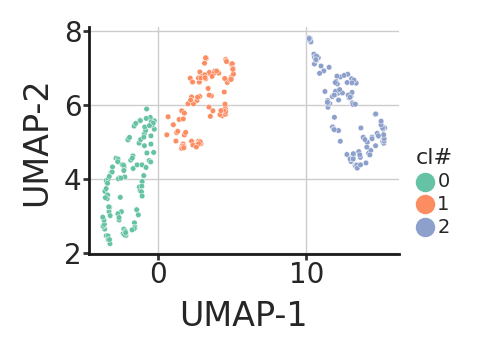

In [356]:
f,ax=plt.subplots(figsize=(2,1.5), dpi=200)
pf.setup_axes(ax)

sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Label', data=dat, ax=ax, s=4, palette="Set2")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")

h,l = ax.get_legend_handles_labels()
ax.legend(h, l, loc='lower left', bbox_to_anchor=(1,0), frameon=False, 
          fontsize=7, labelspacing=0.2, handlelength=0.5, handletextpad=0.4, title='cl#', title_fontsize=8)


In [355]:
a = pd.crosstab(dat['subject'], dat['Label'])
#a.div(a.sum(axis=1),axis=0)
a

Label     0   1   2
subject            
Al        0   0   2
Ca        0   1   6
Cl       27  53  83
Li       56  22  12
Mi        1   0   0
Ne       18  12   7

In [176]:
data = Xtrain
labels = train_labels

n_samps = data.shape[0]
    
centroids_by_samp = np.zeros_like(data)
for jj in range(cc):
    idx = labels==jj
    centroids_by_samp[idx] = data[idx].mean(axis=0)

d = sample_cosine_dist(data, centroids_by_samp)

/tmp/ipykernel_9739/3335460446.py:9: RuntimeWarning: Mean of empty slice.
  centroids_by_samp[idx] = data[idx].mean(axis=0)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


6

Text(0, 0.5, 'UMAP-2')

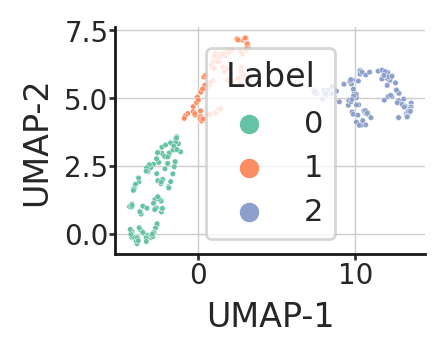

In [97]:
f,ax=plt.subplots(figsize=(2,1.5), dpi=200)
pf.setup_axes(ax)

sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Label', data=dat, ax=ax, s=4, palette="Set2")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")

In [ ]:
%%time
np.random.seed(0)

score_key = 'agg_sdp_coef'
OF_cluster_score_names = [c for c in of_score_names if score_key in c]

X = combined_scores_table[OF_cluster_score_names]

In [109]:
%%time
np.random.seed(0)

score_key = 'agg_sdp_coef'
OF_cluster_score_names = [c for c in of_score_names if score_key in c]

X = combined_scores_table[OF_cluster_score_names]

N = 20
K_range = np.arange(2,7)
K = len(K_range)
of_clusters_table = pd.DataFrame(index=range(N*K), columns=['n', 'k', 'score_1', 'score_2', 'score_3'])

cnt =0 
for ii in range(N):
    #method_kwargs = {'n_components': 2, 'n_neighbors': 25, 'min_dist': 0.1} # work well for cells only
    #of_models_umap = UMAP(**method_kwargs).fit_transform(X)
    of_models_umap = X
    for kk in K_range:
        centroids, labels, ss= k_means(of_models_umap, kk)
        ss2 = davies_bouldin_score(of_models_umap, labels)
        ss3 = silhouette_score(of_models_umap, labels)
        of_clusters_table.loc[cnt] = ii, kk, ss, ss2, ss3
        cnt += 1 
        
        
        
# of_clusters = pd.DataFrame(data=np.array((of_models_umap[:,0],of_models_umap[:,1], combined_scores_table['OF-agg_sdp-r2'], labels)).T, index=combined_scores_table.index, columns=['umap_1', 'umap_2', 'r2', 'cluster_id'])
# of_clusters


# plt.scatter(*of_models_umap.T, c=groups, s=combined_scores_table['OF-agg_sdp-r2']*200, cmap='Set1', alpha=0.4)




# c2["of_agg_groups"] = groups
# c2["of_agg_groups"] = c2["of_agg_groups"].astype(dtype='category')


CPU times: user 1min 13s, sys: 1.72 s, total: 1min 15s
Wall time: 3.87 s


<AxesSubplot:xlabel='k', ylabel='score_1'>

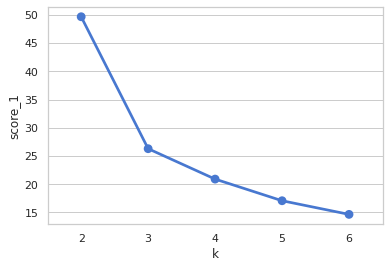

In [114]:
sns.pointplot(data=of_clusters_table, x='k', y='score_1')

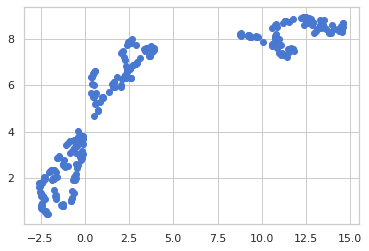

In [98]:
plt.scatter(*of_models_umap.T)

In [87]:
of_clusters_table

n  k      score_1   score_2
0    0  2  2394.520264  0.521586
1    0  3   742.126099   0.45599
2    0  4   460.992371  0.420393
3    0  5   333.774445  0.363179
4    0  6   210.922989  0.368532
..  .. ..          ...       ...
95  19  2  2413.774414  0.521586
96  19  3   721.628174   0.45599
97  19  4    455.10907  0.420393
98  19  5   320.311401  0.366508
99  19  6   205.980804   0.37312

[100 rows x 4 columns]

In [477]:
def cluster_MSE(x, mu):
    return ((x-mu)**2).sum(axis=1).mean()

def clusters_MSE(X, MU, labels, weighting=None):
    cluster_labels = np.unique(labels)
    n_clusters = len(cluster_labels)
        
    cluster_scores = np.zeros(n_groups)
    for ii, g in enumerate(cluster_labels):
        idx = np.where(labels==g)[0]
        cluster_scores[ii] = cluster_MSE(X[idx], Mu[g])
    
    if weighting == 'median':
        error = np.median(cluster_scores)
    elif weighting == 'mean':
        error = np.mean(cluster_scores)
    elif weighting == 'sample_weighted_mean':
        weights = 1/np.bincount(labels)
        error = np.mean(cluster_scores*weights)
    elif weighting == 'sample_weighted_median':
        weights = 1/np.bincount(labels)
        error = np.median(cluster_scores*weights)
    else:
        error = group_norms.sum()
        
    return error


In [484]:
%%time

np.random.seed(0)

n_repeats = 2
n_folds = 5
K_range = np.arange(1,7)
K = len(K_range)
n_split = 2
of_clusters_table = pd.DataFrame(index=np.arange(n_repeats*n_folds*K*n_split), columns=['k','fold', 'repeat', 'split', 'score_1', 'score_2', 'score_3', 'score_4'])

cnt = 0
X = combined_scores_table[OF_cluster_score_names].values
for repeat in range(n_repeats):
    method_kwargs = {'n_components': 2, 'n_neighbors': repeat*2+20, 'min_dist': 0.1} 
    X = UMAP(**method_kwargs).fit_transform(combined_scores_table[OF_cluster_score_names])
    
    for kk in K_range:    
        kf = KFold(n_splits=n_folds, shuffle=True)
        fold = 0
        for train_idx, test_idx in kf.split(X):
            Xtrain = X[train_idx]
            Xtest = X[test_idx]
            kmodel = KMeans(n_clusters=kk).fit(Xtrain)
            
            train_predicted_labels = kmodel.predict(Xtrain)
            test_predicted_labels = kmodel.predict(Xtest)
            MU = kmodel.cluster_centers_

            train_score_1 = norm_across_groups(Xtrain, MU, train_predicted_labels, weighting='group_mean')
            train_score_2 = norm_across_groups(Xtrain, MU, train_predicted_labels, weighting='group_sample_mean')
            train_score_3 = norm_across_groups(Xtrain, MU, train_predicted_labels, weighting='mean_group_sample_mean')
            train_score_4 = norm_across_groups(Xtrain, MU, train_predicted_labels, weighting='median_group_sample_mean')
            
            
            test_score_1 = norm_across_groups(Xtest, MU, test_predicted_labels, weighting='group_mean')
            test_score_2 = norm_across_groups(Xtest, MU, test_predicted_labels, weighting='group_sample_mean')
            test_score_3 = norm_across_groups(Xtest, MU, test_predicted_labels, weighting='mean_group_sample_mean')
            test_score_4 = norm_across_groups(Xtest, MU, test_predicted_labels, weighting='median_group_sample_mean')

            of_clusters_table.loc[cnt] = kk, fold, repeat, 'train', train_score_1, train_score_2, train_score_3, train_score_4
            cnt+=1
            of_clusters_table.loc[cnt] = kk, fold, repeat, 'test', test_score_1, test_score_2, test_score_3, test_score_4
            cnt+=1
            
            fold+=1
 

CPU times: user 51.1 s, sys: 1.34 s, total: 52.4 s
Wall time: 6.61 s


In [479]:
of_clusters_table.loc[(cnt-20):cnt]

k fold repeat  split   score_1   score_2   score_3   score_4
100  5    0      1  train  1.309789  5.075113  1.015023  0.931146
101  5    0      1   test  1.248108   5.30583  1.061166   1.01841
102  5    1      1  train  1.290084  5.237466  1.047493   0.94958
103  5    1      1   test  1.257461  4.952617  0.990523  0.979567
104  5    2      1  train  1.244017  5.006148   1.00123  0.944293
105  5    2      1   test  1.444888  5.713835  1.142767  1.095017
106  5    3      1  train  1.270226  5.115779  1.023156  0.952449
107  5    3      1   test   1.36441  5.212979  1.042596  0.970677
108  5    4      1  train  1.285252  5.134984  1.026997  0.964495
109  5    4      1   test  1.328194  5.152781  1.030556  0.922214
110  6    0      1  train   1.08425  5.354004  0.892334  0.900526
111  6    0      1   test  1.197108  5.937129  0.989522  0.945616
112  6    1      1  train  1.072448  5.485324  0.914221  0.914196
113  6    1      1   test  1.121182  5.589466  0.931578  0.876194
114  6    2      1  train  1.148174  5.602233  0.933706  0.915092
115  6    2      1   test  1.036199  5.235527  0.872588  0.887096
116  6    3      1  train  1.113477  5.504016  0.917336  0.900486
117  6    3      1   test  1.063263   5.57498  0.929163  0.954194
118  6    4      1  train  1.091229  5.415119   0.90252  0.892876
119  6    4      1   test  1.210117  5.901251  0.983542   0.98254

Text(0, 0.5, ' RMSE ')

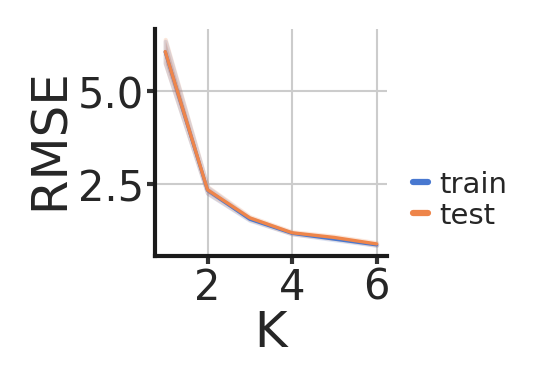

In [488]:
## pf = reload(pf)
f,ax = plt.subplots(figsize=(1,1), dpi=300)
pf.setup_axes(ax)
sns.lineplot(data=of_clusters_table, x='k', y='score_3', hue='split', ax=ax, lw=0.8)

h,l = ax.get_legend_handles_labels()
ax.legend(h, l, loc='lower left', bbox_to_anchor=(1,0), frameon=False, fontsize=7, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)
ax.set_xlabel(" K ", labelpad=0)
ax.set_xticks([2,4,6])
ax.set_ylabel(" RMSE ", labelpad=0)
#ax.tick_params(axis="both", direction="out", length=2, width=1, color='0.2', which='major')

Text(0, 0.5, ' MSE ')

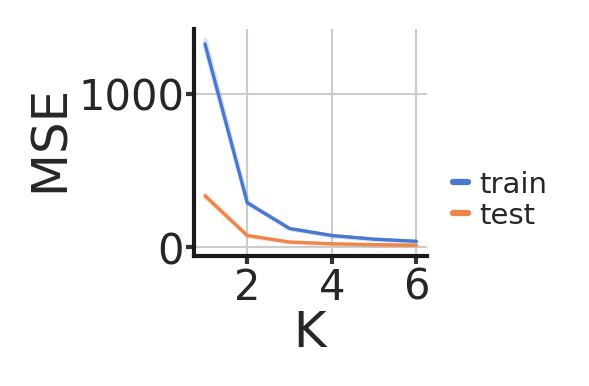

In [390]:
pf = reload(pf)
f,ax = plt.subplots(figsize=(1,1), dpi=300)
pf.setup_axes(ax)
sns.lineplot(data=of_clusters_table, x='k', y='score_2', hue='split', ax=ax, lw=0.8)

h,l = ax.get_legend_handles_labels()
ax.legend(h, l, loc='lower left', bbox_to_anchor=(1,0), frameon=False, fontsize=7, labelspacing=0.1, handlelength=0.5, handletextpad=0.4)
ax.set_xlabel(" K ", labelpad=0)
ax.set_xticks([2,4,6])
ax.set_ylabel(" MSE ", labelpad=0)

In [489]:
of_clusters_table.k.isin(np.arange(1,6))

of_clusters_table[]


k fold repeat  split      score_1   score_2   score_3   score_4
0    1    0      0  train  1564.233154  6.517638  6.517638  6.517638
1    1    0      0   test   391.321716  6.522029  6.522029  6.522029
2    1    1      0  train  1560.050415   6.50021   6.50021   6.50021
3    1    1      0   test   398.973297  6.649555  6.649555  6.649555
4    1    2      0  train  1558.795166   6.49498   6.49498   6.49498
..  ..  ...    ...    ...          ...       ...       ...       ...
115  6    2      1   test     8.463124  4.932834  0.822139  0.873737
116  6    3      1  train    35.296279  5.231533  0.871922  0.840617
117  6    3      1   test     8.833746  5.210477  0.868413  0.870185
118  6    4      1  train    34.560963  5.114169  0.852361  0.831828
119  6    4      1   test     9.571525  5.738299  0.956383  0.945425

[120 rows x 8 columns]

In [498]:
xx = of_clusters_table.groupby(['k', 'split']).mean()
xx

fold  repeat      score_1   score_2   score_3   score_4
k split                                                         
1 test    2.0     0.5   362.676691  6.044612  6.044612  6.044612
  train   2.0     0.5  1448.487952  6.035366  6.035366  6.035366
2 test    2.0     0.5    74.560161  4.698892  2.349446  2.349446
  train   2.0     0.5   296.630058  4.674982  2.337491  2.337491
3 test    2.0     0.5    32.314568  4.804981  1.601660  1.544685
  train   2.0     0.5   126.438226  4.698098  1.566033  1.482227
4 test    2.0     0.5    19.200192  4.812852  1.203213  1.222898
  train   2.0     0.5    75.666432  4.753197  1.188299  1.212114
5 test    2.0     0.5    13.240611  5.389284  1.077857  1.048286
  train   2.0     0.5    50.553825  5.170942  1.034188  1.028355
6 test    2.0     0.5     9.175249  5.430843  0.905141  0.892055
  train   2.0     0.5    35.773638  5.284015  0.880669  0.849216

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


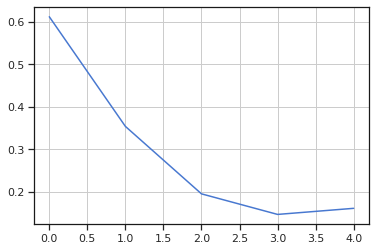

In [506]:
xx = of_clusters_table.groupby('k').mean()
x = xx.iloc[:-1,5].values
y = xx.iloc[1:,5].values

plt.plot((x-y)/x)
#plt.plot((xx.iloc[:-1,2].values-xx.iloc[1:,2].values)
# plt.plot(np.arange(2,7), 1-(xx[:-1,0]-xx[1:,0])/xx[0,0], '-o', lw=3)
# plt.plot(np.arange(2,7), 1-(xx[:-1,1]-xx[1:,1])/xx[0,1], '-o', lw=3)


In [299]:
xx = of_clusters_table.groupby('k').mean().reset_index()
xx
xx[['train_score','test_score']].diff(-1)

# sns.pointplot(data=xx, x='k', y='train_score')
# sns.pointplot(data=xx, x='k', y='test_score', color='r')

train_score  test_score
0     3.833276    3.839102
1     0.796019    0.790310
2     0.370544    0.369934
3     0.167243    0.149147
4     0.155759    0.176603
5          NaN         NaN

In [298]:
xx.diff?

Signature: xx.diff(periods: 'int' = 1, axis: 'Axis' = 0) -> 'DataFrame'
Docstring:
First discrete difference of element.

Calculates the difference of a Dataframe element compared with another
element in the Dataframe (default is element in previous row).

Parameters
----------
periods : int, default 1
    Periods to shift for calculating difference, accepts negative
    values.
axis : {0 or 'index', 1 or 'columns'}, default 0
    Take difference over rows (0) or columns (1).

Returns
-------
Dataframe
    First differences of the Series.

See Also
--------
Dataframe.pct_change: Percent change over given number of periods.
Dataframe.shift: Shift index by desired number of periods with an
    optional time freq.
Series.diff: First discrete difference of object.

Notes
-----
For boolean dtypes, this uses :meth:`operator.xor` rather than
:meth:`operator.sub`.
The result is calculated according to current dtype in Dataframe,
however dtype of the result is always float64.

Examples
--------

In [217]:
np.cumsum(xx[:-1,0]-xx[1:,0])/xx[0,0]

array([0.8541047 , 0.94710102, 0.96664244, 0.97691966, 0.98407146])

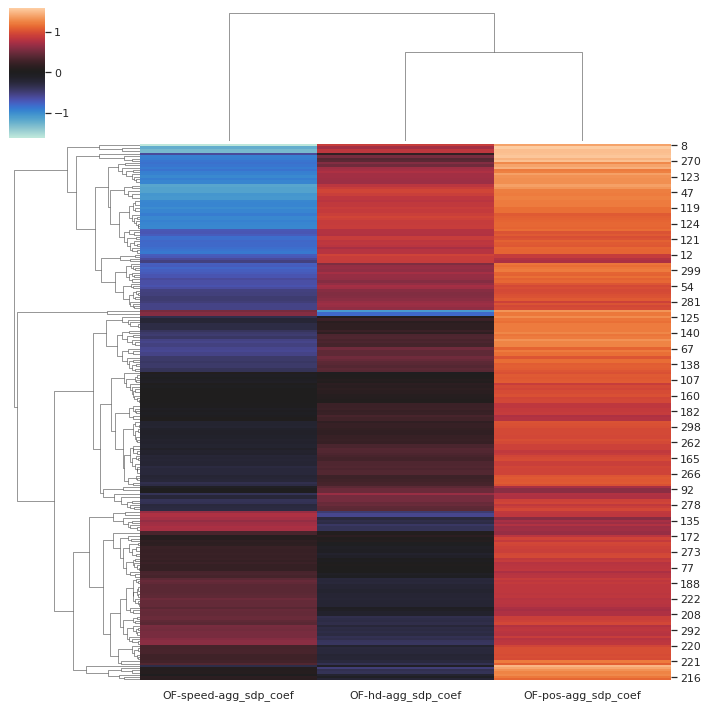

In [159]:
sns.clustermap(Xtrain, center=0)

<AxesSubplot:xlabel='umap_1', ylabel='umap_2'>

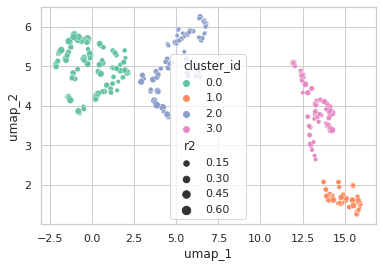

In [60]:
sns.scatterplot(data=of_clusters, x='umap_1', y='umap_2', hue='cluster_id', size='r2', palette='Set2')

In [63]:
means

array([[-0.11694479,  4.944154  ],
       [14.929213  ,  1.6485224 ],
       [ 5.135642  ,  5.0742974 ],
       [13.150829  ,  3.9732122 ]], dtype=float32)

(300,)

In [29]:
score_key = 'agg_sdp_coef'
OF_cluster_scores = [c for c in of_scores if score_key in c]
OF_cluster_scores

['OF-hd-agg_sdp_coef', 'OF-pos-agg_sdp_coef', 'OF-speed-agg_sdp_coef']

Text(0, 0.5, 'OF Model Coefficients')

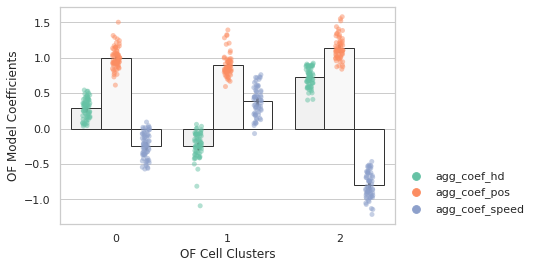

In [1352]:
c3 = c2[of_cols2 + ['of_agg_groups']].melt(id_vars='of_agg_groups')

ax = sns.barplot(data=c3, x='of_agg_groups', y='value', hue='variable', color=[1,1,1,0], edgecolor='0.2')
ax = sns.stripplot(data=c3, x='of_agg_groups', y='value', hue='variable', dodge=True, ax=ax, alpha=0.5, palette="Set2")

h,l = ax.get_legend_handles_labels()

ax.legend(h[:3], l[:3], loc='lower left', bbox_to_anchor=(1,0), frameon=False)
ax.set_xlabel("OF Cell Clusters")
ax.set_ylabel("OF Model Coefficients")

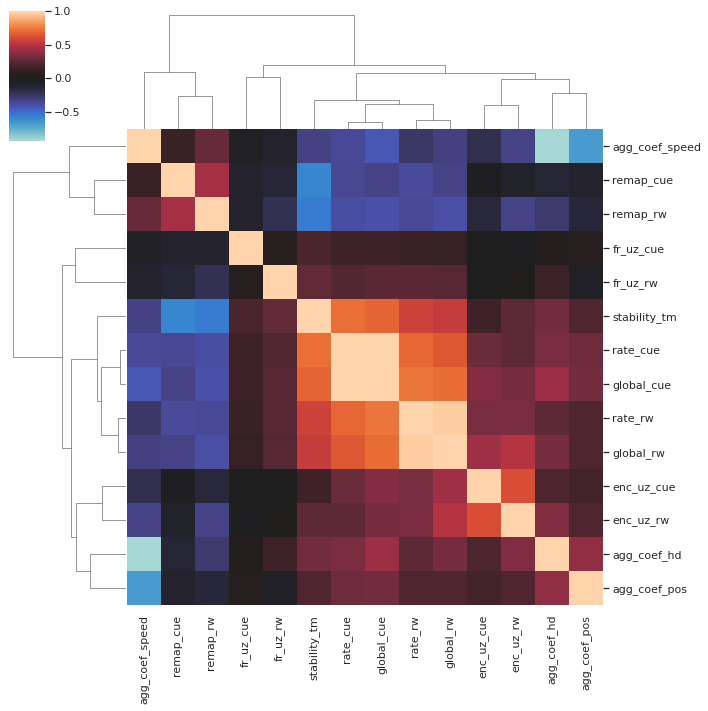

In [1267]:
sns.clustermap(c2[tm_cols + of_cols2].astype(float).corr(method='pearson'), center=0, annot=False)

<AxesSubplot:>

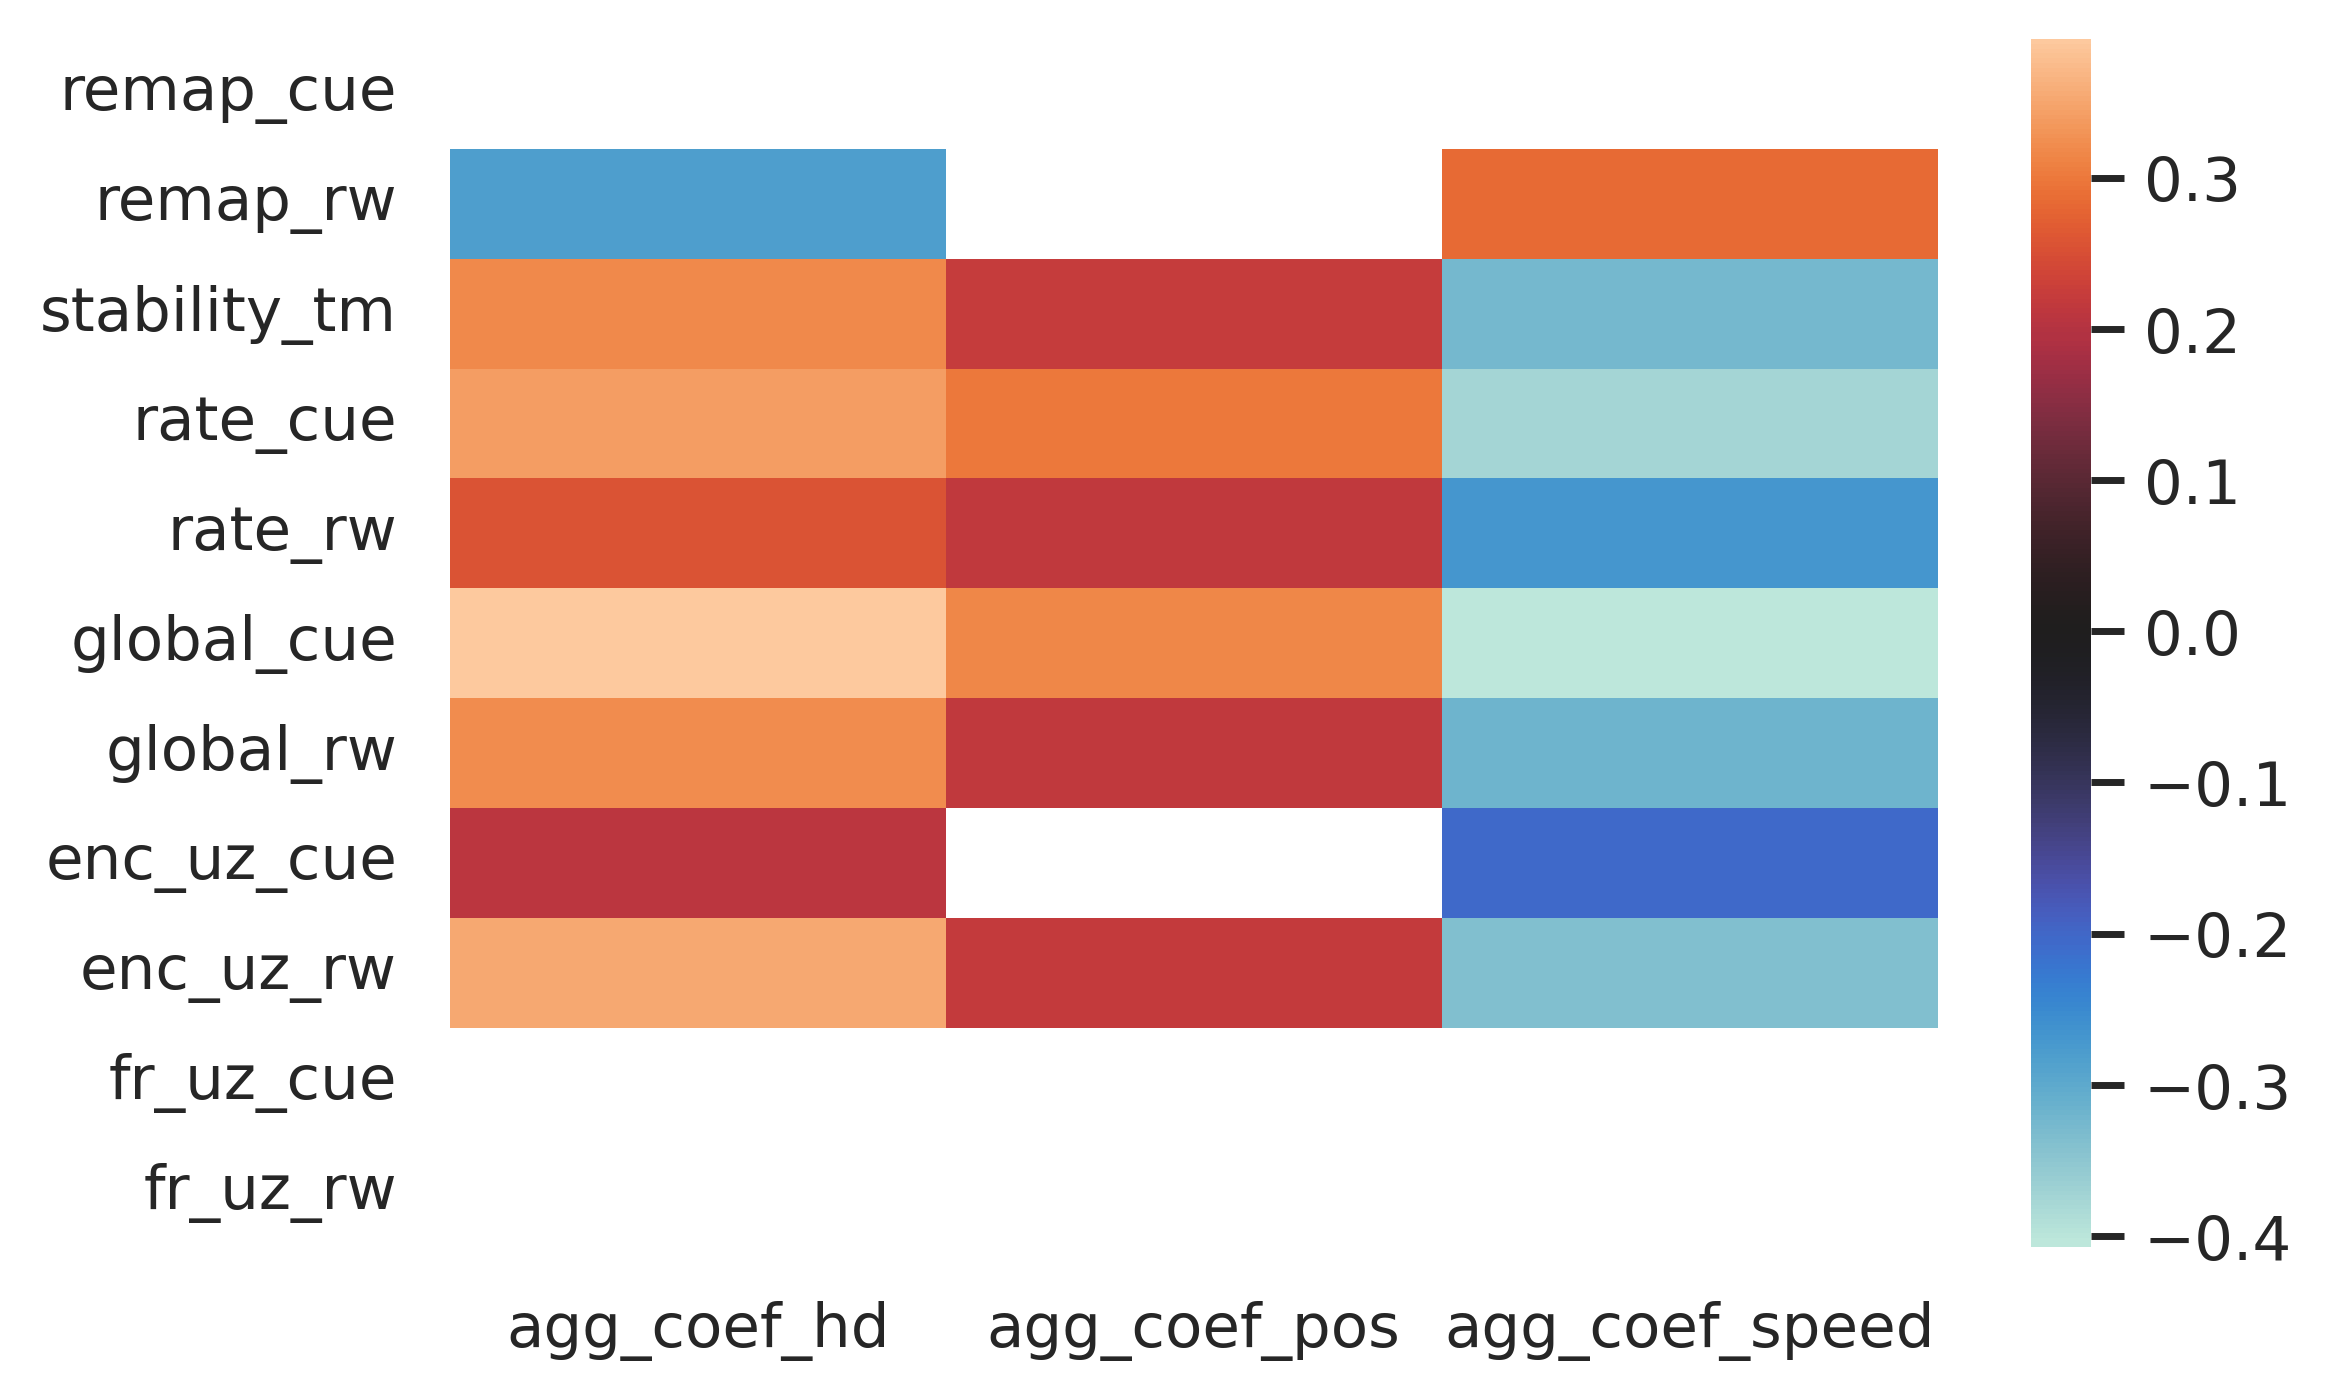

In [1269]:
f,ax=plt.subplots(dpi=400)
c2_sub_corr = c2[cols].corr(method='pearson').loc[tm_cols, of_cols2]
c2_sub_corr_mask = np.abs(c2_sub_corr)<0.2
sns.heatmap(c2_sub_corr, mask=c2_sub_corr_mask, center=0, annot=False, ax=ax, robust=True)

In [1316]:
#tm_var = 'mean_null_cue'
#tm_var = 'uz_cue'
target_var = 'enc_uz_rw'
predictor_vars = tm_cols3 + of_cols2

if isinstance(predictor_vars,list):
    pass
else:
    predictor_vars = [predictor_vars]
    
c3 = c2[[target_var, 'subject', 'of_agg_groups']+predictor_vars].copy().dropna()
mdf = smf.mixedlm(formula=f"{target_var} ~ 1 + {'+'.join(predictor_vars)}",
                  groups='subject', re_formula='1', data=c3).fit()
#mdf = smf.ols(formula=f"{tm_var} ~ 1 + {'+'.join(of_cols)}", data=c2).fit()
#mdf = smf.rlm(formula=f"{tm_var} ~ 1 + {'+'.join(of_cols)}", data=c2).fit()
    
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:             MixedLM  Dependent Variable:  enc_uz_rw
No. Observations:  158      Method:              REML     
No. Groups:        4        Scale:               1.0225   
Min. group size:   3        Log-Likelihood:      -227.0003
Max. group size:   83       Converged:           Yes      
Mean group size:   39.5                                   
----------------------------------------------------------
               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------
Intercept      -6.664    2.040 -3.267 0.001 -10.662 -2.666
fr_uz_cue      -0.038    0.144 -0.267 0.790  -0.321  0.244
fr_uz_rw       -0.049    0.103 -0.474 0.635  -0.251  0.153
agg_coef_hd     5.759    1.911  3.014 0.003   2.014  9.505
agg_coef_pos    5.487    1.925  2.851 0.004   1.715  9.260
agg_coef_speed  5.109    1.896  2.694 0.007   1.392  8.826
subject Var     0.045    0.068                            
==========================================================

"""

<AxesSubplot:xlabel='of_agg_groups', ylabel='enc_uz_rw'>

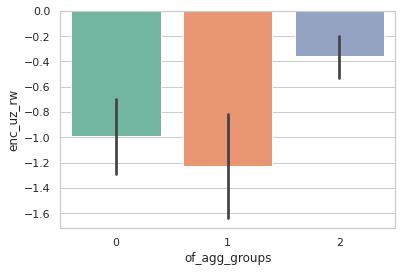

In [1310]:
sns.barplot(x='of_agg_groups', y=target_var, data=c3, palette='Set2')

Group 0 v Group 1
Ttest_indResult(statistic=1.1174869594170216, pvalue=0.2659109603982141)
Group 0 v Group 2
Ttest_indResult(statistic=-3.552488967632898, pvalue=0.0005306204173617921)
Group 1 v Group 2
Ttest_indResult(statistic=-4.487589954202632, pvalue=1.650954435775127e-05)


<AxesSubplot:xlabel='of_agg_groups', ylabel='stability_tm'>

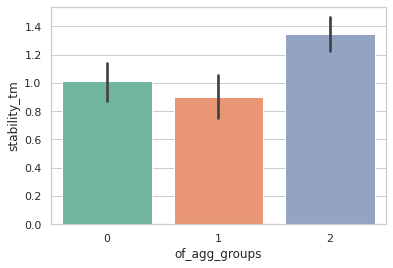

In [1361]:
target_var = "stability_tm"
import scipy.stats as ss
for ii in range(3):
    idx_ii = c2['of_agg_groups']==ii
    for jj in range(ii+1,3):
        idx_jj = c2['of_agg_groups']==jj

        a = ss.ttest_ind(c2[target_var][idx_ii],c2[target_var][idx_jj], 
                         nan_policy='omit', equal_var=False)
        print(f"Group {ii} v Group {jj}")
        print(a)
sns.barplot(x='of_agg_groups', y=target_var, data=c2, palette='Set2')

In [1365]:
c2['subject'][c2['of_agg_groups']==2].value_counts()

Li    34
Cl    19
Ne    13
Name: subject, dtype: int64

0.3764887071823992


<AxesSubplot:xlabel='enc_uz_rw', ylabel='prediction'>

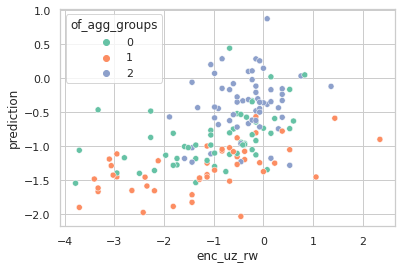

In [1313]:

print(rs.kendall(c3[target_var], mdf.fittedvalues))
c3['prediction'] = mdf.fittedvalues
sns.scatterplot(data=c3, x=target_var, y='prediction', hue='of_agg_groups', palette='Set2',sizes=[10,20])
#plt.plot([-2,0],[-2,0], '--r', lw=3)

In [1132]:
target_var = 'enc_uz_cue'
predictor_vars = of_cols2

if isinstance(predictor_vars,list):
    pass
else:
    predictor_vars = [predictor_vars]
    
c4 = c2[[target_var, 'subject']+predictor_vars].copy().dropna()
mdf = smf.mixedlm(formula=f"{target_var} ~ 1 + {'+'.join(predictor_vars)} ", groups='subject', re_formula='1', data=c4).fit()
    
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM Dependent Variable: enc_uz_cue
No. Observations:  158     Method:             REML      
No. Groups:        4       Scale:              0.7841    
Min. group size:   3       Log-Likelihood:     -206.1554 
Max. group size:   83      Converged:          Yes       
Mean group size:   39.5                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -6.097    1.775 -3.435 0.001 -9.577 -2.618
agg_coef_hd     4.618    1.677  2.754 0.006  1.332  7.904
agg_coef_pos    4.689    1.690  2.775 0.006  1.377  8.002
agg_coef_speed  4.451    1.668  2.669 0.008  1.182  7.720
subject Var     0.113    0.135                           
=========================================================

"""

0.37600018377342553


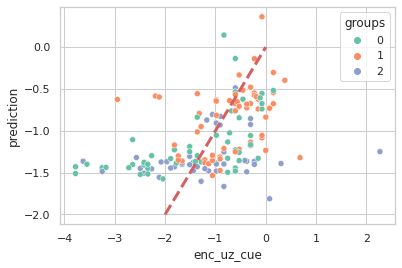

In [1135]:
means, groups, ss= k_means(c4[predictor_vars],3)
c4['groups'] = groups
c4['groups'] = c4['groups'].astype(dtype='category') 
c4['prediction'] = mdf.fittedvalues
print(rs.kendall(c4[target_var], mdf.fittedvalues))
sns.scatterplot(data=c4, x=target_var, y='prediction', hue='groups', palette='Set2',sizes=[10,20])
plt.plot([-2,0],[-2,0], '--r', lw=3)

<AxesSubplot:xlabel='groups', ylabel='enc_uz_cue'>

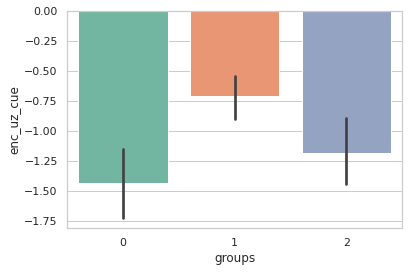

In [1136]:
sns.barplot(x='groups', y=target_var, data=c4, palette='Set2')

In [1149]:
target_var = 'remap_rw'
predictor_vars = of_cols2

if isinstance(predictor_vars,list):
    pass
else:
    predictor_vars = [predictor_vars]
    
c5 = c2[[target_var, 'subject']+predictor_vars].copy().dropna()
mdf = smf.mixedlm(formula=f"{target_var} ~ 1 + {'+'.join(predictor_vars)} ", groups='subject', re_formula='1', data=c5).fit()
    
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:              MixedLM Dependent Variable: remap_rw 
No. Observations:   193     Method:             REML     
No. Groups:         5       Scale:              1.0176   
Min. group size:    1       Log-Likelihood:     -277.5149
Max. group size:    109     Converged:          Yes      
Mean group size:    38.6                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -3.185    1.772 -1.798 0.072 -6.657  0.288
agg_coef_hd     1.874    1.586  1.182 0.237 -1.234  4.982
agg_coef_pos    2.115    1.694  1.248 0.212 -1.205  5.434
agg_coef_speed  2.286    1.607  1.423 0.155 -0.864  5.436
subject Var     0.241    0.299                           
=========================================================

"""

0.2664075993091537


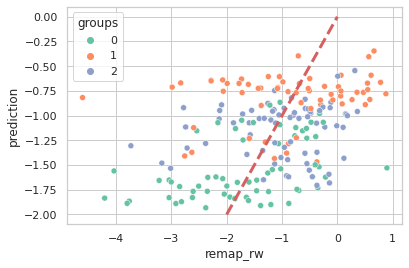

In [1150]:
means, groups, ss= k_means(c5[predictor_vars],3)
c5['groups'] = groups
c5['groups'] = c5['groups'].astype(dtype='category') 
c5['prediction'] = mdf.fittedvalues
print(rs.kendall(c5[target_var], mdf.fittedvalues))
sns.scatterplot(data=c5, x=target_var, y='prediction', hue='groups', palette='Set2',sizes=[10,20])
plt.plot([-2,0],[-2,0], '--r', lw=3)

<AxesSubplot:xlabel='groups', ylabel='remap_rw'>

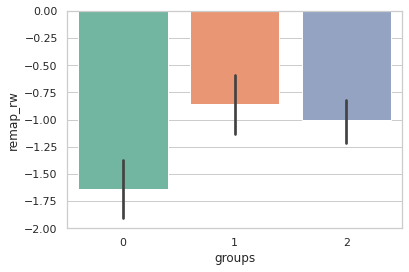

In [1152]:
sns.barplot(x='groups', y=target_var, data=c5, palette='Set2')

<AxesSubplot:>

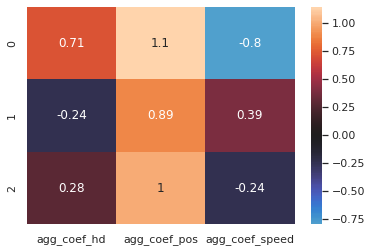

In [1155]:
sns.heatmap(means, xticklabels=predictor_vars, center=0, annot=True)

In [1156]:
target_var = 'remap_cue'
predictor_vars = of_cols2

if isinstance(predictor_vars,list):
    pass
else:
    predictor_vars = [predictor_vars]
    
c5 = c2[[target_var, 'subject']+predictor_vars].copy().dropna()
mdf = smf.mixedlm(formula=f"{target_var} ~ 1 + {'+'.join(predictor_vars)} ", groups='subject', re_formula='1', data=c5).fit()
    
mdf.summary()

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at t

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:              MixedLM Dependent Variable: remap_cue
No. Observations:   196     Method:             REML     
No. Groups:         5       Scale:              1.1634   
Min. group size:    1       Log-Likelihood:     -291.8031
Max. group size:    109     Converged:          Yes      
Mean group size:    39.2                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.770    1.821  0.423 0.672 -2.800  4.340
agg_coef_hd    -1.489    1.635 -0.911 0.362 -4.693  1.715
agg_coef_pos   -1.610    1.760 -0.915 0.360 -5.060  1.839
agg_coef_speed -1.245    1.679 -0.742 0.458 -4.537  2.046
subject Var     0.000                                    
=========================================================

"""

0.10423861852433283


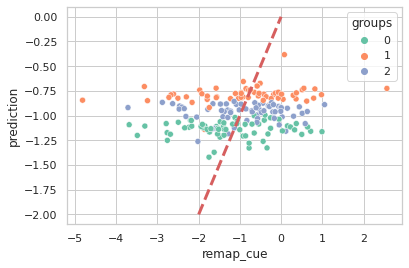

In [1157]:
means, groups, ss= k_means(c5[predictor_vars],3)
c5['groups'] = groups
c5['groups'] = c5['groups'].astype(dtype='category') 
c5['prediction'] = mdf.fittedvalues
print(rs.kendall(c5[target_var], mdf.fittedvalues))
sns.scatterplot(data=c5, x=target_var, y='prediction', hue='groups', palette='Set2',sizes=[10,20])
plt.plot([-2,0],[-2,0], '--r', lw=3)

<AxesSubplot:xlabel='groups', ylabel='remap_cue'>

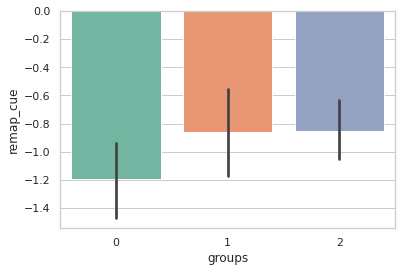

In [1158]:
sns.barplot(x='groups', y=target_var, data=c5, palette='Set2')

<AxesSubplot:>

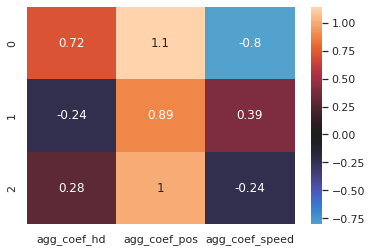

In [1159]:
sns.heatmap(means, xticklabels=predictor_vars, center=0, annot=True)

In [1055]:
y = c2.dropna()[tm_var].values
X = c2.dropna()[of_cols].values

print(of_cols)
B = np.linalg.lstsq(X, y, rcond=None)[0]
print(B)

X2 = np.column_stack((np.ones(X.shape[0]),X))
B2 = np.linalg.lstsq(X2, y, rcond=None)[0]
print(B2)

['r2_hd', 'r2_pos', 'r2_speed', 'agg_coef_hd', 'agg_coef_pos', 'agg_coef_speed', 'coef_score_hd', 'coef_score_pos', 'coef_score_speed', 'metric_score_hd', 'metric_score_speed', 'metric_score_pos']
[-3.33149236 -6.5666128  13.38570195 -1.41119724 -2.34769792 -1.90140325
  0.4655047   1.74677036  0.53760515  1.69466781 -5.12630875  0.90404414]
[-6.38251522 -0.03129842 -7.39767198 12.52123661  4.15467741  4.10471167
  3.67618996  0.57780818  1.46278818  0.44659092 -0.36140105 -4.51019334
  0.83905687]


In [631]:
np.corrcoef((X2@B2), y)[0,1], np.corrcoef((X@B), y)[0,1] 

(0.49559053895996724, 0.46750017864261806)

In [1024]:
from sklearn.cluster import k_means

In [929]:
from sklearn.cross_decomposition import PLSCanonical

plsca = PLSCanonical(n_components=2)

In [959]:
A = c2[tm_cols2[4:]+of_cols2].copy().dropna()
X = A[of_cols2]
Y = A[tm_cols2[4:]]

In [967]:
m=plsca.fit(X,Y)
m.coef_

m.

<bound method RegressorMixin.score of PLSCanonical()>

<AxesSubplot:>

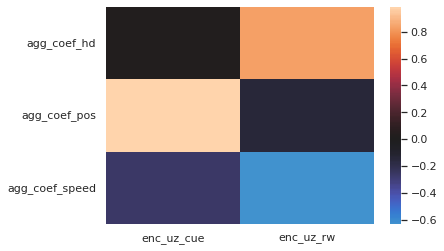

In [966]:
sns.heatmap(m.coef_, xticklabels=tm_cols2[4:], yticklabels=of_cols2, center=0)


In [504]:
col_dict = dict(zip(['Li', 'Ne', 'Cl', 'Ca', 'Al'], mpl.cm.Set1(np.arange(5))))
col_dict

{'Li': array([0.89411765, 0.10196078, 0.10980392, 1.        ]),
 'Ne': array([0.21568627, 0.49411765, 0.72156863, 1.        ]),
 'Cl': array([0.30196078, 0.68627451, 0.29019608, 1.        ]),
 'Ca': array([0.59607843, 0.30588235, 0.63921569, 1.        ]),
 'Al': array([1.        , 0.49803922, 0.        , 1.        ])}

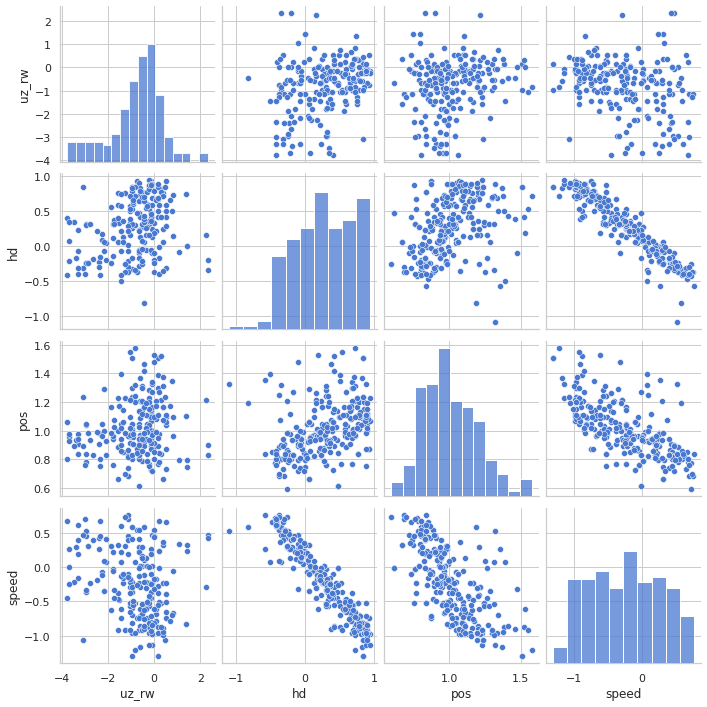

In [512]:
sns.pairplot(combined_table[[tm_var]+of_cols])

In [287]:
mdf.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Robust linear model
=========================================================
Model:              RLM              Df Residuals: 260   
Dependent Variable: rw               Norm:         HuberT
Date:               2022-06-27 15:44 Scale Est.:   mad   
No. Observations:   264              Cov. Type:    H1    
Df Model:           3                Scale:        1.1237
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
---------------------------------------------------------
Intercept  -2.1038   1.5973 -1.3171 0.1878 -5.2343 1.0268
hd          0.5739   1.4417  0.3981 0.6906 -2.2517 3.3996
pos         1.0687   1.5396  0.6942 0.4876 -1.9488 4.0862
speed       1.2745   1.4711  0.8664 0.3863 -1.6088 4.1578
=========================================================

"""

In [233]:
?smf.mixedlm

Signature:
smf.mixedlm(
    formula,
    data,
    re_formula=None,
    vc_formula=None,
    subset=None,
    use_sparse=False,
    missing='none',
    *args,
    **kwargs,
)
Docstring:
Create a Model from a formula and dataframe.

Parameters
----------
formula : str or generic Formula object
    The formula specifying the model
data : array_like
    The data for the model. See Notes.
re_formula : str
    A one-sided formula defining the variance structure of the
    model.  The default gives a random intercept for each
    group.
vc_formula : dict-like
    Formulas describing variance components.  `vc_formula[vc]` is
    the formula for the component with variance parameter named
    `vc`.  The formula is processed into a matrix, and the columns
    of this matrix are linearly combined with independent random
    coefficients having mean zero and a common variance.
subset : array_like
    An array-like object of booleans, integers, or index
    values that indicate the subset of df to